In [1]:
import torch
import torchvision
import torchvision.datasets
import torchvision.transforms
import torch.utils.data
import torch.nn
import os
from matplotlib import pyplot as plt
from torchviz import make_dot # net visualization
import numpy as np
from tqdm import tqdm
import random
import collections

In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.random.manual_seed(SEED)
torch.cuda.random.manual_seed_all(SEED)

### Загрузка данных

Files already downloaded and verified
Files already downloaded and verified
Number of train samples: 40000
Images shape: (32, 32, 3)
Number of valid samples: 10000
Images shape: (32, 32, 3)
Number of test samples: 10000
Images shape: (32, 32, 3)


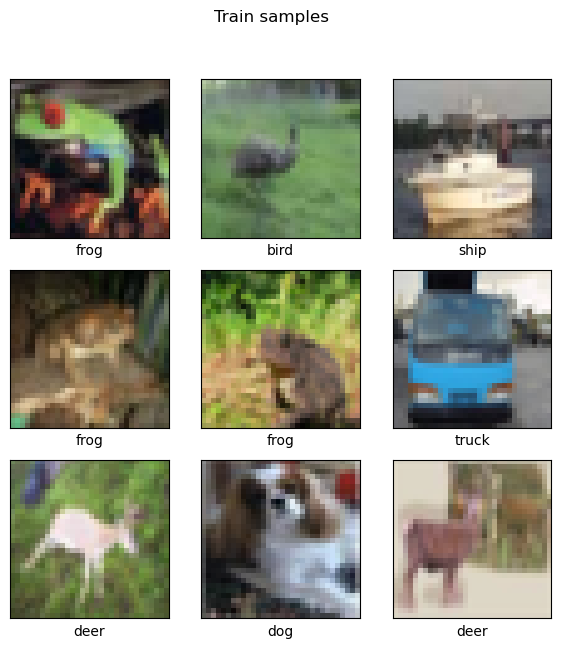

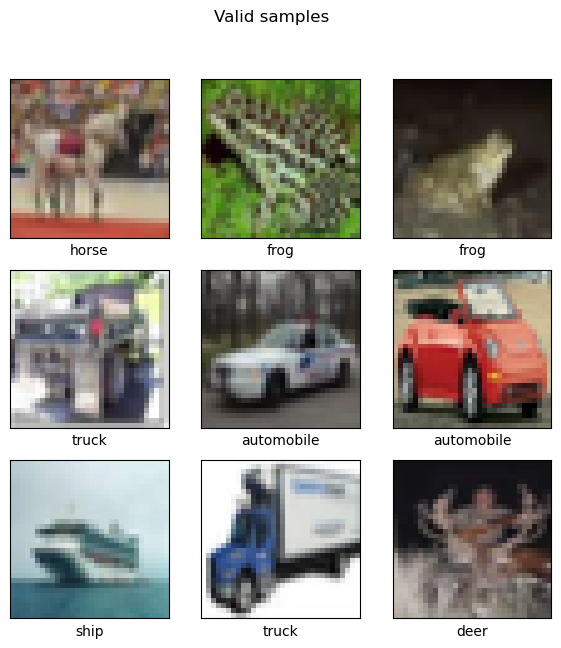

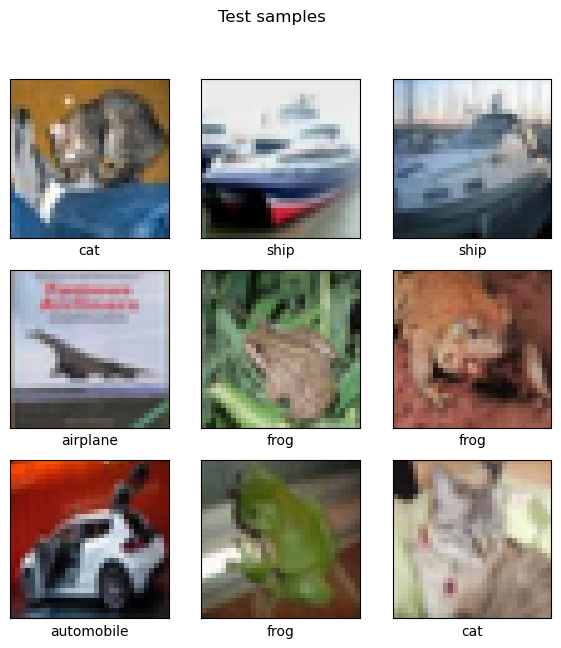

In [3]:
dir_name = os.getcwd()
batch_size = 128

class DatasetFromSubset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        self.class_to_idx = subset.dataset.class_to_idx


        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)

def transform_to_image(image):
    # [Normalize] output = (input - mean) / std
    image = (image - (-train_mean / train_std)) / (1.0 / train_std)
    image = image.clip(0, 1)
    return image

def show_images(images, title):
    num_showed_imgs_x = 3
    num_showed_imgs_y = 3

    figsize = (7, 7)
    fig, axes = plt.subplots(num_showed_imgs_y, num_showed_imgs_x, figsize = figsize)
    fig.suptitle(title)
    print(f'Images shape: {images[0][0].numpy().transpose(1,2,0).shape}')
    plt.setp(plt.gcf().get_axes(), xticks = [], yticks = [])
    classes = {val : key for key, val in images.class_to_idx.items()}
    for i, ax in enumerate(axes.flat):
        img = images[i][0].numpy().transpose(1, 2, 0) #.squeeze(axis = 2)
        label = classes[images[i][1]]
        ax.set_xlabel(label)
        ax.imshow(transform_to_image(img))

train_dataset = torchvision.datasets.CIFAR10(
    root = dir_name, train = True, download = True,
    transform = None
)

train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [0.8, 0.2], generator=torch.Generator().manual_seed(42))
train_mean = np.mean(train_dataset.dataset.data[train_dataset.indices], axis=tuple(range(train_dataset.dataset.data.ndim-1))) / 255
train_std = np.std(train_dataset.dataset.data[train_dataset.indices], axis=tuple(range(train_dataset.dataset.data.ndim-1))) / 255

transform_train = torchvision.transforms.Compose([
    torchvision.transforms.RandomCrop(32),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(train_mean.tolist(), train_std.tolist()), # means and stds
])
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(train_mean.tolist(), train_std.tolist()), # means and stds
])

train_dataset = DatasetFromSubset(train_dataset, transform_train)
valid_dataset = DatasetFromSubset(valid_dataset, transform_test)
test_dataset = torchvision.datasets.CIFAR10(
    root = dir_name, train = False, download = True,
    transform = transform_test
)

print('Number of train samples: {}'.format(len(train_dataset)))
show_images(train_dataset, 'Train samples')

print('Number of valid samples: {}'.format(len(valid_dataset)))
show_images(valid_dataset, 'Valid samples')

print('Number of test samples: {}'.format(len(test_dataset)))
show_images(test_dataset, 'Test samples')

train_data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size = batch_size, shuffle = True
)
valid_data_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size = batch_size, shuffle = False
)
test_data_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size = batch_size, shuffle = False
)

### Тренировка модели

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
def get_accuracy(data_loader, model):
    tp = 0
    n = 0
    model.eval()
    with torch.no_grad():
        for images, labels in data_loader:
            labels = labels.to(device)
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            n += labels.size(0)
            tp += (predicted == labels).sum()
    return tp / n

In [6]:
def model_training(model, model_name, num_epochs, save_model=False):
    learning_rate = 0.1
    momentum = 0.9
    weight_decay = 5e-4

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = momentum, weight_decay = weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, verbose=True)

    pbar = tqdm(range(num_epochs))
    last_epoch_time = 0

    min_valid_loss = None
    epochs_valid_loss = 15
    iters_valid_loss = 0
    best_valid_accuracy = None

    print('#############################################################################################')
    print(f'[Training parameters]\n\tepochs = {num_epochs},\n\tlr = {learning_rate},\n\tmomentum = {momentum},\n\tweight_decay = {weight_decay},\n\tloss = {loss_function},\n\toptimizer = {optimizer},\n\tscheduler = {scheduler},\n\tdevice = {device}')
    print('#############################################################################################')

    for epoch in pbar:
        train_loss = 0.0
        model.train()
        for i, (images, labels) in enumerate(train_data_loader):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss = train_loss / len(train_data_loader)
        train_accuracy = get_accuracy(train_data_loader, model).item()

        valid_loss = 0.0
        model.eval()
        for i, (vimages, vlabels) in enumerate(valid_data_loader):
            vimages = vimages.to(device)
            vlabels = vlabels.to(device)

            voutputs = model(vimages)
            loss = loss_function(voutputs, vlabels)
            valid_loss += loss.item()
        valid_loss = valid_loss / len(valid_data_loader)
        valid_accuracy = get_accuracy(valid_data_loader, model).item()
        scheduler.step()

        print(f'Epoch[{epoch}]:')
        print(f'\ttrain_loss = {round(train_loss, 5)}, train_accuracy = {round(train_accuracy, 8)}')
        print(f'\tvalid_loss = {round(valid_loss, 5)}, valid_accuracy = {round(valid_accuracy, 8)}')
        print(f'\ttime = {round(pbar.format_dict["elapsed"] - last_epoch_time, 2)} s')
        if min_valid_loss is None or min_valid_loss > valid_loss:
            print(f'Validation loss decreased({None if min_valid_loss is None else round(min_valid_loss, 5)}--->{round(valid_loss, 5)}) \t Saving The Model')
            min_valid_loss = valid_loss
            valid_train_loss = train_loss # relative to valid loss
            valid_train_accuracy = train_accuracy # relative to valid loss
            best_valid_accuracy = valid_accuracy
            # Saving State Dict
            torch.save(model.state_dict(), f'{model_name}_model.pth')
            iters_valid_loss = 0
        else:
            iters_valid_loss += 1
        if (iters_valid_loss == epochs_valid_loss):
            print(f"Validation loss didn't decrease for {epochs_valid_loss} epochs ---> model training stopped")
            break
        last_epoch_time = pbar.format_dict["elapsed"]

    # log result
    file = open(f'{model_name}_model.log', 'w')
    file.write(f'[{model_name}]\n\t{model}\n\tvalid training loss: {round(valid_train_loss, 5)}\n\tvalid training accuracy {round(valid_train_accuracy, 8)}\n\tmin validation loss: {round(min_valid_loss, 5)},\n\tbest validation accuracy: {round(best_valid_accuracy, 8)},\n\ttime: {pbar.format_dict["elapsed"]} s')
    file.close()

    print(f'[Finished training]\n\tvalid training loss: {round(valid_train_loss, 5)}\n\tvalid training accuracy {round(valid_train_accuracy, 8)}\n\tmin validation loss: {round(min_valid_loss, 5)},\n\tbest validation accuracy: {round(best_valid_accuracy, 8)}')

In [7]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score
from itertools import cycle
import seaborn as sns

def get_metrics(y_true, y_pred, average='macro'):
  print("Classification Report\n")
  print(classification_report(y_true, y_pred))
  cm = confusion_matrix(y_true, y_pred)
  sns.heatmap(cm, annot=True, cmap='coolwarm', fmt='.3g')
  plt.xlabel('Pred')
  plt.ylabel('True')
  plt.title('Confusion matrix')

  roc_auc = {}
  classes = np.arange(0, 10)
  for cl in classes:
    #creating a list of all the classes except the current class 
    other_class = [x for x in classes if x != cl]

    #marking the current class as 1 and all other classes as 0
    new_actual_class = [0 if x in other_class else 1 for x in y_true]
    new_pred_class = [0 if x in other_class else 1 for x in y_pred]

    roc_auc[cl] = roc_auc_score(new_actual_class, new_pred_class, average=average)
  print('Roc auc scores:')
  for key, val in roc_auc.items():
    print('\t', key, ':', val)

In [8]:
def get_res(data_loader, model):
    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
        for images, labels in data_loader:
            labels = labels.to(device)
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_true.append(labels)
            y_pred.append(predicted)
    y_true = torch.cat(y_true, dim=0)
    y_pred = torch.cat(y_pred, dim=0)
    return y_true.cpu().numpy(), y_pred.cpu().numpy()

In [9]:
import copy

def make_viz(model, model_name):
    model.to('cpu')
    model.eval()
    dataiter = iter(test_data_loader)
    images, labels = next(dataiter)
    out = model(images)
    make_dot(out, params=dict(list(model.named_parameters()))).render(model_name, format="png")


def make_mod(model, model_name):
    model_fc = None
    try:
        model_fc = model.classifier[-1] # for efficient, mobilenet  
    except:
        model_fc = model.fc # for regnet, shuffle
    print(f'Model[{model_name}] last FC before mod:', model_fc)
    try:
        model.classifier[-1] = torch.nn.Linear(model_fc.in_features, 10)
        print(f'Model[{model_name}] last FC after mod:', model.classifier[-1])
    except:
        model.fc = torch.nn.Linear(model_fc.in_features, 10)
        print(f'Model[{model_name}] last FC after mod:', model.fc)


def make_freeze(model, model_name):
    check = {
        'EfficientNet': 'classifier',
        'RegNet': 'fc',
        'ShuffleNetV2': 'fc',
        'MobileNetV3': 'classifier.3'
    }
    for name, param in model.named_parameters():
        if param.requires_grad and not name.startswith(check[model_name]):
            param.requires_grad = False


def model_results(model, model_name, num_epochs, weight_type='model_weights'):
    print('================================================================================')
    make_mod(model, model_name)
    model_full = copy.deepcopy(model) # for full training
    print(f'Model[{model_name}] - full training / {weight_type}')
    make_viz(model_full, model_name + '_full')
    model_training(model_full, model_name + '_full', num_epochs, True)
    print(f'Model[{model_name}] - partial training (last layer) / {weight_type}')
    model_partial = copy.deepcopy(model) # for partial training
    make_freeze(model_partial, model_name)
    make_viz(model_partial, model_name + '_partial')
    model_training(model_partial, model_name + '_partial', num_epochs, True)

In [59]:
models = [
    torchvision.models.get_model('efficientnet_b1', weights='EfficientNet_B1_Weights.IMAGENET1K_V2'),
    torchvision.models.get_model('regnet_y_400mf', weights='RegNet_Y_400MF_Weights.IMAGENET1K_V2'),
    torchvision.models.get_model('shufflenet_v2_x0_5', weights='ShuffleNet_V2_X0_5_Weights.IMAGENET1K_V1'),
    torchvision.models.get_model('mobilenet_v3_small', weights='MobileNet_V3_Small_Weights.IMAGENET1K_V1')
    ]
for model in models:
    print(model)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [10]:
models = [
    torchvision.models.get_model('efficientnet_b1', weights='EfficientNet_B1_Weights.IMAGENET1K_V2'),
    torchvision.models.get_model('regnet_y_400mf', weights='RegNet_Y_400MF_Weights.IMAGENET1K_V2'),
    torchvision.models.get_model('shufflenet_v2_x0_5', weights='ShuffleNet_V2_X0_5_Weights.IMAGENET1K_V1'),
    torchvision.models.get_model('mobilenet_v3_small', weights='MobileNet_V3_Small_Weights.IMAGENET1K_V1')
    ]
model_names = [model.__class__.__name__ for model in models]
for model, model_name in zip(models, model_names):
    model_results(model, model_name, 100)

Model[EfficientNet] last FC before mod: Linear(in_features=1280, out_features=1000, bias=True)
Model[EfficientNet] last FC after mod: Linear(in_features=1280, out_features=10, bias=True)
Model[EfficientNet] - full training / model_weights
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/100 [00:00<?, ?it/s]

#############################################################################################
[Training parameters]
	epochs = 100,
	lr = 0.1,
	momentum = 0.9,
	weight_decay = 0.0005,
	loss = CrossEntropyLoss(),
	optimizer = SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    initial_lr: 0.1
    lr: 0.1
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0005
),
	scheduler = <torch.optim.lr_scheduler.CosineAnnealingLR object at 0x0000026820613D60>,
	device = cuda:0
#############################################################################################


  1%|          | 1/100 [00:47<1:17:42, 47.09s/it]

Adjusting learning rate of group 0 to 9.9975e-02.
Epoch[0]:
	train_loss = 1.62188, train_accuracy = 0.550825
	valid_loss = 1.24034, valid_accuracy = 0.54689997
	time = 47.04 s
Validation loss decreased(None--->1.24034) 	 Saving The Model


  2%|▏         | 2/100 [01:31<1:14:21, 45.53s/it]

Adjusting learning rate of group 0 to 9.9901e-02.
Epoch[1]:
	train_loss = 1.08278, train_accuracy = 0.68072498
	valid_loss = 0.93042, valid_accuracy = 0.67219996
	time = 44.39 s
Validation loss decreased(1.24034--->0.93042) 	 Saving The Model


  3%|▎         | 3/100 [02:14<1:11:59, 44.53s/it]

Adjusting learning rate of group 0 to 9.9778e-02.
Epoch[2]:
	train_loss = 0.88205, train_accuracy = 0.72235
	valid_loss = 0.8342, valid_accuracy = 0.70309997
	time = 43.3 s
Validation loss decreased(0.93042--->0.8342) 	 Saving The Model


  4%|▍         | 4/100 [02:58<1:10:34, 44.10s/it]

Adjusting learning rate of group 0 to 9.9606e-02.
Epoch[3]:
	train_loss = 0.77413, train_accuracy = 0.75657499
	valid_loss = 0.7625, valid_accuracy = 0.73969996
	time = 43.41 s
Validation loss decreased(0.8342--->0.7625) 	 Saving The Model


  5%|▌         | 5/100 [03:42<1:09:44, 44.05s/it]

Adjusting learning rate of group 0 to 9.9384e-02.
Epoch[4]:
	train_loss = 0.7727, train_accuracy = 0.76317495
	valid_loss = 0.73857, valid_accuracy = 0.74719995
	time = 43.9 s
Validation loss decreased(0.7625--->0.73857) 	 Saving The Model


  6%|▌         | 6/100 [04:24<1:08:15, 43.57s/it]

Adjusting learning rate of group 0 to 9.9114e-02.
Epoch[5]:
	train_loss = 0.71413, train_accuracy = 0.75567496
	valid_loss = 0.76065, valid_accuracy = 0.73589998
	time = 42.65 s


  7%|▋         | 7/100 [05:07<1:07:07, 43.31s/it]

Adjusting learning rate of group 0 to 9.8796e-02.
Epoch[6]:
	train_loss = 0.67811, train_accuracy = 0.76442498
	valid_loss = 0.719, valid_accuracy = 0.74469995
	time = 42.71 s
Validation loss decreased(0.73857--->0.719) 	 Saving The Model


  8%|▊         | 8/100 [05:50<1:06:03, 43.08s/it]

Adjusting learning rate of group 0 to 9.8429e-02.
Epoch[7]:
	train_loss = 0.66111, train_accuracy = 0.777125
	valid_loss = 0.69988, valid_accuracy = 0.75389999
	time = 42.56 s
Validation loss decreased(0.719--->0.69988) 	 Saving The Model


  9%|▉         | 9/100 [06:32<1:05:05, 42.92s/it]

Adjusting learning rate of group 0 to 9.8015e-02.
Epoch[8]:
	train_loss = 0.66782, train_accuracy = 0.77887499
	valid_loss = 0.70652, valid_accuracy = 0.7568
	time = 42.55 s


 10%|█         | 10/100 [07:15<1:04:18, 42.87s/it]

Adjusting learning rate of group 0 to 9.7553e-02.
Epoch[9]:
	train_loss = 0.67469, train_accuracy = 0.759
	valid_loss = 0.73918, valid_accuracy = 0.73869997
	time = 42.78 s


 11%|█         | 11/100 [07:58<1:03:38, 42.90s/it]

Adjusting learning rate of group 0 to 9.7044e-02.
Epoch[10]:
	train_loss = 0.66986, train_accuracy = 0.75177497
	valid_loss = 0.77331, valid_accuracy = 0.73449999
	time = 42.97 s


 12%|█▏        | 12/100 [08:41<1:02:52, 42.87s/it]

Adjusting learning rate of group 0 to 9.6489e-02.
Epoch[11]:
	train_loss = 0.6734, train_accuracy = 0.78824997
	valid_loss = 0.66506, valid_accuracy = 0.77349997
	time = 42.74 s
Validation loss decreased(0.69988--->0.66506) 	 Saving The Model


 13%|█▎        | 13/100 [09:24<1:02:16, 42.95s/it]

Adjusting learning rate of group 0 to 9.5888e-02.
Epoch[12]:
	train_loss = 0.67448, train_accuracy = 0.75207496
	valid_loss = 0.73751, valid_accuracy = 0.73199999
	time = 43.13 s


 14%|█▍        | 14/100 [10:07<1:01:37, 43.00s/it]

Adjusting learning rate of group 0 to 9.5241e-02.
Epoch[13]:
	train_loss = 0.67044, train_accuracy = 0.78882498
	valid_loss = 0.66915, valid_accuracy = 0.77029997
	time = 43.11 s


 15%|█▌        | 15/100 [10:50<1:00:52, 42.97s/it]

Adjusting learning rate of group 0 to 9.4550e-02.
Epoch[14]:
	train_loss = 0.6668, train_accuracy = 0.75762498
	valid_loss = 0.7651, valid_accuracy = 0.73399997
	time = 42.9 s


 16%|█▌        | 16/100 [11:33<1:00:20, 43.11s/it]

Adjusting learning rate of group 0 to 9.3815e-02.
Epoch[15]:
	train_loss = 0.6671, train_accuracy = 0.73927498
	valid_loss = 0.83764, valid_accuracy = 0.72359997
	time = 43.43 s


 17%|█▋        | 17/100 [12:16<59:33, 43.05s/it]  

Adjusting learning rate of group 0 to 9.3037e-02.
Epoch[16]:
	train_loss = 0.66145, train_accuracy = 0.76854998
	valid_loss = 0.7218, valid_accuracy = 0.74659997
	time = 42.93 s


 18%|█▊        | 18/100 [12:59<58:39, 42.92s/it]

Adjusting learning rate of group 0 to 9.2216e-02.
Epoch[17]:
	train_loss = 0.66202, train_accuracy = 0.76702499
	valid_loss = 0.72927, valid_accuracy = 0.745
	time = 42.61 s


 19%|█▉        | 19/100 [13:42<57:54, 42.90s/it]

Adjusting learning rate of group 0 to 9.1354e-02.
Epoch[18]:
	train_loss = 0.6622, train_accuracy = 0.76362497
	valid_loss = 0.7639, valid_accuracy = 0.7367
	time = 42.84 s


 20%|██        | 20/100 [14:26<57:36, 43.20s/it]

Adjusting learning rate of group 0 to 9.0451e-02.
Epoch[19]:
	train_loss = 0.66608, train_accuracy = 0.729375
	valid_loss = 0.87947, valid_accuracy = 0.70300001
	time = 43.92 s


 21%|██        | 21/100 [15:09<57:04, 43.34s/it]

Adjusting learning rate of group 0 to 8.9508e-02.
Epoch[20]:
	train_loss = 0.64884, train_accuracy = 0.79467499
	valid_loss = 0.67362, valid_accuracy = 0.76739997
	time = 43.67 s


 22%|██▏       | 22/100 [15:53<56:15, 43.27s/it]

Adjusting learning rate of group 0 to 8.8526e-02.
Epoch[21]:
	train_loss = 0.65247, train_accuracy = 0.79777497
	valid_loss = 0.65734, valid_accuracy = 0.773
	time = 43.04 s
Validation loss decreased(0.66506--->0.65734) 	 Saving The Model


 23%|██▎       | 23/100 [16:35<55:16, 43.07s/it]

Adjusting learning rate of group 0 to 8.7506e-02.
Epoch[22]:
	train_loss = 0.64972, train_accuracy = 0.7834
	valid_loss = 0.70566, valid_accuracy = 0.75959998
	time = 42.6 s


 24%|██▍       | 24/100 [17:18<54:31, 43.05s/it]

Adjusting learning rate of group 0 to 8.6448e-02.
Epoch[23]:
	train_loss = 0.63929, train_accuracy = 0.78889996
	valid_loss = 0.6805, valid_accuracy = 0.75949997
	time = 43.01 s


 25%|██▌       | 25/100 [18:01<53:55, 43.15s/it]

Adjusting learning rate of group 0 to 8.5355e-02.
Epoch[24]:
	train_loss = 0.63904, train_accuracy = 0.80135
	valid_loss = 0.65545, valid_accuracy = 0.77629995
	time = 43.32 s
Validation loss decreased(0.65734--->0.65545) 	 Saving The Model


 26%|██▌       | 26/100 [18:44<52:59, 42.97s/it]

Adjusting learning rate of group 0 to 8.4227e-02.
Epoch[25]:
	train_loss = 0.62971, train_accuracy = 0.78314996
	valid_loss = 0.7047, valid_accuracy = 0.75909996
	time = 42.55 s


 27%|██▋       | 27/100 [19:27<52:21, 43.03s/it]

Adjusting learning rate of group 0 to 8.3066e-02.
Epoch[26]:
	train_loss = 0.62668, train_accuracy = 0.78417498
	valid_loss = 0.70802, valid_accuracy = 0.76229995
	time = 43.19 s


 28%|██▊       | 28/100 [20:10<51:36, 43.01s/it]

Adjusting learning rate of group 0 to 8.1871e-02.
Epoch[27]:
	train_loss = 0.61671, train_accuracy = 0.77934998
	valid_loss = 0.7071, valid_accuracy = 0.75129998
	time = 42.96 s


 29%|██▉       | 29/100 [20:53<50:49, 42.95s/it]

Adjusting learning rate of group 0 to 8.0645e-02.
Epoch[28]:
	train_loss = 0.61317, train_accuracy = 0.78462499
	valid_loss = 0.69071, valid_accuracy = 0.76249999
	time = 42.79 s


 30%|███       | 30/100 [21:36<50:06, 42.95s/it]

Adjusting learning rate of group 0 to 7.9389e-02.
Epoch[29]:
	train_loss = 0.61001, train_accuracy = 0.81002498
	valid_loss = 0.64528, valid_accuracy = 0.7791
	time = 42.92 s
Validation loss decreased(0.65545--->0.64528) 	 Saving The Model


 31%|███       | 31/100 [22:19<49:34, 43.11s/it]

Adjusting learning rate of group 0 to 7.8104e-02.
Epoch[30]:
	train_loss = 0.61473, train_accuracy = 0.78944999
	valid_loss = 0.65777, valid_accuracy = 0.76709998
	time = 43.48 s


 32%|███▏      | 32/100 [23:03<48:51, 43.10s/it]

Adjusting learning rate of group 0 to 7.6791e-02.
Epoch[31]:
	train_loss = 0.60456, train_accuracy = 0.77919996
	valid_loss = 0.72694, valid_accuracy = 0.75150001
	time = 43.09 s


 33%|███▎      | 33/100 [23:54<51:05, 45.76s/it]

Adjusting learning rate of group 0 to 7.5452e-02.
Epoch[32]:
	train_loss = 0.59884, train_accuracy = 0.79717499
	valid_loss = 0.68488, valid_accuracy = 0.76769996
	time = 51.94 s


 34%|███▍      | 34/100 [24:50<53:32, 48.68s/it]

Adjusting learning rate of group 0 to 7.4088e-02.
Epoch[33]:
	train_loss = 0.59231, train_accuracy = 0.782125
	valid_loss = 0.69315, valid_accuracy = 0.75769997
	time = 55.49 s


 35%|███▌      | 35/100 [25:44<54:33, 50.36s/it]

Adjusting learning rate of group 0 to 7.2700e-02.
Epoch[34]:
	train_loss = 0.59197, train_accuracy = 0.81332499
	valid_loss = 0.63093, valid_accuracy = 0.78639996
	time = 54.23 s
Validation loss decreased(0.64528--->0.63093) 	 Saving The Model


 36%|███▌      | 36/100 [26:37<54:20, 50.95s/it]

Adjusting learning rate of group 0 to 7.1289e-02.
Epoch[35]:
	train_loss = 0.57215, train_accuracy = 0.81474996
	valid_loss = 0.62699, valid_accuracy = 0.78319997
	time = 52.26 s
Validation loss decreased(0.63093--->0.62699) 	 Saving The Model


 37%|███▋      | 37/100 [27:29<53:50, 51.27s/it]

Adjusting learning rate of group 0 to 6.9857e-02.
Epoch[36]:
	train_loss = 0.57959, train_accuracy = 0.8301
	valid_loss = 0.57708, valid_accuracy = 0.80109996
	time = 51.97 s
Validation loss decreased(0.62699--->0.57708) 	 Saving The Model


 38%|███▊      | 38/100 [28:18<52:30, 50.82s/it]

Adjusting learning rate of group 0 to 6.8406e-02.
Epoch[37]:
	train_loss = 0.56943, train_accuracy = 0.82247496
	valid_loss = 0.59752, valid_accuracy = 0.7931
	time = 49.76 s


 39%|███▉      | 39/100 [29:03<49:44, 48.93s/it]

Adjusting learning rate of group 0 to 6.6937e-02.
Epoch[38]:
	train_loss = 0.5675, train_accuracy = 0.79782498
	valid_loss = 0.67157, valid_accuracy = 0.76839995
	time = 44.53 s


 40%|████      | 40/100 [29:47<47:36, 47.60s/it]

Adjusting learning rate of group 0 to 6.5451e-02.
Epoch[39]:
	train_loss = 0.55923, train_accuracy = 0.82157499
	valid_loss = 0.60654, valid_accuracy = 0.78969997
	time = 44.5 s


 41%|████      | 41/100 [30:31<45:45, 46.53s/it]

Adjusting learning rate of group 0 to 6.3950e-02.
Epoch[40]:
	train_loss = 0.55442, train_accuracy = 0.81847501
	valid_loss = 0.61489, valid_accuracy = 0.78490001
	time = 44.01 s


 42%|████▏     | 42/100 [31:16<44:18, 45.84s/it]

Adjusting learning rate of group 0 to 6.2434e-02.
Epoch[41]:
	train_loss = 0.54891, train_accuracy = 0.81584996
	valid_loss = 0.61335, valid_accuracy = 0.78619999
	time = 44.23 s


 43%|████▎     | 43/100 [32:00<43:06, 45.38s/it]

Adjusting learning rate of group 0 to 6.0907e-02.
Epoch[42]:
	train_loss = 0.53785, train_accuracy = 0.82674998
	valid_loss = 0.58634, valid_accuracy = 0.7942
	time = 44.31 s


 44%|████▍     | 44/100 [32:44<42:03, 45.06s/it]

Adjusting learning rate of group 0 to 5.9369e-02.
Epoch[43]:
	train_loss = 0.54445, train_accuracy = 0.81659997
	valid_loss = 0.61775, valid_accuracy = 0.78579998
	time = 44.3 s


 45%|████▌     | 45/100 [33:29<41:06, 44.85s/it]

Adjusting learning rate of group 0 to 5.7822e-02.
Epoch[44]:
	train_loss = 0.53092, train_accuracy = 0.82255
	valid_loss = 0.60888, valid_accuracy = 0.79179996
	time = 44.36 s


 46%|████▌     | 46/100 [34:13<40:12, 44.68s/it]

Adjusting learning rate of group 0 to 5.6267e-02.
Epoch[45]:
	train_loss = 0.52849, train_accuracy = 0.82835001
	valid_loss = 0.59471, valid_accuracy = 0.79619998
	time = 44.29 s


 47%|████▋     | 47/100 [34:58<39:32, 44.76s/it]

Adjusting learning rate of group 0 to 5.4705e-02.
Epoch[46]:
	train_loss = 0.51563, train_accuracy = 0.82744998
	valid_loss = 0.60452, valid_accuracy = 0.78939998
	time = 44.96 s


 48%|████▊     | 48/100 [35:43<38:49, 44.80s/it]

Adjusting learning rate of group 0 to 5.3140e-02.
Epoch[47]:
	train_loss = 0.51159, train_accuracy = 0.83252496
	valid_loss = 0.59414, valid_accuracy = 0.79809999
	time = 44.87 s


 49%|████▉     | 49/100 [36:28<38:09, 44.90s/it]

Adjusting learning rate of group 0 to 5.1571e-02.
Epoch[48]:
	train_loss = 0.50556, train_accuracy = 0.83452499
	valid_loss = 0.58509, valid_accuracy = 0.79960001
	time = 45.13 s


 50%|█████     | 50/100 [37:14<37:47, 45.34s/it]

Adjusting learning rate of group 0 to 5.0000e-02.
Epoch[49]:
	train_loss = 0.50417, train_accuracy = 0.84157497
	valid_loss = 0.56431, valid_accuracy = 0.8071
	time = 46.32 s
Validation loss decreased(0.57708--->0.56431) 	 Saving The Model


 51%|█████     | 51/100 [38:01<37:29, 45.90s/it]

Adjusting learning rate of group 0 to 4.8429e-02.
Epoch[50]:
	train_loss = 0.49511, train_accuracy = 0.84759998
	valid_loss = 0.55223, valid_accuracy = 0.80860001
	time = 47.15 s
Validation loss decreased(0.56431--->0.55223) 	 Saving The Model


 52%|█████▏    | 52/100 [38:58<39:10, 48.98s/it]

Adjusting learning rate of group 0 to 4.6860e-02.
Epoch[51]:
	train_loss = 0.48817, train_accuracy = 0.83579999
	valid_loss = 0.5918, valid_accuracy = 0.79789996
	time = 56.16 s


 53%|█████▎    | 53/100 [40:00<41:24, 52.87s/it]

Adjusting learning rate of group 0 to 4.5295e-02.
Epoch[52]:
	train_loss = 0.48168, train_accuracy = 0.83089995
	valid_loss = 0.60691, valid_accuracy = 0.79209995
	time = 61.93 s


 54%|█████▍    | 54/100 [40:45<38:45, 50.56s/it]

Adjusting learning rate of group 0 to 4.3733e-02.
Epoch[53]:
	train_loss = 0.47155, train_accuracy = 0.86272496
	valid_loss = 0.52494, valid_accuracy = 0.82119995
	time = 45.11 s
Validation loss decreased(0.55223--->0.52494) 	 Saving The Model


 55%|█████▌    | 55/100 [41:30<36:39, 48.88s/it]

Adjusting learning rate of group 0 to 4.2178e-02.
Epoch[54]:
	train_loss = 0.46221, train_accuracy = 0.84969997
	valid_loss = 0.5695, valid_accuracy = 0.80849999
	time = 44.96 s


 56%|█████▌    | 56/100 [42:15<35:05, 47.85s/it]

Adjusting learning rate of group 0 to 4.0631e-02.
Epoch[55]:
	train_loss = 0.45945, train_accuracy = 0.848575
	valid_loss = 0.56365, valid_accuracy = 0.8021
	time = 45.44 s


 57%|█████▋    | 57/100 [43:04<34:24, 48.01s/it]

Adjusting learning rate of group 0 to 3.9093e-02.
Epoch[56]:
	train_loss = 0.45233, train_accuracy = 0.85462499
	valid_loss = 0.54917, valid_accuracy = 0.81110001
	time = 48.4 s


 58%|█████▊    | 58/100 [43:53<33:53, 48.41s/it]

Adjusting learning rate of group 0 to 3.7566e-02.
Epoch[57]:
	train_loss = 0.44023, train_accuracy = 0.8563
	valid_loss = 0.55827, valid_accuracy = 0.80729997
	time = 49.33 s


 59%|█████▉    | 59/100 [44:41<33:06, 48.45s/it]

Adjusting learning rate of group 0 to 3.6050e-02.
Epoch[58]:
	train_loss = 0.43795, train_accuracy = 0.86794996
	valid_loss = 0.50683, valid_accuracy = 0.8251
	time = 48.49 s
Validation loss decreased(0.52494--->0.50683) 	 Saving The Model


 60%|██████    | 60/100 [45:26<31:34, 47.36s/it]

Adjusting learning rate of group 0 to 3.4549e-02.
Epoch[59]:
	train_loss = 0.43217, train_accuracy = 0.87512499
	valid_loss = 0.50155, valid_accuracy = 0.8272
	time = 44.77 s
Validation loss decreased(0.50683--->0.50155) 	 Saving The Model


 61%|██████    | 61/100 [46:10<30:10, 46.42s/it]

Adjusting learning rate of group 0 to 3.3063e-02.
Epoch[60]:
	train_loss = 0.41977, train_accuracy = 0.85732496
	valid_loss = 0.56064, valid_accuracy = 0.80860001
	time = 44.23 s


 62%|██████▏   | 62/100 [46:55<29:03, 45.88s/it]

Adjusting learning rate of group 0 to 3.1594e-02.
Epoch[61]:
	train_loss = 0.40857, train_accuracy = 0.86127496
	valid_loss = 0.56228, valid_accuracy = 0.81079996
	time = 44.62 s


 63%|██████▎   | 63/100 [47:41<28:15, 45.81s/it]

Adjusting learning rate of group 0 to 3.0143e-02.
Epoch[62]:
	train_loss = 0.40013, train_accuracy = 0.87572497
	valid_loss = 0.52242, valid_accuracy = 0.82339996
	time = 45.66 s


 64%|██████▍   | 64/100 [48:27<27:29, 45.83s/it]

Adjusting learning rate of group 0 to 2.8711e-02.
Epoch[63]:
	train_loss = 0.39339, train_accuracy = 0.88017499
	valid_loss = 0.49088, valid_accuracy = 0.82909995
	time = 45.8 s
Validation loss decreased(0.50155--->0.49088) 	 Saving The Model


 65%|██████▌   | 65/100 [49:12<26:39, 45.69s/it]

Adjusting learning rate of group 0 to 2.7300e-02.
Epoch[64]:
	train_loss = 0.38436, train_accuracy = 0.88664997
	valid_loss = 0.47992, valid_accuracy = 0.83499998
	time = 45.34 s
Validation loss decreased(0.49088--->0.47992) 	 Saving The Model


 66%|██████▌   | 66/100 [49:58<25:56, 45.77s/it]

Adjusting learning rate of group 0 to 2.5912e-02.
Epoch[65]:
	train_loss = 0.37417, train_accuracy = 0.88264996
	valid_loss = 0.49566, valid_accuracy = 0.83069998
	time = 45.94 s


 67%|██████▋   | 67/100 [50:43<25:05, 45.61s/it]

Adjusting learning rate of group 0 to 2.4548e-02.
Epoch[66]:
	train_loss = 0.37086, train_accuracy = 0.87954998
	valid_loss = 0.5186, valid_accuracy = 0.82179999
	time = 45.23 s


 68%|██████▊   | 68/100 [51:29<24:21, 45.67s/it]

Adjusting learning rate of group 0 to 2.3209e-02.
Epoch[67]:
	train_loss = 0.35559, train_accuracy = 0.891325
	valid_loss = 0.48795, valid_accuracy = 0.83209997
	time = 45.81 s


 69%|██████▉   | 69/100 [52:16<23:50, 46.15s/it]

Adjusting learning rate of group 0 to 2.1896e-02.
Epoch[68]:
	train_loss = 0.35038, train_accuracy = 0.896375
	valid_loss = 0.47441, valid_accuracy = 0.8398
	time = 47.23 s
Validation loss decreased(0.47992--->0.47441) 	 Saving The Model


 70%|███████   | 70/100 [53:04<23:21, 46.73s/it]

Adjusting learning rate of group 0 to 2.0611e-02.
Epoch[69]:
	train_loss = 0.33884, train_accuracy = 0.90314996
	valid_loss = 0.48143, valid_accuracy = 0.83669996
	time = 48.09 s


 71%|███████   | 71/100 [53:53<22:54, 47.39s/it]

Adjusting learning rate of group 0 to 1.9355e-02.
Epoch[70]:
	train_loss = 0.32795, train_accuracy = 0.90429997
	valid_loss = 0.47559, valid_accuracy = 0.84129995
	time = 48.91 s


 72%|███████▏  | 72/100 [54:41<22:12, 47.60s/it]

Adjusting learning rate of group 0 to 1.8129e-02.
Epoch[71]:
	train_loss = 0.32358, train_accuracy = 0.90477496
	valid_loss = 0.47753, valid_accuracy = 0.83629996
	time = 48.09 s


 73%|███████▎  | 73/100 [55:27<21:07, 46.94s/it]

Adjusting learning rate of group 0 to 1.6934e-02.
Epoch[72]:
	train_loss = 0.30881, train_accuracy = 0.91684997
	valid_loss = 0.45122, valid_accuracy = 0.84209996
	time = 45.35 s
Validation loss decreased(0.47441--->0.45122) 	 Saving The Model


 74%|███████▍  | 74/100 [56:15<20:29, 47.29s/it]

Adjusting learning rate of group 0 to 1.5773e-02.
Epoch[73]:
	train_loss = 0.29596, train_accuracy = 0.91052496
	valid_loss = 0.48263, valid_accuracy = 0.83709997
	time = 48.11 s


 75%|███████▌  | 75/100 [56:59<19:19, 46.36s/it]

Adjusting learning rate of group 0 to 1.4645e-02.
Epoch[74]:
	train_loss = 0.28699, train_accuracy = 0.92095
	valid_loss = 0.43962, valid_accuracy = 0.84859997
	time = 44.15 s
Validation loss decreased(0.45122--->0.43962) 	 Saving The Model


 76%|███████▌  | 76/100 [57:42<18:08, 45.34s/it]

Adjusting learning rate of group 0 to 1.3552e-02.
Epoch[75]:
	train_loss = 0.2746, train_accuracy = 0.91872495
	valid_loss = 0.46702, valid_accuracy = 0.84679997
	time = 42.96 s


 77%|███████▋  | 77/100 [58:25<17:08, 44.72s/it]

Adjusting learning rate of group 0 to 1.2494e-02.
Epoch[76]:
	train_loss = 0.26294, train_accuracy = 0.93254995
	valid_loss = 0.43192, valid_accuracy = 0.85359997
	time = 43.22 s
Validation loss decreased(0.43962--->0.43192) 	 Saving The Model


 78%|███████▊  | 78/100 [59:09<16:17, 44.43s/it]

Adjusting learning rate of group 0 to 1.1474e-02.
Epoch[77]:
	train_loss = 0.2561, train_accuracy = 0.93304998
	valid_loss = 0.44362, valid_accuracy = 0.85229999
	time = 43.75 s


 79%|███████▉  | 79/100 [59:53<15:32, 44.38s/it]

Adjusting learning rate of group 0 to 1.0492e-02.
Epoch[78]:
	train_loss = 0.23781, train_accuracy = 0.9411
	valid_loss = 0.43426, valid_accuracy = 0.85579997
	time = 44.27 s


 80%|████████  | 80/100 [1:00:37<14:43, 44.15s/it]

Adjusting learning rate of group 0 to 9.5492e-03.
Epoch[79]:
	train_loss = 0.22595, train_accuracy = 0.93672496
	valid_loss = 0.45123, valid_accuracy = 0.84939998
	time = 43.61 s


 81%|████████  | 81/100 [1:01:21<14:00, 44.23s/it]

Adjusting learning rate of group 0 to 8.6460e-03.
Epoch[80]:
	train_loss = 0.21833, train_accuracy = 0.94707495
	valid_loss = 0.44036, valid_accuracy = 0.85429996
	time = 44.43 s


 82%|████████▏ | 82/100 [1:02:05<13:11, 43.98s/it]

Adjusting learning rate of group 0 to 7.7836e-03.
Epoch[81]:
	train_loss = 0.20584, train_accuracy = 0.94755
	valid_loss = 0.44097, valid_accuracy = 0.85600001
	time = 43.37 s


 83%|████████▎ | 83/100 [1:02:49<12:27, 43.95s/it]

Adjusting learning rate of group 0 to 6.9629e-03.
Epoch[82]:
	train_loss = 0.19043, train_accuracy = 0.95642495
	valid_loss = 0.43709, valid_accuracy = 0.85600001
	time = 43.88 s


 84%|████████▍ | 84/100 [1:03:33<11:46, 44.13s/it]

Adjusting learning rate of group 0 to 6.1847e-03.
Epoch[83]:
	train_loss = 0.17956, train_accuracy = 0.95999998
	valid_loss = 0.42898, valid_accuracy = 0.86109996
	time = 44.49 s
Validation loss decreased(0.43192--->0.42898) 	 Saving The Model


 85%|████████▌ | 85/100 [1:04:17<10:59, 43.96s/it]

Adjusting learning rate of group 0 to 5.4497e-03.
Epoch[84]:
	train_loss = 0.16746, train_accuracy = 0.964625
	valid_loss = 0.42307, valid_accuracy = 0.8642
	time = 43.51 s
Validation loss decreased(0.42898--->0.42307) 	 Saving The Model


 86%|████████▌ | 86/100 [1:05:00<10:12, 43.75s/it]

Adjusting learning rate of group 0 to 4.7586e-03.
Epoch[85]:
	train_loss = 0.15605, train_accuracy = 0.969675
	valid_loss = 0.42982, valid_accuracy = 0.86609995
	time = 43.26 s


 87%|████████▋ | 87/100 [1:05:43<09:27, 43.68s/it]

Adjusting learning rate of group 0 to 4.1123e-03.
Epoch[86]:
	train_loss = 0.14795, train_accuracy = 0.97509998
	valid_loss = 0.43056, valid_accuracy = 0.86379999
	time = 43.52 s


 88%|████████▊ | 88/100 [1:06:28<08:46, 43.84s/it]

Adjusting learning rate of group 0 to 3.5112e-03.
Epoch[87]:
	train_loss = 0.13057, train_accuracy = 0.97789997
	valid_loss = 0.43339, valid_accuracy = 0.86609995
	time = 44.2 s


 89%|████████▉ | 89/100 [1:07:11<08:00, 43.72s/it]

Adjusting learning rate of group 0 to 2.9560e-03.
Epoch[88]:
	train_loss = 0.12369, train_accuracy = 0.98025
	valid_loss = 0.43179, valid_accuracy = 0.86799997
	time = 43.46 s


 90%|█████████ | 90/100 [1:07:59<07:29, 44.92s/it]

Adjusting learning rate of group 0 to 2.4472e-03.
Epoch[89]:
	train_loss = 0.11219, train_accuracy = 0.98357499
	valid_loss = 0.43678, valid_accuracy = 0.87
	time = 47.72 s


 91%|█████████ | 91/100 [1:08:45<06:47, 45.23s/it]

Adjusting learning rate of group 0 to 1.9853e-03.
Epoch[90]:
	train_loss = 0.10538, train_accuracy = 0.98627496
	valid_loss = 0.43542, valid_accuracy = 0.86739999
	time = 45.94 s


 92%|█████████▏| 92/100 [1:09:33<06:10, 46.27s/it]

Adjusting learning rate of group 0 to 1.5708e-03.
Epoch[91]:
	train_loss = 0.10003, train_accuracy = 0.98677498
	valid_loss = 0.43498, valid_accuracy = 0.86809999
	time = 48.71 s


 93%|█████████▎| 93/100 [1:10:27<05:39, 48.54s/it]

Adjusting learning rate of group 0 to 1.2042e-03.
Epoch[92]:
	train_loss = 0.09421, train_accuracy = 0.98954999
	valid_loss = 0.44329, valid_accuracy = 0.86729997
	time = 53.84 s


 94%|█████████▍| 94/100 [1:11:14<04:48, 48.12s/it]

Adjusting learning rate of group 0 to 8.8564e-04.
Epoch[93]:
	train_loss = 0.08901, train_accuracy = 0.98989999
	valid_loss = 0.44572, valid_accuracy = 0.86879998
	time = 47.15 s


 95%|█████████▌| 95/100 [1:12:00<03:57, 47.45s/it]

Adjusting learning rate of group 0 to 6.1558e-04.
Epoch[94]:
	train_loss = 0.08263, train_accuracy = 0.99175
	valid_loss = 0.4404, valid_accuracy = 0.87029999
	time = 45.88 s


 96%|█████████▌| 96/100 [1:12:46<03:07, 46.81s/it]

Adjusting learning rate of group 0 to 3.9426e-04.
Epoch[95]:
	train_loss = 0.07783, train_accuracy = 0.99267495
	valid_loss = 0.43668, valid_accuracy = 0.87019998
	time = 45.32 s


 97%|█████████▋| 97/100 [1:13:32<02:19, 46.53s/it]

Adjusting learning rate of group 0 to 2.2190e-04.
Epoch[96]:
	train_loss = 0.07358, train_accuracy = 0.99219996
	valid_loss = 0.44238, valid_accuracy = 0.8682
	time = 45.87 s


 98%|█████████▊| 98/100 [1:14:16<01:31, 45.99s/it]

Adjusting learning rate of group 0 to 9.8664e-05.
Epoch[97]:
	train_loss = 0.0736, train_accuracy = 0.99309999
	valid_loss = 0.44042, valid_accuracy = 0.87019998
	time = 44.74 s


 99%|█████████▉| 99/100 [1:15:00<00:45, 45.17s/it]

Adjusting learning rate of group 0 to 2.4672e-05.
Epoch[98]:
	train_loss = 0.07111, train_accuracy = 0.99282497
	valid_loss = 0.44471, valid_accuracy = 0.86989999
	time = 43.24 s


 99%|█████████▉| 99/100 [1:15:43<00:45, 45.89s/it]

Adjusting learning rate of group 0 to 0.0000e+00.
Epoch[99]:
	train_loss = 0.07279, train_accuracy = 0.99312496
	valid_loss = 0.44638, valid_accuracy = 0.86909997
	time = 43.48 s
Validation loss didn't decrease for 15 epochs ---> model training stopped
[Finished training]
	valid training loss: 0.16746
	valid training accuracy 0.964625
	min validation loss: 0.42307,
	best validation accuracy: 0.8642
Model[EfficientNet] - partial training (last layer) / model_weights


TypeError: make_freeze() missing 1 required positional argument: 'model_name'

================================================================================
Model[EfficientNet] last FC before mod: Linear(in_features=1280, out_features=1000, bias=True)
Model[EfficientNet] last FC after mod: Linear(in_features=1280, out_features=10, bias=True)
Model[EfficientNet] - full training / model_weights
Adjusting learning rate of group 0 to 1.0000e-01.
  0%|          | 0/100 [00:00<?, ?it/s]
#############################################################################################
[Training parameters]
	epochs = 100,
	lr = 0.1,
	momentum = 0.9,
	weight_decay = 0.0005,
	loss = CrossEntropyLoss(),
	optimizer = SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    initial_lr: 0.1
    lr: 0.1
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0005
),
	scheduler = <torch.optim.lr_scheduler.CosineAnnealingLR object at 0x0000026820613D60>,
	device = cuda:0
#############################################################################################
  1%|          | 1/100 [00:47<1:17:42, 47.09s/it]
Adjusting learning rate of group 0 to 9.9975e-02.
Epoch[0]:
	train_loss = 1.62188, train_accuracy = 0.550825
	valid_loss = 1.24034, valid_accuracy = 0.54689997
	time = 47.04 s
Validation loss decreased(None--->1.24034) 	 Saving The Model
  2%|▏         | 2/100 [01:31<1:14:21, 45.53s/it]
Adjusting learning rate of group 0 to 9.9901e-02.
Epoch[1]:
	train_loss = 1.08278, train_accuracy = 0.68072498
	valid_loss = 0.93042, valid_accuracy = 0.67219996
	time = 44.39 s
Validation loss decreased(1.24034--->0.93042) 	 Saving The Model
  3%|▎         | 3/100 [02:14<1:11:59, 44.53s/it]
Adjusting learning rate of group 0 to 9.9778e-02.
Epoch[2]:
	train_loss = 0.88205, train_accuracy = 0.72235
	valid_loss = 0.8342, valid_accuracy = 0.70309997
	time = 43.3 s
Validation loss decreased(0.93042--->0.8342) 	 Saving The Model
  4%|▍         | 4/100 [02:58<1:10:34, 44.10s/it]
Adjusting learning rate of group 0 to 9.9606e-02.
Epoch[3]:
	train_loss = 0.77413, train_accuracy = 0.75657499
	valid_loss = 0.7625, valid_accuracy = 0.73969996
	time = 43.41 s
Validation loss decreased(0.8342--->0.7625) 	 Saving The Model
  5%|▌         | 5/100 [03:42<1:09:44, 44.05s/it]
Adjusting learning rate of group 0 to 9.9384e-02.
Epoch[4]:
	train_loss = 0.7727, train_accuracy = 0.76317495
	valid_loss = 0.73857, valid_accuracy = 0.74719995
	time = 43.9 s
Validation loss decreased(0.7625--->0.73857) 	 Saving The Model
  6%|▌         | 6/100 [04:24<1:08:15, 43.57s/it]
Adjusting learning rate of group 0 to 9.9114e-02.
Epoch[5]:
	train_loss = 0.71413, train_accuracy = 0.75567496
	valid_loss = 0.76065, valid_accuracy = 0.73589998
	time = 42.65 s
  7%|▋         | 7/100 [05:07<1:07:07, 43.31s/it]
Adjusting learning rate of group 0 to 9.8796e-02.
Epoch[6]:
	train_loss = 0.67811, train_accuracy = 0.76442498
	valid_loss = 0.719, valid_accuracy = 0.74469995
	time = 42.71 s
Validation loss decreased(0.73857--->0.719) 	 Saving The Model
  8%|▊         | 8/100 [05:50<1:06:03, 43.08s/it]
Adjusting learning rate of group 0 to 9.8429e-02.
Epoch[7]:
	train_loss = 0.66111, train_accuracy = 0.777125
	valid_loss = 0.69988, valid_accuracy = 0.75389999
	time = 42.56 s
Validation loss decreased(0.719--->0.69988) 	 Saving The Model
  9%|▉         | 9/100 [06:32<1:05:05, 42.92s/it]
Adjusting learning rate of group 0 to 9.8015e-02.
Epoch[8]:
	train_loss = 0.66782, train_accuracy = 0.77887499
	valid_loss = 0.70652, valid_accuracy = 0.7568
	time = 42.55 s
 10%|█         | 10/100 [07:15<1:04:18, 42.87s/it]
Adjusting learning rate of group 0 to 9.7553e-02.
Epoch[9]:
	train_loss = 0.67469, train_accuracy = 0.759
	valid_loss = 0.73918, valid_accuracy = 0.73869997
	time = 42.78 s
 11%|█         | 11/100 [07:58<1:03:38, 42.90s/it]
Adjusting learning rate of group 0 to 9.7044e-02.
Epoch[10]:
	train_loss = 0.66986, train_accuracy = 0.75177497
	valid_loss = 0.77331, valid_accuracy = 0.73449999
	time = 42.97 s
 12%|█▏        | 12/100 [08:41<1:02:52, 42.87s/it]
Adjusting learning rate of group 0 to 9.6489e-02.
Epoch[11]:
	train_loss = 0.6734, train_accuracy = 0.78824997
	valid_loss = 0.66506, valid_accuracy = 0.77349997
	time = 42.74 s
Validation loss decreased(0.69988--->0.66506) 	 Saving The Model
 13%|█▎        | 13/100 [09:24<1:02:16, 42.95s/it]
Adjusting learning rate of group 0 to 9.5888e-02.
Epoch[12]:
	train_loss = 0.67448, train_accuracy = 0.75207496
	valid_loss = 0.73751, valid_accuracy = 0.73199999
	time = 43.13 s
 14%|█▍        | 14/100 [10:07<1:01:37, 43.00s/it]
Adjusting learning rate of group 0 to 9.5241e-02.
Epoch[13]:
	train_loss = 0.67044, train_accuracy = 0.78882498
	valid_loss = 0.66915, valid_accuracy = 0.77029997
	time = 43.11 s
 15%|█▌        | 15/100 [10:50<1:00:52, 42.97s/it]
Adjusting learning rate of group 0 to 9.4550e-02.
Epoch[14]:
	train_loss = 0.6668, train_accuracy = 0.75762498
	valid_loss = 0.7651, valid_accuracy = 0.73399997
	time = 42.9 s
 16%|█▌        | 16/100 [11:33<1:00:20, 43.11s/it]
Adjusting learning rate of group 0 to 9.3815e-02.
Epoch[15]:
	train_loss = 0.6671, train_accuracy = 0.73927498
	valid_loss = 0.83764, valid_accuracy = 0.72359997
	time = 43.43 s
 17%|█▋        | 17/100 [12:16<59:33, 43.05s/it]  
Adjusting learning rate of group 0 to 9.3037e-02.
Epoch[16]:
	train_loss = 0.66145, train_accuracy = 0.76854998
	valid_loss = 0.7218, valid_accuracy = 0.74659997
	time = 42.93 s
 18%|█▊        | 18/100 [12:59<58:39, 42.92s/it]
Adjusting learning rate of group 0 to 9.2216e-02.
Epoch[17]:
	train_loss = 0.66202, train_accuracy = 0.76702499
	valid_loss = 0.72927, valid_accuracy = 0.745
	time = 42.61 s
 19%|█▉        | 19/100 [13:42<57:54, 42.90s/it]
Adjusting learning rate of group 0 to 9.1354e-02.
Epoch[18]:
	train_loss = 0.6622, train_accuracy = 0.76362497
	valid_loss = 0.7639, valid_accuracy = 0.7367
	time = 42.84 s
 20%|██        | 20/100 [14:26<57:36, 43.20s/it]
Adjusting learning rate of group 0 to 9.0451e-02.
Epoch[19]:
	train_loss = 0.66608, train_accuracy = 0.729375
	valid_loss = 0.87947, valid_accuracy = 0.70300001
	time = 43.92 s
 21%|██        | 21/100 [15:09<57:04, 43.34s/it]
Adjusting learning rate of group 0 to 8.9508e-02.
Epoch[20]:
	train_loss = 0.64884, train_accuracy = 0.79467499
	valid_loss = 0.67362, valid_accuracy = 0.76739997
	time = 43.67 s
 22%|██▏       | 22/100 [15:53<56:15, 43.27s/it]
Adjusting learning rate of group 0 to 8.8526e-02.
Epoch[21]:
	train_loss = 0.65247, train_accuracy = 0.79777497
	valid_loss = 0.65734, valid_accuracy = 0.773
	time = 43.04 s
Validation loss decreased(0.66506--->0.65734) 	 Saving The Model
 23%|██▎       | 23/100 [16:35<55:16, 43.07s/it]
Adjusting learning rate of group 0 to 8.7506e-02.
Epoch[22]:
	train_loss = 0.64972, train_accuracy = 0.7834
	valid_loss = 0.70566, valid_accuracy = 0.75959998
	time = 42.6 s
 24%|██▍       | 24/100 [17:18<54:31, 43.05s/it]
Adjusting learning rate of group 0 to 8.6448e-02.
Epoch[23]:
	train_loss = 0.63929, train_accuracy = 0.78889996
	valid_loss = 0.6805, valid_accuracy = 0.75949997
	time = 43.01 s
 25%|██▌       | 25/100 [18:01<53:55, 43.15s/it]
Adjusting learning rate of group 0 to 8.5355e-02.
Epoch[24]:
	train_loss = 0.63904, train_accuracy = 0.80135
	valid_loss = 0.65545, valid_accuracy = 0.77629995
	time = 43.32 s
Validation loss decreased(0.65734--->0.65545) 	 Saving The Model
 26%|██▌       | 26/100 [18:44<52:59, 42.97s/it]
Adjusting learning rate of group 0 to 8.4227e-02.
Epoch[25]:
	train_loss = 0.62971, train_accuracy = 0.78314996
	valid_loss = 0.7047, valid_accuracy = 0.75909996
	time = 42.55 s
 27%|██▋       | 27/100 [19:27<52:21, 43.03s/it]
Adjusting learning rate of group 0 to 8.3066e-02.
Epoch[26]:
	train_loss = 0.62668, train_accuracy = 0.78417498
	valid_loss = 0.70802, valid_accuracy = 0.76229995
	time = 43.19 s
 28%|██▊       | 28/100 [20:10<51:36, 43.01s/it]
Adjusting learning rate of group 0 to 8.1871e-02.
Epoch[27]:
	train_loss = 0.61671, train_accuracy = 0.77934998
	valid_loss = 0.7071, valid_accuracy = 0.75129998
	time = 42.96 s
 29%|██▉       | 29/100 [20:53<50:49, 42.95s/it]
Adjusting learning rate of group 0 to 8.0645e-02.
Epoch[28]:
	train_loss = 0.61317, train_accuracy = 0.78462499
	valid_loss = 0.69071, valid_accuracy = 0.76249999
	time = 42.79 s
 30%|███       | 30/100 [21:36<50:06, 42.95s/it]
Adjusting learning rate of group 0 to 7.9389e-02.
Epoch[29]:
	train_loss = 0.61001, train_accuracy = 0.81002498
	valid_loss = 0.64528, valid_accuracy = 0.7791
	time = 42.92 s
Validation loss decreased(0.65545--->0.64528) 	 Saving The Model
 31%|███       | 31/100 [22:19<49:34, 43.11s/it]
Adjusting learning rate of group 0 to 7.8104e-02.
Epoch[30]:
	train_loss = 0.61473, train_accuracy = 0.78944999
	valid_loss = 0.65777, valid_accuracy = 0.76709998
	time = 43.48 s
 32%|███▏      | 32/100 [23:03<48:51, 43.10s/it]
Adjusting learning rate of group 0 to 7.6791e-02.
Epoch[31]:
	train_loss = 0.60456, train_accuracy = 0.77919996
	valid_loss = 0.72694, valid_accuracy = 0.75150001
	time = 43.09 s
 33%|███▎      | 33/100 [23:54<51:05, 45.76s/it]
Adjusting learning rate of group 0 to 7.5452e-02.
Epoch[32]:
	train_loss = 0.59884, train_accuracy = 0.79717499
	valid_loss = 0.68488, valid_accuracy = 0.76769996
	time = 51.94 s
 34%|███▍      | 34/100 [24:50<53:32, 48.68s/it]
Adjusting learning rate of group 0 to 7.4088e-02.
Epoch[33]:
	train_loss = 0.59231, train_accuracy = 0.782125
	valid_loss = 0.69315, valid_accuracy = 0.75769997
	time = 55.49 s
 35%|███▌      | 35/100 [25:44<54:33, 50.36s/it]
Adjusting learning rate of group 0 to 7.2700e-02.
Epoch[34]:
	train_loss = 0.59197, train_accuracy = 0.81332499
	valid_loss = 0.63093, valid_accuracy = 0.78639996
	time = 54.23 s
Validation loss decreased(0.64528--->0.63093) 	 Saving The Model
 36%|███▌      | 36/100 [26:37<54:20, 50.95s/it]
Adjusting learning rate of group 0 to 7.1289e-02.
Epoch[35]:
	train_loss = 0.57215, train_accuracy = 0.81474996
	valid_loss = 0.62699, valid_accuracy = 0.78319997
	time = 52.26 s
Validation loss decreased(0.63093--->0.62699) 	 Saving The Model
 37%|███▋      | 37/100 [27:29<53:50, 51.27s/it]
Adjusting learning rate of group 0 to 6.9857e-02.
Epoch[36]:
	train_loss = 0.57959, train_accuracy = 0.8301
	valid_loss = 0.57708, valid_accuracy = 0.80109996
	time = 51.97 s
Validation loss decreased(0.62699--->0.57708) 	 Saving The Model
 38%|███▊      | 38/100 [28:18<52:30, 50.82s/it]
Adjusting learning rate of group 0 to 6.8406e-02.
Epoch[37]:
	train_loss = 0.56943, train_accuracy = 0.82247496
	valid_loss = 0.59752, valid_accuracy = 0.7931
	time = 49.76 s
 39%|███▉      | 39/100 [29:03<49:44, 48.93s/it]
Adjusting learning rate of group 0 to 6.6937e-02.
Epoch[38]:
	train_loss = 0.5675, train_accuracy = 0.79782498
	valid_loss = 0.67157, valid_accuracy = 0.76839995
	time = 44.53 s
 40%|████      | 40/100 [29:47<47:36, 47.60s/it]
Adjusting learning rate of group 0 to 6.5451e-02.
Epoch[39]:
	train_loss = 0.55923, train_accuracy = 0.82157499
	valid_loss = 0.60654, valid_accuracy = 0.78969997
	time = 44.5 s
 41%|████      | 41/100 [30:31<45:45, 46.53s/it]
Adjusting learning rate of group 0 to 6.3950e-02.
Epoch[40]:
	train_loss = 0.55442, train_accuracy = 0.81847501
	valid_loss = 0.61489, valid_accuracy = 0.78490001
	time = 44.01 s
 42%|████▏     | 42/100 [31:16<44:18, 45.84s/it]
Adjusting learning rate of group 0 to 6.2434e-02.
Epoch[41]:
	train_loss = 0.54891, train_accuracy = 0.81584996
	valid_loss = 0.61335, valid_accuracy = 0.78619999
	time = 44.23 s
 43%|████▎     | 43/100 [32:00<43:06, 45.38s/it]
Adjusting learning rate of group 0 to 6.0907e-02.
Epoch[42]:
	train_loss = 0.53785, train_accuracy = 0.82674998
	valid_loss = 0.58634, valid_accuracy = 0.7942
	time = 44.31 s
 44%|████▍     | 44/100 [32:44<42:03, 45.06s/it]
Adjusting learning rate of group 0 to 5.9369e-02.
Epoch[43]:
	train_loss = 0.54445, train_accuracy = 0.81659997
	valid_loss = 0.61775, valid_accuracy = 0.78579998
	time = 44.3 s
 45%|████▌     | 45/100 [33:29<41:06, 44.85s/it]
Adjusting learning rate of group 0 to 5.7822e-02.
Epoch[44]:
	train_loss = 0.53092, train_accuracy = 0.82255
	valid_loss = 0.60888, valid_accuracy = 0.79179996
	time = 44.36 s
 46%|████▌     | 46/100 [34:13<40:12, 44.68s/it]
Adjusting learning rate of group 0 to 5.6267e-02.
Epoch[45]:
	train_loss = 0.52849, train_accuracy = 0.82835001
	valid_loss = 0.59471, valid_accuracy = 0.79619998
	time = 44.29 s
 47%|████▋     | 47/100 [34:58<39:32, 44.76s/it]
Adjusting learning rate of group 0 to 5.4705e-02.
Epoch[46]:
	train_loss = 0.51563, train_accuracy = 0.82744998
	valid_loss = 0.60452, valid_accuracy = 0.78939998
	time = 44.96 s
 48%|████▊     | 48/100 [35:43<38:49, 44.80s/it]
Adjusting learning rate of group 0 to 5.3140e-02.
Epoch[47]:
	train_loss = 0.51159, train_accuracy = 0.83252496
	valid_loss = 0.59414, valid_accuracy = 0.79809999
	time = 44.87 s
 49%|████▉     | 49/100 [36:28<38:09, 44.90s/it]
Adjusting learning rate of group 0 to 5.1571e-02.
Epoch[48]:
	train_loss = 0.50556, train_accuracy = 0.83452499
	valid_loss = 0.58509, valid_accuracy = 0.79960001
	time = 45.13 s
 50%|█████     | 50/100 [37:14<37:47, 45.34s/it]
Adjusting learning rate of group 0 to 5.0000e-02.
Epoch[49]:
	train_loss = 0.50417, train_accuracy = 0.84157497
	valid_loss = 0.56431, valid_accuracy = 0.8071
	time = 46.32 s
Validation loss decreased(0.57708--->0.56431) 	 Saving The Model
 51%|█████     | 51/100 [38:01<37:29, 45.90s/it]
Adjusting learning rate of group 0 to 4.8429e-02.
Epoch[50]:
	train_loss = 0.49511, train_accuracy = 0.84759998
	valid_loss = 0.55223, valid_accuracy = 0.80860001
	time = 47.15 s
Validation loss decreased(0.56431--->0.55223) 	 Saving The Model
 52%|█████▏    | 52/100 [38:58<39:10, 48.98s/it]
Adjusting learning rate of group 0 to 4.6860e-02.
Epoch[51]:
	train_loss = 0.48817, train_accuracy = 0.83579999
	valid_loss = 0.5918, valid_accuracy = 0.79789996
	time = 56.16 s
 53%|█████▎    | 53/100 [40:00<41:24, 52.87s/it]
Adjusting learning rate of group 0 to 4.5295e-02.
Epoch[52]:
	train_loss = 0.48168, train_accuracy = 0.83089995
	valid_loss = 0.60691, valid_accuracy = 0.79209995
	time = 61.93 s
 54%|█████▍    | 54/100 [40:45<38:45, 50.56s/it]
Adjusting learning rate of group 0 to 4.3733e-02.
Epoch[53]:
	train_loss = 0.47155, train_accuracy = 0.86272496
	valid_loss = 0.52494, valid_accuracy = 0.82119995
	time = 45.11 s
Validation loss decreased(0.55223--->0.52494) 	 Saving The Model
 55%|█████▌    | 55/100 [41:30<36:39, 48.88s/it]
Adjusting learning rate of group 0 to 4.2178e-02.
Epoch[54]:
	train_loss = 0.46221, train_accuracy = 0.84969997
	valid_loss = 0.5695, valid_accuracy = 0.80849999
	time = 44.96 s
 56%|█████▌    | 56/100 [42:15<35:05, 47.85s/it]
Adjusting learning rate of group 0 to 4.0631e-02.
Epoch[55]:
	train_loss = 0.45945, train_accuracy = 0.848575
	valid_loss = 0.56365, valid_accuracy = 0.8021
	time = 45.44 s
 57%|█████▋    | 57/100 [43:04<34:24, 48.01s/it]
Adjusting learning rate of group 0 to 3.9093e-02.
Epoch[56]:
	train_loss = 0.45233, train_accuracy = 0.85462499
	valid_loss = 0.54917, valid_accuracy = 0.81110001
	time = 48.4 s
 58%|█████▊    | 58/100 [43:53<33:53, 48.41s/it]
Adjusting learning rate of group 0 to 3.7566e-02.
Epoch[57]:
	train_loss = 0.44023, train_accuracy = 0.8563
	valid_loss = 0.55827, valid_accuracy = 0.80729997
	time = 49.33 s
 59%|█████▉    | 59/100 [44:41<33:06, 48.45s/it]
Adjusting learning rate of group 0 to 3.6050e-02.
Epoch[58]:
	train_loss = 0.43795, train_accuracy = 0.86794996
	valid_loss = 0.50683, valid_accuracy = 0.8251
	time = 48.49 s
Validation loss decreased(0.52494--->0.50683) 	 Saving The Model
 60%|██████    | 60/100 [45:26<31:34, 47.36s/it]
Adjusting learning rate of group 0 to 3.4549e-02.
Epoch[59]:
	train_loss = 0.43217, train_accuracy = 0.87512499
	valid_loss = 0.50155, valid_accuracy = 0.8272
	time = 44.77 s
Validation loss decreased(0.50683--->0.50155) 	 Saving The Model
 61%|██████    | 61/100 [46:10<30:10, 46.42s/it]
Adjusting learning rate of group 0 to 3.3063e-02.
Epoch[60]:
	train_loss = 0.41977, train_accuracy = 0.85732496
	valid_loss = 0.56064, valid_accuracy = 0.80860001
	time = 44.23 s
 62%|██████▏   | 62/100 [46:55<29:03, 45.88s/it]
Adjusting learning rate of group 0 to 3.1594e-02.
Epoch[61]:
	train_loss = 0.40857, train_accuracy = 0.86127496
	valid_loss = 0.56228, valid_accuracy = 0.81079996
	time = 44.62 s
 63%|██████▎   | 63/100 [47:41<28:15, 45.81s/it]
Adjusting learning rate of group 0 to 3.0143e-02.
Epoch[62]:
	train_loss = 0.40013, train_accuracy = 0.87572497
	valid_loss = 0.52242, valid_accuracy = 0.82339996
	time = 45.66 s
 64%|██████▍   | 64/100 [48:27<27:29, 45.83s/it]
Adjusting learning rate of group 0 to 2.8711e-02.
Epoch[63]:
	train_loss = 0.39339, train_accuracy = 0.88017499
	valid_loss = 0.49088, valid_accuracy = 0.82909995
	time = 45.8 s
Validation loss decreased(0.50155--->0.49088) 	 Saving The Model
 65%|██████▌   | 65/100 [49:12<26:39, 45.69s/it]
Adjusting learning rate of group 0 to 2.7300e-02.
Epoch[64]:
	train_loss = 0.38436, train_accuracy = 0.88664997
	valid_loss = 0.47992, valid_accuracy = 0.83499998
	time = 45.34 s
Validation loss decreased(0.49088--->0.47992) 	 Saving The Model
 66%|██████▌   | 66/100 [49:58<25:56, 45.77s/it]
Adjusting learning rate of group 0 to 2.5912e-02.
Epoch[65]:
	train_loss = 0.37417, train_accuracy = 0.88264996
	valid_loss = 0.49566, valid_accuracy = 0.83069998
	time = 45.94 s
 67%|██████▋   | 67/100 [50:43<25:05, 45.61s/it]
Adjusting learning rate of group 0 to 2.4548e-02.
Epoch[66]:
	train_loss = 0.37086, train_accuracy = 0.87954998
	valid_loss = 0.5186, valid_accuracy = 0.82179999
	time = 45.23 s
 68%|██████▊   | 68/100 [51:29<24:21, 45.67s/it]
Adjusting learning rate of group 0 to 2.3209e-02.
Epoch[67]:
	train_loss = 0.35559, train_accuracy = 0.891325
	valid_loss = 0.48795, valid_accuracy = 0.83209997
	time = 45.81 s
 69%|██████▉   | 69/100 [52:16<23:50, 46.15s/it]
Adjusting learning rate of group 0 to 2.1896e-02.
Epoch[68]:
	train_loss = 0.35038, train_accuracy = 0.896375
	valid_loss = 0.47441, valid_accuracy = 0.8398
	time = 47.23 s
Validation loss decreased(0.47992--->0.47441) 	 Saving The Model
 70%|███████   | 70/100 [53:04<23:21, 46.73s/it]
Adjusting learning rate of group 0 to 2.0611e-02.
Epoch[69]:
	train_loss = 0.33884, train_accuracy = 0.90314996
	valid_loss = 0.48143, valid_accuracy = 0.83669996
	time = 48.09 s
 71%|███████   | 71/100 [53:53<22:54, 47.39s/it]
Adjusting learning rate of group 0 to 1.9355e-02.
Epoch[70]:
	train_loss = 0.32795, train_accuracy = 0.90429997
	valid_loss = 0.47559, valid_accuracy = 0.84129995
	time = 48.91 s
 72%|███████▏  | 72/100 [54:41<22:12, 47.60s/it]
Adjusting learning rate of group 0 to 1.8129e-02.
Epoch[71]:
	train_loss = 0.32358, train_accuracy = 0.90477496
	valid_loss = 0.47753, valid_accuracy = 0.83629996
	time = 48.09 s
 73%|███████▎  | 73/100 [55:27<21:07, 46.94s/it]
Adjusting learning rate of group 0 to 1.6934e-02.
Epoch[72]:
	train_loss = 0.30881, train_accuracy = 0.91684997
	valid_loss = 0.45122, valid_accuracy = 0.84209996
	time = 45.35 s
Validation loss decreased(0.47441--->0.45122) 	 Saving The Model
 74%|███████▍  | 74/100 [56:15<20:29, 47.29s/it]
Adjusting learning rate of group 0 to 1.5773e-02.
Epoch[73]:
	train_loss = 0.29596, train_accuracy = 0.91052496
	valid_loss = 0.48263, valid_accuracy = 0.83709997
	time = 48.11 s
 75%|███████▌  | 75/100 [56:59<19:19, 46.36s/it]
Adjusting learning rate of group 0 to 1.4645e-02.
Epoch[74]:
	train_loss = 0.28699, train_accuracy = 0.92095
	valid_loss = 0.43962, valid_accuracy = 0.84859997
	time = 44.15 s
Validation loss decreased(0.45122--->0.43962) 	 Saving The Model
 76%|███████▌  | 76/100 [57:42<18:08, 45.34s/it]
Adjusting learning rate of group 0 to 1.3552e-02.
Epoch[75]:
	train_loss = 0.2746, train_accuracy = 0.91872495
	valid_loss = 0.46702, valid_accuracy = 0.84679997
	time = 42.96 s
 77%|███████▋  | 77/100 [58:25<17:08, 44.72s/it]
Adjusting learning rate of group 0 to 1.2494e-02.
Epoch[76]:
	train_loss = 0.26294, train_accuracy = 0.93254995
	valid_loss = 0.43192, valid_accuracy = 0.85359997
	time = 43.22 s
Validation loss decreased(0.43962--->0.43192) 	 Saving The Model
 78%|███████▊  | 78/100 [59:09<16:17, 44.43s/it]
Adjusting learning rate of group 0 to 1.1474e-02.
Epoch[77]:
	train_loss = 0.2561, train_accuracy = 0.93304998
	valid_loss = 0.44362, valid_accuracy = 0.85229999
	time = 43.75 s
 79%|███████▉  | 79/100 [59:53<15:32, 44.38s/it]
Adjusting learning rate of group 0 to 1.0492e-02.
Epoch[78]:
	train_loss = 0.23781, train_accuracy = 0.9411
	valid_loss = 0.43426, valid_accuracy = 0.85579997
	time = 44.27 s
 80%|████████  | 80/100 [1:00:37<14:43, 44.15s/it]
Adjusting learning rate of group 0 to 9.5492e-03.
Epoch[79]:
	train_loss = 0.22595, train_accuracy = 0.93672496
	valid_loss = 0.45123, valid_accuracy = 0.84939998
	time = 43.61 s
 81%|████████  | 81/100 [1:01:21<14:00, 44.23s/it]
Adjusting learning rate of group 0 to 8.6460e-03.
Epoch[80]:
	train_loss = 0.21833, train_accuracy = 0.94707495
	valid_loss = 0.44036, valid_accuracy = 0.85429996
	time = 44.43 s
 82%|████████▏ | 82/100 [1:02:05<13:11, 43.98s/it]
Adjusting learning rate of group 0 to 7.7836e-03.
Epoch[81]:
	train_loss = 0.20584, train_accuracy = 0.94755
	valid_loss = 0.44097, valid_accuracy = 0.85600001
	time = 43.37 s
 83%|████████▎ | 83/100 [1:02:49<12:27, 43.95s/it]
Adjusting learning rate of group 0 to 6.9629e-03.
Epoch[82]:
	train_loss = 0.19043, train_accuracy = 0.95642495
	valid_loss = 0.43709, valid_accuracy = 0.85600001
	time = 43.88 s
 84%|████████▍ | 84/100 [1:03:33<11:46, 44.13s/it]
Adjusting learning rate of group 0 to 6.1847e-03.
Epoch[83]:
	train_loss = 0.17956, train_accuracy = 0.95999998
	valid_loss = 0.42898, valid_accuracy = 0.86109996
	time = 44.49 s
Validation loss decreased(0.43192--->0.42898) 	 Saving The Model
 85%|████████▌ | 85/100 [1:04:17<10:59, 43.96s/it]
Adjusting learning rate of group 0 to 5.4497e-03.
Epoch[84]:
	train_loss = 0.16746, train_accuracy = 0.964625
	valid_loss = 0.42307, valid_accuracy = 0.8642
	time = 43.51 s
Validation loss decreased(0.42898--->0.42307) 	 Saving The Model
 86%|████████▌ | 86/100 [1:05:00<10:12, 43.75s/it]
Adjusting learning rate of group 0 to 4.7586e-03.
Epoch[85]:
	train_loss = 0.15605, train_accuracy = 0.969675
	valid_loss = 0.42982, valid_accuracy = 0.86609995
	time = 43.26 s
 87%|████████▋ | 87/100 [1:05:43<09:27, 43.68s/it]
Adjusting learning rate of group 0 to 4.1123e-03.
Epoch[86]:
	train_loss = 0.14795, train_accuracy = 0.97509998
	valid_loss = 0.43056, valid_accuracy = 0.86379999
	time = 43.52 s
 88%|████████▊ | 88/100 [1:06:28<08:46, 43.84s/it]
Adjusting learning rate of group 0 to 3.5112e-03.
Epoch[87]:
	train_loss = 0.13057, train_accuracy = 0.97789997
	valid_loss = 0.43339, valid_accuracy = 0.86609995
	time = 44.2 s
 89%|████████▉ | 89/100 [1:07:11<08:00, 43.72s/it]
Adjusting learning rate of group 0 to 2.9560e-03.
Epoch[88]:
	train_loss = 0.12369, train_accuracy = 0.98025
	valid_loss = 0.43179, valid_accuracy = 0.86799997
	time = 43.46 s
 90%|█████████ | 90/100 [1:07:59<07:29, 44.92s/it]
Adjusting learning rate of group 0 to 2.4472e-03.
Epoch[89]:
	train_loss = 0.11219, train_accuracy = 0.98357499
	valid_loss = 0.43678, valid_accuracy = 0.87
	time = 47.72 s
 91%|█████████ | 91/100 [1:08:45<06:47, 45.23s/it]
Adjusting learning rate of group 0 to 1.9853e-03.
Epoch[90]:
	train_loss = 0.10538, train_accuracy = 0.98627496
	valid_loss = 0.43542, valid_accuracy = 0.86739999
	time = 45.94 s
 92%|█████████▏| 92/100 [1:09:33<06:10, 46.27s/it]
Adjusting learning rate of group 0 to 1.5708e-03.
Epoch[91]:
	train_loss = 0.10003, train_accuracy = 0.98677498
	valid_loss = 0.43498, valid_accuracy = 0.86809999
	time = 48.71 s
 93%|█████████▎| 93/100 [1:10:27<05:39, 48.54s/it]
Adjusting learning rate of group 0 to 1.2042e-03.
Epoch[92]:
	train_loss = 0.09421, train_accuracy = 0.98954999
	valid_loss = 0.44329, valid_accuracy = 0.86729997
	time = 53.84 s
 94%|█████████▍| 94/100 [1:11:14<04:48, 48.12s/it]
Adjusting learning rate of group 0 to 8.8564e-04.
Epoch[93]:
	train_loss = 0.08901, train_accuracy = 0.98989999
	valid_loss = 0.44572, valid_accuracy = 0.86879998
	time = 47.15 s
 95%|█████████▌| 95/100 [1:12:00<03:57, 47.45s/it]
Adjusting learning rate of group 0 to 6.1558e-04.
Epoch[94]:
	train_loss = 0.08263, train_accuracy = 0.99175
	valid_loss = 0.4404, valid_accuracy = 0.87029999
	time = 45.88 s
 96%|█████████▌| 96/100 [1:12:46<03:07, 46.81s/it]
Adjusting learning rate of group 0 to 3.9426e-04.
Epoch[95]:
	train_loss = 0.07783, train_accuracy = 0.99267495
	valid_loss = 0.43668, valid_accuracy = 0.87019998
	time = 45.32 s
 97%|█████████▋| 97/100 [1:13:32<02:19, 46.53s/it]
Adjusting learning rate of group 0 to 2.2190e-04.
Epoch[96]:
	train_loss = 0.07358, train_accuracy = 0.99219996
	valid_loss = 0.44238, valid_accuracy = 0.8682
	time = 45.87 s
 98%|█████████▊| 98/100 [1:14:16<01:31, 45.99s/it]
Adjusting learning rate of group 0 to 9.8664e-05.
Epoch[97]:
	train_loss = 0.0736, train_accuracy = 0.99309999
	valid_loss = 0.44042, valid_accuracy = 0.87019998
	time = 44.74 s
 99%|█████████▉| 99/100 [1:15:00<00:45, 45.17s/it]
Adjusting learning rate of group 0 to 2.4672e-05.
Epoch[98]:
	train_loss = 0.07111, train_accuracy = 0.99282497
	valid_loss = 0.44471, valid_accuracy = 0.86989999
	time = 43.24 s
 99%|█████████▉| 99/100 [1:15:43<00:45, 45.89s/it]
Adjusting learning rate of group 0 to 0.0000e+00.
Epoch[99]:
	train_loss = 0.07279, train_accuracy = 0.99312496
	valid_loss = 0.44638, valid_accuracy = 0.86909997
	time = 43.48 s
Validation loss didn't decrease for 15 epochs ---> model training stopped
[Finished training]
	valid training loss: 0.16746
	valid training accuracy 0.964625
	min validation loss: 0.42307,
	best validation accuracy: 0.8642
Model[EfficientNet] - partial training (last layer) / model_weights

In [13]:
models = [
    torchvision.models.get_model('efficientnet_b1', weights='EfficientNet_B1_Weights.IMAGENET1K_V2'),
    torchvision.models.get_model('regnet_y_400mf', weights='RegNet_Y_400MF_Weights.IMAGENET1K_V2'),
    torchvision.models.get_model('shufflenet_v2_x0_5', weights='ShuffleNet_V2_X0_5_Weights.IMAGENET1K_V1'),
    torchvision.models.get_model('mobilenet_v3_small', weights='MobileNet_V3_Small_Weights.IMAGENET1K_V1')
    ]
model_names = [model.__class__.__name__ for model in models]
for model, model_name in zip(models, model_names):
    model_results(model, model_name, 100)

Model[EfficientNet] last FC before mod: Linear(in_features=1280, out_features=1000, bias=True)
Model[EfficientNet] last FC after mod: Linear(in_features=1280, out_features=10, bias=True)
Model[EfficientNet] - partial training (last layer) / model_weights
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/100 [00:00<?, ?it/s]

#############################################################################################
[Training parameters]
	epochs = 100,
	lr = 0.1,
	momentum = 0.9,
	weight_decay = 0.0005,
	loss = CrossEntropyLoss(),
	optimizer = SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    initial_lr: 0.1
    lr: 0.1
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0005
),
	scheduler = <torch.optim.lr_scheduler.CosineAnnealingLR object at 0x00000268205FD990>,
	device = cuda:0
#############################################################################################


  1%|          | 1/100 [00:22<37:18, 22.61s/it]

Adjusting learning rate of group 0 to 9.9975e-02.
Epoch[0]:
	train_loss = 2.93203, train_accuracy = 0.35685
	valid_loss = 2.5239, valid_accuracy = 0.34079999
	time = 22.56 s
Validation loss decreased(None--->2.5239) 	 Saving The Model


  2%|▏         | 2/100 [00:45<37:34, 23.00s/it]

Adjusting learning rate of group 0 to 9.9901e-02.
Epoch[1]:
	train_loss = 3.15848, train_accuracy = 0.34869999
	valid_loss = 2.54035, valid_accuracy = 0.34379998
	time = 23.28 s


  3%|▎         | 3/100 [01:08<36:46, 22.75s/it]

Adjusting learning rate of group 0 to 9.9778e-02.
Epoch[2]:
	train_loss = 3.00871, train_accuracy = 0.35249999
	valid_loss = 2.66724, valid_accuracy = 0.3351
	time = 22.44 s


  4%|▍         | 4/100 [01:30<36:08, 22.59s/it]

Adjusting learning rate of group 0 to 9.9606e-02.
Epoch[3]:
	train_loss = 3.12241, train_accuracy = 0.36759999
	valid_loss = 2.62627, valid_accuracy = 0.35839999
	time = 22.34 s


  5%|▌         | 5/100 [01:54<36:19, 22.94s/it]

Adjusting learning rate of group 0 to 9.9384e-02.
Epoch[4]:
	train_loss = 3.06807, train_accuracy = 0.37252498
	valid_loss = 2.37035, valid_accuracy = 0.36489999
	time = 23.53 s
Validation loss decreased(2.5239--->2.37035) 	 Saving The Model


  6%|▌         | 6/100 [02:17<35:53, 22.90s/it]

Adjusting learning rate of group 0 to 9.9114e-02.
Epoch[5]:
	train_loss = 3.08106, train_accuracy = 0.36205
	valid_loss = 2.42848, valid_accuracy = 0.35279998
	time = 22.83 s


  7%|▋         | 7/100 [02:39<35:20, 22.80s/it]

Adjusting learning rate of group 0 to 9.8796e-02.
Epoch[6]:
	train_loss = 3.12369, train_accuracy = 0.366575
	valid_loss = 2.41003, valid_accuracy = 0.3583
	time = 22.58 s


  8%|▊         | 8/100 [03:01<34:40, 22.61s/it]

Adjusting learning rate of group 0 to 9.8429e-02.
Epoch[7]:
	train_loss = 3.1109, train_accuracy = 0.352025
	valid_loss = 2.74935, valid_accuracy = 0.3382
	time = 22.22 s


  9%|▉         | 9/100 [03:24<34:07, 22.50s/it]

Adjusting learning rate of group 0 to 9.8015e-02.
Epoch[8]:
	train_loss = 3.03223, train_accuracy = 0.36399999
	valid_loss = 2.37579, valid_accuracy = 0.35510001
	time = 22.24 s


 10%|█         | 10/100 [03:45<33:21, 22.24s/it]

Adjusting learning rate of group 0 to 9.7553e-02.
Epoch[9]:
	train_loss = 3.01516, train_accuracy = 0.36964998
	valid_loss = 2.42259, valid_accuracy = 0.35499999
	time = 21.67 s


 11%|█         | 11/100 [04:08<33:03, 22.28s/it]

Adjusting learning rate of group 0 to 9.7044e-02.
Epoch[10]:
	train_loss = 3.07504, train_accuracy = 0.35332498
	valid_loss = 2.39444, valid_accuracy = 0.34239998
	time = 22.37 s


 12%|█▏        | 12/100 [04:31<33:02, 22.53s/it]

Adjusting learning rate of group 0 to 9.6489e-02.
Epoch[11]:
	train_loss = 3.04755, train_accuracy = 0.36449999
	valid_loss = 2.43446, valid_accuracy = 0.35319999
	time = 23.09 s


 13%|█▎        | 13/100 [04:54<32:53, 22.69s/it]

Adjusting learning rate of group 0 to 9.5888e-02.
Epoch[12]:
	train_loss = 3.01807, train_accuracy = 0.3653
	valid_loss = 2.38297, valid_accuracy = 0.35169998
	time = 23.06 s


 14%|█▍        | 14/100 [05:17<32:44, 22.84s/it]

Adjusting learning rate of group 0 to 9.5241e-02.
Epoch[13]:
	train_loss = 3.02955, train_accuracy = 0.361875
	valid_loss = 2.50132, valid_accuracy = 0.3547
	time = 23.2 s


 15%|█▌        | 15/100 [05:40<32:20, 22.83s/it]

Adjusting learning rate of group 0 to 9.4550e-02.
Epoch[14]:
	train_loss = 3.04791, train_accuracy = 0.36249998
	valid_loss = 2.35516, valid_accuracy = 0.34869999
	time = 22.73 s
Validation loss decreased(2.37035--->2.35516) 	 Saving The Model


 16%|█▌        | 16/100 [06:02<31:31, 22.52s/it]

Adjusting learning rate of group 0 to 9.3815e-02.
Epoch[15]:
	train_loss = 3.00953, train_accuracy = 0.35782498
	valid_loss = 2.38918, valid_accuracy = 0.35259998
	time = 21.81 s


 17%|█▋        | 17/100 [06:23<30:46, 22.25s/it]

Adjusting learning rate of group 0 to 9.3037e-02.
Epoch[16]:
	train_loss = 2.95933, train_accuracy = 0.35767499
	valid_loss = 2.50931, valid_accuracy = 0.35659999
	time = 21.62 s


 18%|█▊        | 18/100 [06:45<30:18, 22.18s/it]

Adjusting learning rate of group 0 to 9.2216e-02.
Epoch[17]:
	train_loss = 2.97642, train_accuracy = 0.365125
	valid_loss = 2.33659, valid_accuracy = 0.3608
	time = 21.96 s
Validation loss decreased(2.35516--->2.33659) 	 Saving The Model


 19%|█▉        | 19/100 [07:07<29:46, 22.05s/it]

Adjusting learning rate of group 0 to 9.1354e-02.
Epoch[18]:
	train_loss = 2.95215, train_accuracy = 0.35824999
	valid_loss = 2.42544, valid_accuracy = 0.34729999
	time = 21.75 s


 20%|██        | 20/100 [07:28<29:09, 21.86s/it]

Adjusting learning rate of group 0 to 9.0451e-02.
Epoch[19]:
	train_loss = 3.02241, train_accuracy = 0.37097499
	valid_loss = 2.33852, valid_accuracy = 0.35119998
	time = 21.42 s


 21%|██        | 21/100 [07:50<28:40, 21.78s/it]

Adjusting learning rate of group 0 to 8.9508e-02.
Epoch[20]:
	train_loss = 2.90062, train_accuracy = 0.37594998
	valid_loss = 2.27325, valid_accuracy = 0.359
	time = 21.54 s
Validation loss decreased(2.33659--->2.27325) 	 Saving The Model


 22%|██▏       | 22/100 [08:12<28:14, 21.72s/it]

Adjusting learning rate of group 0 to 8.8526e-02.
Epoch[21]:
	train_loss = 2.88752, train_accuracy = 0.36462498
	valid_loss = 2.457, valid_accuracy = 0.35729998
	time = 21.6 s


 23%|██▎       | 23/100 [08:34<28:05, 21.88s/it]

Adjusting learning rate of group 0 to 8.7506e-02.
Epoch[22]:
	train_loss = 2.93807, train_accuracy = 0.36229998
	valid_loss = 2.38242, valid_accuracy = 0.35119998
	time = 22.26 s


 24%|██▍       | 24/100 [08:56<27:46, 21.92s/it]

Adjusting learning rate of group 0 to 8.6448e-02.
Epoch[23]:
	train_loss = 2.91356, train_accuracy = 0.36112499
	valid_loss = 2.27033, valid_accuracy = 0.35229999
	time = 21.98 s
Validation loss decreased(2.27325--->2.27033) 	 Saving The Model


 25%|██▌       | 25/100 [09:17<27:14, 21.79s/it]

Adjusting learning rate of group 0 to 8.5355e-02.
Epoch[24]:
	train_loss = 2.89196, train_accuracy = 0.36609998
	valid_loss = 2.34219, valid_accuracy = 0.35439998
	time = 21.47 s


 26%|██▌       | 26/100 [09:39<26:50, 21.77s/it]

Adjusting learning rate of group 0 to 8.4227e-02.
Epoch[25]:
	train_loss = 2.80807, train_accuracy = 0.36675
	valid_loss = 2.57044, valid_accuracy = 0.34869999
	time = 21.71 s


 27%|██▋       | 27/100 [10:01<26:25, 21.72s/it]

Adjusting learning rate of group 0 to 8.3066e-02.
Epoch[26]:
	train_loss = 2.77641, train_accuracy = 0.364425
	valid_loss = 2.20487, valid_accuracy = 0.35749999
	time = 21.56 s
Validation loss decreased(2.27033--->2.20487) 	 Saving The Model


 28%|██▊       | 28/100 [10:22<26:01, 21.68s/it]

Adjusting learning rate of group 0 to 8.1871e-02.
Epoch[27]:
	train_loss = 2.75955, train_accuracy = 0.36205
	valid_loss = 2.27724, valid_accuracy = 0.3529
	time = 21.59 s


 29%|██▉       | 29/100 [10:44<25:41, 21.71s/it]

Adjusting learning rate of group 0 to 8.0645e-02.
Epoch[28]:
	train_loss = 2.71626, train_accuracy = 0.37735
	valid_loss = 2.34212, valid_accuracy = 0.35779998
	time = 21.78 s


 30%|███       | 30/100 [11:06<25:22, 21.75s/it]

Adjusting learning rate of group 0 to 7.9389e-02.
Epoch[29]:
	train_loss = 2.77822, train_accuracy = 0.36109999
	valid_loss = 2.28184, valid_accuracy = 0.34899998
	time = 21.82 s


 31%|███       | 31/100 [11:28<25:06, 21.83s/it]

Adjusting learning rate of group 0 to 7.8104e-02.
Epoch[30]:
	train_loss = 2.69808, train_accuracy = 0.3768
	valid_loss = 2.19161, valid_accuracy = 0.3662
	time = 21.97 s
Validation loss decreased(2.20487--->2.19161) 	 Saving The Model


 32%|███▏      | 32/100 [11:50<24:40, 21.78s/it]

Adjusting learning rate of group 0 to 7.6791e-02.
Epoch[31]:
	train_loss = 2.71589, train_accuracy = 0.37527499
	valid_loss = 2.11868, valid_accuracy = 0.35420001
	time = 21.62 s
Validation loss decreased(2.19161--->2.11868) 	 Saving The Model


 33%|███▎      | 33/100 [12:11<24:10, 21.66s/it]

Adjusting learning rate of group 0 to 7.5452e-02.
Epoch[32]:
	train_loss = 2.75228, train_accuracy = 0.382025
	valid_loss = 2.1476, valid_accuracy = 0.3635
	time = 21.37 s


 34%|███▍      | 34/100 [12:33<23:56, 21.76s/it]

Adjusting learning rate of group 0 to 7.4088e-02.
Epoch[33]:
	train_loss = 2.70502, train_accuracy = 0.38082498
	valid_loss = 2.21326, valid_accuracy = 0.36589998
	time = 22.01 s


 35%|███▌      | 35/100 [12:55<23:37, 21.81s/it]

Adjusting learning rate of group 0 to 7.2700e-02.
Epoch[34]:
	train_loss = 2.68035, train_accuracy = 0.371425
	valid_loss = 2.09357, valid_accuracy = 0.35879999
	time = 21.87 s
Validation loss decreased(2.11868--->2.09357) 	 Saving The Model


 36%|███▌      | 36/100 [13:16<23:08, 21.70s/it]

Adjusting learning rate of group 0 to 7.1289e-02.
Epoch[35]:
	train_loss = 2.64111, train_accuracy = 0.36289999
	valid_loss = 2.14002, valid_accuracy = 0.35339999
	time = 21.44 s


 37%|███▋      | 37/100 [13:38<22:49, 21.74s/it]

Adjusting learning rate of group 0 to 6.9857e-02.
Epoch[36]:
	train_loss = 2.56424, train_accuracy = 0.373925
	valid_loss = 2.14293, valid_accuracy = 0.3664
	time = 21.83 s


 38%|███▊      | 38/100 [14:00<22:25, 21.70s/it]

Adjusting learning rate of group 0 to 6.8406e-02.
Epoch[37]:
	train_loss = 2.56409, train_accuracy = 0.366575
	valid_loss = 2.15126, valid_accuracy = 0.35299999
	time = 21.6 s


 39%|███▉      | 39/100 [14:21<22:00, 21.65s/it]

Adjusting learning rate of group 0 to 6.6937e-02.
Epoch[38]:
	train_loss = 2.55823, train_accuracy = 0.39017498
	valid_loss = 2.14052, valid_accuracy = 0.38139999
	time = 21.53 s


 40%|████      | 40/100 [14:43<21:42, 21.71s/it]

Adjusting learning rate of group 0 to 6.5451e-02.
Epoch[39]:
	train_loss = 2.49004, train_accuracy = 0.36862499
	valid_loss = 2.17556, valid_accuracy = 0.36449999
	time = 21.85 s


 41%|████      | 41/100 [15:05<21:20, 21.70s/it]

Adjusting learning rate of group 0 to 6.3950e-02.
Epoch[40]:
	train_loss = 2.49798, train_accuracy = 0.38317499
	valid_loss = 2.09877, valid_accuracy = 0.37379998
	time = 21.68 s


 42%|████▏     | 42/100 [15:27<21:00, 21.73s/it]

Adjusting learning rate of group 0 to 6.2434e-02.
Epoch[41]:
	train_loss = 2.49788, train_accuracy = 0.38374999
	valid_loss = 2.12098, valid_accuracy = 0.36839998
	time = 21.81 s


 43%|████▎     | 43/100 [15:48<20:37, 21.70s/it]

Adjusting learning rate of group 0 to 6.0907e-02.
Epoch[42]:
	train_loss = 2.43938, train_accuracy = 0.37667498
	valid_loss = 2.29352, valid_accuracy = 0.35869998
	time = 21.64 s


 44%|████▍     | 44/100 [16:10<20:22, 21.84s/it]

Adjusting learning rate of group 0 to 5.9369e-02.
Epoch[43]:
	train_loss = 2.41863, train_accuracy = 0.38582498
	valid_loss = 2.01335, valid_accuracy = 0.36629999
	time = 22.1 s
Validation loss decreased(2.09357--->2.01335) 	 Saving The Model


 45%|████▌     | 45/100 [16:33<20:19, 22.16s/it]

Adjusting learning rate of group 0 to 5.7822e-02.
Epoch[44]:
	train_loss = 2.41907, train_accuracy = 0.37965
	valid_loss = 2.11993, valid_accuracy = 0.37
	time = 22.93 s


 46%|████▌     | 46/100 [16:55<19:53, 22.11s/it]

Adjusting learning rate of group 0 to 5.6267e-02.
Epoch[45]:
	train_loss = 2.37403, train_accuracy = 0.39197499
	valid_loss = 1.97159, valid_accuracy = 0.38159999
	time = 21.94 s
Validation loss decreased(2.01335--->1.97159) 	 Saving The Model


 47%|████▋     | 47/100 [17:17<19:33, 22.13s/it]

Adjusting learning rate of group 0 to 5.4705e-02.
Epoch[46]:
	train_loss = 2.36433, train_accuracy = 0.39572498
	valid_loss = 1.9678, valid_accuracy = 0.3829
	time = 22.14 s
Validation loss decreased(1.97159--->1.9678) 	 Saving The Model


 48%|████▊     | 48/100 [17:39<19:06, 22.04s/it]

Adjusting learning rate of group 0 to 5.3140e-02.
Epoch[47]:
	train_loss = 2.35168, train_accuracy = 0.39334998
	valid_loss = 1.94791, valid_accuracy = 0.38139999
	time = 21.77 s
Validation loss decreased(1.9678--->1.94791) 	 Saving The Model


 49%|████▉     | 49/100 [18:01<18:34, 21.85s/it]

Adjusting learning rate of group 0 to 5.1571e-02.
Epoch[48]:
	train_loss = 2.32353, train_accuracy = 0.39039999
	valid_loss = 1.96033, valid_accuracy = 0.37869999
	time = 21.41 s


 50%|█████     | 50/100 [18:22<18:05, 21.70s/it]

Adjusting learning rate of group 0 to 5.0000e-02.
Epoch[49]:
	train_loss = 2.33353, train_accuracy = 0.38049999
	valid_loss = 1.9444, valid_accuracy = 0.3827
	time = 21.31 s
Validation loss decreased(1.94791--->1.9444) 	 Saving The Model


 51%|█████     | 51/100 [18:44<17:45, 21.75s/it]

Adjusting learning rate of group 0 to 4.8429e-02.
Epoch[50]:
	train_loss = 2.25986, train_accuracy = 0.40054998
	valid_loss = 1.87041, valid_accuracy = 0.38909999
	time = 21.8 s
Validation loss decreased(1.9444--->1.87041) 	 Saving The Model


 52%|█████▏    | 52/100 [19:06<17:34, 21.96s/it]

Adjusting learning rate of group 0 to 4.6860e-02.
Epoch[51]:
	train_loss = 2.25321, train_accuracy = 0.39534998
	valid_loss = 1.95355, valid_accuracy = 0.37989998
	time = 22.46 s


 53%|█████▎    | 53/100 [19:29<17:16, 22.05s/it]

Adjusting learning rate of group 0 to 4.5295e-02.
Epoch[52]:
	train_loss = 2.2285, train_accuracy = 0.41029999
	valid_loss = 1.8161, valid_accuracy = 0.39789999
	time = 22.21 s
Validation loss decreased(1.87041--->1.8161) 	 Saving The Model


 54%|█████▍    | 54/100 [19:50<16:50, 21.97s/it]

Adjusting learning rate of group 0 to 4.3733e-02.
Epoch[53]:
	train_loss = 2.22173, train_accuracy = 0.40154999
	valid_loss = 1.91252, valid_accuracy = 0.37889999
	time = 21.79 s


 55%|█████▌    | 55/100 [20:12<16:26, 21.92s/it]

Adjusting learning rate of group 0 to 4.2178e-02.
Epoch[54]:
	train_loss = 2.2267, train_accuracy = 0.40099999
	valid_loss = 1.82606, valid_accuracy = 0.38959998
	time = 21.79 s


 56%|█████▌    | 56/100 [20:35<16:13, 22.13s/it]

Adjusting learning rate of group 0 to 4.0631e-02.
Epoch[55]:
	train_loss = 2.19139, train_accuracy = 0.405875
	valid_loss = 1.81241, valid_accuracy = 0.38769999
	time = 22.58 s
Validation loss decreased(1.8161--->1.81241) 	 Saving The Model


 57%|█████▋    | 57/100 [20:59<16:18, 22.76s/it]

Adjusting learning rate of group 0 to 3.9093e-02.
Epoch[56]:
	train_loss = 2.14536, train_accuracy = 0.400125
	valid_loss = 1.83043, valid_accuracy = 0.3937
	time = 24.22 s


 58%|█████▊    | 58/100 [21:23<16:07, 23.04s/it]

Adjusting learning rate of group 0 to 3.7566e-02.
Epoch[57]:
	train_loss = 2.15717, train_accuracy = 0.411075
	valid_loss = 1.85764, valid_accuracy = 0.39139998
	time = 23.71 s


 59%|█████▉    | 59/100 [21:47<16:01, 23.46s/it]

Adjusting learning rate of group 0 to 3.6050e-02.
Epoch[58]:
	train_loss = 2.10782, train_accuracy = 0.41059998
	valid_loss = 1.83202, valid_accuracy = 0.3969
	time = 24.45 s


 60%|██████    | 60/100 [22:11<15:45, 23.63s/it]

Adjusting learning rate of group 0 to 3.4549e-02.
Epoch[59]:
	train_loss = 2.10164, train_accuracy = 0.4041
	valid_loss = 1.87846, valid_accuracy = 0.3933
	time = 24.03 s


 61%|██████    | 61/100 [22:35<15:28, 23.81s/it]

Adjusting learning rate of group 0 to 3.3063e-02.
Epoch[60]:
	train_loss = 2.0866, train_accuracy = 0.42182499
	valid_loss = 1.708, valid_accuracy = 0.41569999
	time = 24.18 s
Validation loss decreased(1.81241--->1.708) 	 Saving The Model


 62%|██████▏   | 62/100 [23:00<15:07, 23.89s/it]

Adjusting learning rate of group 0 to 3.1594e-02.
Epoch[61]:
	train_loss = 2.0582, train_accuracy = 0.41727498
	valid_loss = 1.74015, valid_accuracy = 0.39649999
	time = 24.08 s


 63%|██████▎   | 63/100 [23:23<14:42, 23.84s/it]

Adjusting learning rate of group 0 to 3.0143e-02.
Epoch[62]:
	train_loss = 2.03969, train_accuracy = 0.41817498
	valid_loss = 1.76677, valid_accuracy = 0.40739998
	time = 23.71 s


 64%|██████▍   | 64/100 [23:46<14:11, 23.66s/it]

Adjusting learning rate of group 0 to 2.8711e-02.
Epoch[63]:
	train_loss = 2.04129, train_accuracy = 0.417025
	valid_loss = 1.75411, valid_accuracy = 0.40309998
	time = 23.24 s


 65%|██████▌   | 65/100 [24:10<13:42, 23.50s/it]

Adjusting learning rate of group 0 to 2.7300e-02.
Epoch[64]:
	train_loss = 2.00991, train_accuracy = 0.42427498
	valid_loss = 1.76546, valid_accuracy = 0.4086
	time = 23.14 s


 66%|██████▌   | 66/100 [24:33<13:20, 23.54s/it]

Adjusting learning rate of group 0 to 2.5912e-02.
Epoch[65]:
	train_loss = 1.98008, train_accuracy = 0.42995
	valid_loss = 1.69952, valid_accuracy = 0.40759999
	time = 23.58 s
Validation loss decreased(1.708--->1.69952) 	 Saving The Model


 67%|██████▋   | 67/100 [24:57<12:57, 23.57s/it]

Adjusting learning rate of group 0 to 2.4548e-02.
Epoch[66]:
	train_loss = 1.96689, train_accuracy = 0.42784998
	valid_loss = 1.697, valid_accuracy = 0.41499999
	time = 23.57 s
Validation loss decreased(1.69952--->1.697) 	 Saving The Model


 68%|██████▊   | 68/100 [25:20<12:33, 23.54s/it]

Adjusting learning rate of group 0 to 2.3209e-02.
Epoch[67]:
	train_loss = 1.95454, train_accuracy = 0.436225
	valid_loss = 1.6935, valid_accuracy = 0.41339999
	time = 23.44 s
Validation loss decreased(1.697--->1.6935) 	 Saving The Model


 69%|██████▉   | 69/100 [25:44<12:06, 23.43s/it]

Adjusting learning rate of group 0 to 2.1896e-02.
Epoch[68]:
	train_loss = 1.95137, train_accuracy = 0.43335
	valid_loss = 1.71116, valid_accuracy = 0.41399997
	time = 23.17 s


 70%|███████   | 70/100 [26:07<11:40, 23.34s/it]

Adjusting learning rate of group 0 to 2.0611e-02.
Epoch[69]:
	train_loss = 1.92284, train_accuracy = 0.42537498
	valid_loss = 1.71883, valid_accuracy = 0.41419998
	time = 23.12 s


 71%|███████   | 71/100 [26:30<11:14, 23.26s/it]

Adjusting learning rate of group 0 to 1.9355e-02.
Epoch[70]:
	train_loss = 1.91315, train_accuracy = 0.43204999
	valid_loss = 1.69544, valid_accuracy = 0.4208
	time = 23.07 s


 72%|███████▏  | 72/100 [26:53<10:54, 23.36s/it]

Adjusting learning rate of group 0 to 1.8129e-02.
Epoch[71]:
	train_loss = 1.9003, train_accuracy = 0.436225
	valid_loss = 1.71809, valid_accuracy = 0.42209998
	time = 23.59 s


 73%|███████▎  | 73/100 [27:17<10:31, 23.40s/it]

Adjusting learning rate of group 0 to 1.6934e-02.
Epoch[72]:
	train_loss = 1.89719, train_accuracy = 0.44372499
	valid_loss = 1.67417, valid_accuracy = 0.42769998
	time = 23.44 s
Validation loss decreased(1.6935--->1.67417) 	 Saving The Model


 74%|███████▍  | 74/100 [27:40<10:07, 23.35s/it]

Adjusting learning rate of group 0 to 1.5773e-02.
Epoch[73]:
	train_loss = 1.88165, train_accuracy = 0.44344997
	valid_loss = 1.67265, valid_accuracy = 0.42589998
	time = 23.18 s
Validation loss decreased(1.67417--->1.67265) 	 Saving The Model


 75%|███████▌  | 75/100 [28:03<09:43, 23.35s/it]

Adjusting learning rate of group 0 to 1.4645e-02.
Epoch[74]:
	train_loss = 1.87362, train_accuracy = 0.44712499
	valid_loss = 1.65068, valid_accuracy = 0.43009999
	time = 23.31 s
Validation loss decreased(1.67265--->1.65068) 	 Saving The Model


 76%|███████▌  | 76/100 [28:27<09:24, 23.53s/it]

Adjusting learning rate of group 0 to 1.3552e-02.
Epoch[75]:
	train_loss = 1.85745, train_accuracy = 0.44219998
	valid_loss = 1.68614, valid_accuracy = 0.42389998
	time = 23.93 s


 77%|███████▋  | 77/100 [28:51<09:00, 23.51s/it]

Adjusting learning rate of group 0 to 1.2494e-02.
Epoch[76]:
	train_loss = 1.84161, train_accuracy = 0.44279999
	valid_loss = 1.66431, valid_accuracy = 0.42879999
	time = 23.47 s


 78%|███████▊  | 78/100 [29:14<08:35, 23.43s/it]

Adjusting learning rate of group 0 to 1.1474e-02.
Epoch[77]:
	train_loss = 1.83004, train_accuracy = 0.45432499
	valid_loss = 1.64812, valid_accuracy = 0.43349999
	time = 23.21 s
Validation loss decreased(1.65068--->1.64812) 	 Saving The Model


 79%|███████▉  | 79/100 [29:37<08:10, 23.36s/it]

Adjusting learning rate of group 0 to 1.0492e-02.
Epoch[78]:
	train_loss = 1.8092, train_accuracy = 0.44464999
	valid_loss = 1.63931, valid_accuracy = 0.4373
	time = 23.14 s
Validation loss decreased(1.64812--->1.63931) 	 Saving The Model


 80%|████████  | 80/100 [30:00<07:43, 23.20s/it]

Adjusting learning rate of group 0 to 9.5492e-03.
Epoch[79]:
	train_loss = 1.81546, train_accuracy = 0.4585
	valid_loss = 1.63546, valid_accuracy = 0.4411
	time = 22.78 s
Validation loss decreased(1.63931--->1.63546) 	 Saving The Model


 81%|████████  | 81/100 [30:23<07:17, 23.03s/it]

Adjusting learning rate of group 0 to 8.6460e-03.
Epoch[80]:
	train_loss = 1.8104, train_accuracy = 0.46527499
	valid_loss = 1.6052, valid_accuracy = 0.4481
	time = 22.59 s
Validation loss decreased(1.63546--->1.6052) 	 Saving The Model


 82%|████████▏ | 82/100 [30:45<06:52, 22.91s/it]

Adjusting learning rate of group 0 to 7.7836e-03.
Epoch[81]:
	train_loss = 1.78908, train_accuracy = 0.46794999
	valid_loss = 1.6001, valid_accuracy = 0.4472
	time = 22.58 s
Validation loss decreased(1.6052--->1.6001) 	 Saving The Model


 83%|████████▎ | 83/100 [31:08<06:27, 22.82s/it]

Adjusting learning rate of group 0 to 6.9629e-03.
Epoch[82]:
	train_loss = 1.78762, train_accuracy = 0.46439999
	valid_loss = 1.6133, valid_accuracy = 0.44949999
	time = 22.6 s


 84%|████████▍ | 84/100 [31:31<06:04, 22.78s/it]

Adjusting learning rate of group 0 to 6.1847e-03.
Epoch[83]:
	train_loss = 1.80312, train_accuracy = 0.4632
	valid_loss = 1.61616, valid_accuracy = 0.4456
	time = 22.7 s


 85%|████████▌ | 85/100 [31:54<05:42, 22.83s/it]

Adjusting learning rate of group 0 to 5.4497e-03.
Epoch[84]:
	train_loss = 1.7792, train_accuracy = 0.46765
	valid_loss = 1.5912, valid_accuracy = 0.4481
	time = 22.9 s
Validation loss decreased(1.6001--->1.5912) 	 Saving The Model


 86%|████████▌ | 86/100 [32:17<05:20, 22.89s/it]

Adjusting learning rate of group 0 to 4.7586e-03.
Epoch[85]:
	train_loss = 1.76883, train_accuracy = 0.464425
	valid_loss = 1.61865, valid_accuracy = 0.44149998
	time = 23.04 s


 87%|████████▋ | 87/100 [32:40<04:59, 23.06s/it]

Adjusting learning rate of group 0 to 4.1123e-03.
Epoch[86]:
	train_loss = 1.76609, train_accuracy = 0.47087499
	valid_loss = 1.5958, valid_accuracy = 0.44659999
	time = 23.45 s


 88%|████████▊ | 88/100 [33:03<04:37, 23.08s/it]

Adjusting learning rate of group 0 to 3.5112e-03.
Epoch[87]:
	train_loss = 1.75778, train_accuracy = 0.47082499
	valid_loss = 1.60657, valid_accuracy = 0.4513
	time = 23.14 s


 89%|████████▉ | 89/100 [33:26<04:13, 23.04s/it]

Adjusting learning rate of group 0 to 2.9560e-03.
Epoch[88]:
	train_loss = 1.76036, train_accuracy = 0.47684997
	valid_loss = 1.58264, valid_accuracy = 0.4531
	time = 22.88 s
Validation loss decreased(1.5912--->1.58264) 	 Saving The Model


 90%|█████████ | 90/100 [33:49<03:50, 23.04s/it]

Adjusting learning rate of group 0 to 2.4472e-03.
Epoch[89]:
	train_loss = 1.75308, train_accuracy = 0.47619998
	valid_loss = 1.58681, valid_accuracy = 0.45649999
	time = 23.05 s


 91%|█████████ | 91/100 [34:12<03:27, 23.06s/it]

Adjusting learning rate of group 0 to 1.9853e-03.
Epoch[90]:
	train_loss = 1.74113, train_accuracy = 0.476625
	valid_loss = 1.58529, valid_accuracy = 0.46159998
	time = 23.08 s


 92%|█████████▏| 92/100 [34:35<03:04, 23.05s/it]

Adjusting learning rate of group 0 to 1.5708e-03.
Epoch[91]:
	train_loss = 1.74242, train_accuracy = 0.47867498
	valid_loss = 1.60305, valid_accuracy = 0.45989999
	time = 23.03 s


 93%|█████████▎| 93/100 [34:57<02:39, 22.74s/it]

Adjusting learning rate of group 0 to 1.2042e-03.
Epoch[92]:
	train_loss = 1.74199, train_accuracy = 0.47562498
	valid_loss = 1.59031, valid_accuracy = 0.45629999
	time = 22.01 s


 94%|█████████▍| 94/100 [35:19<02:14, 22.44s/it]

Adjusting learning rate of group 0 to 8.8564e-04.
Epoch[93]:
	train_loss = 1.72687, train_accuracy = 0.47944999
	valid_loss = 1.58546, valid_accuracy = 0.46019998
	time = 21.75 s


 95%|█████████▌| 95/100 [35:41<01:50, 22.16s/it]

Adjusting learning rate of group 0 to 6.1558e-04.
Epoch[94]:
	train_loss = 1.72957, train_accuracy = 0.47477499
	valid_loss = 1.58763, valid_accuracy = 0.45919999
	time = 21.49 s


 96%|█████████▌| 96/100 [36:02<01:27, 21.95s/it]

Adjusting learning rate of group 0 to 3.9426e-04.
Epoch[95]:
	train_loss = 1.73202, train_accuracy = 0.48342499
	valid_loss = 1.55952, valid_accuracy = 0.4646
	time = 21.42 s
Validation loss decreased(1.58264--->1.55952) 	 Saving The Model


 97%|█████████▋| 97/100 [36:24<01:05, 21.86s/it]

Adjusting learning rate of group 0 to 2.2190e-04.
Epoch[96]:
	train_loss = 1.72411, train_accuracy = 0.47404999
	valid_loss = 1.57793, valid_accuracy = 0.46329999
	time = 21.66 s


 98%|█████████▊| 98/100 [36:46<00:43, 21.97s/it]

Adjusting learning rate of group 0 to 9.8664e-05.
Epoch[97]:
	train_loss = 1.72545, train_accuracy = 0.479
	valid_loss = 1.58194, valid_accuracy = 0.46499997
	time = 22.22 s


 99%|█████████▉| 99/100 [37:07<00:21, 21.82s/it]

Adjusting learning rate of group 0 to 2.4672e-05.
Epoch[98]:
	train_loss = 1.72017, train_accuracy = 0.47564998
	valid_loss = 1.58394, valid_accuracy = 0.46089998
	time = 21.49 s


100%|██████████| 100/100 [37:29<00:00, 22.50s/it]

Adjusting learning rate of group 0 to 0.0000e+00.
Epoch[99]:
	train_loss = 1.73222, train_accuracy = 0.478975
	valid_loss = 1.59088, valid_accuracy = 0.4542
	time = 21.68 s
[Finished training]
	valid training loss: 1.73202
	valid training accuracy 0.48342499
	min validation loss: 1.55952,
	best validation accuracy: 0.4646
Model[RegNet] last FC before mod: Linear(in_features=440, out_features=1000, bias=True)
Model[RegNet] last FC after mod: Linear(in_features=440, out_features=10, bias=True)
Model[RegNet] - full training / model_weights


Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/100 [00:00<?, ?it/s]

#############################################################################################
[Training parameters]
	epochs = 100,
	lr = 0.1,
	momentum = 0.9,
	weight_decay = 0.0005,
	loss = CrossEntropyLoss(),
	optimizer = SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    initial_lr: 0.1
    lr: 0.1
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0005
),
	scheduler = <torch.optim.lr_scheduler.CosineAnnealingLR object at 0x00000268207F6470>,
	device = cuda:0
#############################################################################################


  1%|          | 1/100 [00:28<46:20, 28.09s/it]

Adjusting learning rate of group 0 to 9.9975e-02.
Epoch[0]:
	train_loss = 1.87621, train_accuracy = 0.39587498
	valid_loss = 1.63915, valid_accuracy = 0.3987
	time = 28.06 s
Validation loss decreased(None--->1.63915) 	 Saving The Model


  2%|▏         | 2/100 [00:55<45:13, 27.69s/it]

Adjusting learning rate of group 0 to 9.9901e-02.
Epoch[1]:
	train_loss = 1.57047, train_accuracy = 0.4472
	valid_loss = 1.51937, valid_accuracy = 0.44579998
	time = 27.38 s
Validation loss decreased(1.63915--->1.51937) 	 Saving The Model


  3%|▎         | 3/100 [01:23<44:48, 27.72s/it]

Adjusting learning rate of group 0 to 9.9778e-02.
Epoch[2]:
	train_loss = 1.44425, train_accuracy = 0.4903
	valid_loss = 1.43225, valid_accuracy = 0.47919998
	time = 27.73 s
Validation loss decreased(1.51937--->1.43225) 	 Saving The Model


  4%|▍         | 4/100 [01:51<44:22, 27.74s/it]

Adjusting learning rate of group 0 to 9.9606e-02.
Epoch[3]:
	train_loss = 1.37212, train_accuracy = 0.524575
	valid_loss = 1.37392, valid_accuracy = 0.50729996
	time = 27.73 s
Validation loss decreased(1.43225--->1.37392) 	 Saving The Model


  5%|▌         | 5/100 [02:18<43:45, 27.64s/it]

Adjusting learning rate of group 0 to 9.9384e-02.
Epoch[4]:
	train_loss = 1.29722, train_accuracy = 0.57734996
	valid_loss = 1.23914, valid_accuracy = 0.55979997
	time = 27.44 s
Validation loss decreased(1.37392--->1.23914) 	 Saving The Model


  6%|▌         | 6/100 [02:46<43:14, 27.60s/it]

Adjusting learning rate of group 0 to 9.9114e-02.
Epoch[5]:
	train_loss = 1.23109, train_accuracy = 0.55937499
	valid_loss = 1.33026, valid_accuracy = 0.55079997
	time = 27.51 s


  7%|▋         | 7/100 [03:14<43:05, 27.80s/it]

Adjusting learning rate of group 0 to 9.8796e-02.
Epoch[6]:
	train_loss = 1.18443, train_accuracy = 0.6045
	valid_loss = 1.16358, valid_accuracy = 0.58469999
	time = 28.19 s
Validation loss decreased(1.23914--->1.16358) 	 Saving The Model


  8%|▊         | 8/100 [03:41<42:25, 27.67s/it]

Adjusting learning rate of group 0 to 9.8429e-02.
Epoch[7]:
	train_loss = 1.09812, train_accuracy = 0.60514998
	valid_loss = 1.17014, valid_accuracy = 0.59240001
	time = 27.4 s


  9%|▉         | 9/100 [04:09<41:50, 27.59s/it]

Adjusting learning rate of group 0 to 9.8015e-02.
Epoch[8]:
	train_loss = 1.1073, train_accuracy = 0.57412499
	valid_loss = 1.36237, valid_accuracy = 0.55879998
	time = 27.41 s


 10%|█         | 10/100 [04:36<41:21, 27.58s/it]

Adjusting learning rate of group 0 to 9.7553e-02.
Epoch[9]:
	train_loss = 1.06879, train_accuracy = 0.64609998
	valid_loss = 1.04691, valid_accuracy = 0.62470001
	time = 27.51 s
Validation loss decreased(1.16358--->1.04691) 	 Saving The Model


 11%|█         | 11/100 [05:04<40:54, 27.58s/it]

Adjusting learning rate of group 0 to 9.7044e-02.
Epoch[10]:
	train_loss = 0.98421, train_accuracy = 0.64587498
	valid_loss = 1.10742, valid_accuracy = 0.61849999
	time = 27.58 s


 12%|█▏        | 12/100 [05:34<41:38, 28.39s/it]

Adjusting learning rate of group 0 to 9.6489e-02.
Epoch[11]:
	train_loss = 0.93693, train_accuracy = 0.67374998
	valid_loss = 1.00022, valid_accuracy = 0.64770001
	time = 30.22 s
Validation loss decreased(1.04691--->1.00022) 	 Saving The Model


 13%|█▎        | 13/100 [06:02<41:12, 28.42s/it]

Adjusting learning rate of group 0 to 9.5888e-02.
Epoch[12]:
	train_loss = 0.89635, train_accuracy = 0.65227497
	valid_loss = 1.06634, valid_accuracy = 0.62659997
	time = 28.46 s


 14%|█▍        | 14/100 [06:34<42:16, 29.49s/it]

Adjusting learning rate of group 0 to 9.5241e-02.
Epoch[13]:
	train_loss = 0.87125, train_accuracy = 0.65482497
	valid_loss = 1.06605, valid_accuracy = 0.63139999
	time = 31.98 s


 15%|█▌        | 15/100 [07:05<42:16, 29.84s/it]

Adjusting learning rate of group 0 to 9.4550e-02.
Epoch[14]:
	train_loss = 0.82651, train_accuracy = 0.721775
	valid_loss = 0.88971, valid_accuracy = 0.68729997
	time = 30.63 s
Validation loss decreased(1.00022--->0.88971) 	 Saving The Model


 16%|█▌        | 16/100 [07:35<41:40, 29.77s/it]

Adjusting learning rate of group 0 to 9.3815e-02.
Epoch[15]:
	train_loss = 0.80637, train_accuracy = 0.69942498
	valid_loss = 0.95311, valid_accuracy = 0.66909999
	time = 29.58 s


 17%|█▋        | 17/100 [08:04<41:11, 29.77s/it]

Adjusting learning rate of group 0 to 9.3037e-02.
Epoch[16]:
	train_loss = 0.78983, train_accuracy = 0.70875001
	valid_loss = 0.92226, valid_accuracy = 0.67629999
	time = 29.79 s


 18%|█▊        | 18/100 [08:34<40:25, 29.57s/it]

Adjusting learning rate of group 0 to 9.2216e-02.
Epoch[17]:
	train_loss = 0.7665, train_accuracy = 0.71512496
	valid_loss = 0.91812, valid_accuracy = 0.6796
	time = 29.11 s


 19%|█▉        | 19/100 [09:03<39:49, 29.50s/it]

Adjusting learning rate of group 0 to 9.1354e-02.
Epoch[18]:
	train_loss = 0.75434, train_accuracy = 0.72240001
	valid_loss = 0.92255, valid_accuracy = 0.68430001
	time = 29.32 s


 20%|██        | 20/100 [09:33<39:33, 29.67s/it]

Adjusting learning rate of group 0 to 9.0451e-02.
Epoch[19]:
	train_loss = 0.7342, train_accuracy = 0.76934999
	valid_loss = 0.78285, valid_accuracy = 0.7256
	time = 30.05 s
Validation loss decreased(0.88971--->0.78285) 	 Saving The Model


 21%|██        | 21/100 [10:03<39:10, 29.76s/it]

Adjusting learning rate of group 0 to 8.9508e-02.
Epoch[20]:
	train_loss = 0.71993, train_accuracy = 0.72964996
	valid_loss = 0.89812, valid_accuracy = 0.69239998
	time = 29.95 s


 22%|██▏       | 22/100 [10:34<39:03, 30.05s/it]

Adjusting learning rate of group 0 to 8.8526e-02.
Epoch[21]:
	train_loss = 0.69979, train_accuracy = 0.75830001
	valid_loss = 0.81357, valid_accuracy = 0.71880001
	time = 30.73 s


 23%|██▎       | 23/100 [11:04<38:41, 30.15s/it]

Adjusting learning rate of group 0 to 8.7506e-02.
Epoch[22]:
	train_loss = 0.69527, train_accuracy = 0.71915001
	valid_loss = 0.96964, valid_accuracy = 0.67869997
	time = 30.39 s


 24%|██▍       | 24/100 [11:34<38:00, 30.00s/it]

Adjusting learning rate of group 0 to 8.6448e-02.
Epoch[23]:
	train_loss = 0.68489, train_accuracy = 0.77492499
	valid_loss = 0.77746, valid_accuracy = 0.7317
	time = 29.62 s
Validation loss decreased(0.78285--->0.77746) 	 Saving The Model


 25%|██▌       | 25/100 [12:03<37:25, 29.93s/it]

Adjusting learning rate of group 0 to 8.5355e-02.
Epoch[24]:
	train_loss = 0.67221, train_accuracy = 0.76169997
	valid_loss = 0.81463, valid_accuracy = 0.71539998
	time = 29.78 s


 26%|██▌       | 26/100 [12:33<36:49, 29.86s/it]

Adjusting learning rate of group 0 to 8.4227e-02.
Epoch[25]:
	train_loss = 0.65668, train_accuracy = 0.74495
	valid_loss = 0.86388, valid_accuracy = 0.7001
	time = 29.7 s


 27%|██▋       | 27/100 [13:03<36:22, 29.90s/it]

Adjusting learning rate of group 0 to 8.3066e-02.
Epoch[26]:
	train_loss = 0.64725, train_accuracy = 0.77024996
	valid_loss = 0.79108, valid_accuracy = 0.72709996
	time = 29.97 s


 28%|██▊       | 28/100 [13:33<35:43, 29.77s/it]

Adjusting learning rate of group 0 to 8.1871e-02.
Epoch[27]:
	train_loss = 0.63881, train_accuracy = 0.768875
	valid_loss = 0.81416, valid_accuracy = 0.71469998
	time = 29.48 s


 29%|██▉       | 29/100 [14:02<35:13, 29.76s/it]

Adjusting learning rate of group 0 to 8.0645e-02.
Epoch[28]:
	train_loss = 0.62674, train_accuracy = 0.759
	valid_loss = 0.82269, valid_accuracy = 0.71219999
	time = 29.75 s


 30%|███       | 30/100 [14:33<34:56, 29.95s/it]

Adjusting learning rate of group 0 to 7.9389e-02.
Epoch[29]:
	train_loss = 0.61682, train_accuracy = 0.76909995
	valid_loss = 0.82129, valid_accuracy = 0.72279996
	time = 30.37 s


 31%|███       | 31/100 [15:03<34:40, 30.15s/it]

Adjusting learning rate of group 0 to 7.8104e-02.
Epoch[30]:
	train_loss = 0.60565, train_accuracy = 0.767075
	valid_loss = 0.81168, valid_accuracy = 0.72009999
	time = 30.62 s


 32%|███▏      | 32/100 [15:33<34:06, 30.10s/it]

Adjusting learning rate of group 0 to 7.6791e-02.
Epoch[31]:
	train_loss = 0.60065, train_accuracy = 0.78829998
	valid_loss = 0.771, valid_accuracy = 0.73509997
	time = 29.95 s
Validation loss decreased(0.77746--->0.771) 	 Saving The Model


 33%|███▎      | 33/100 [16:03<33:23, 29.91s/it]

Adjusting learning rate of group 0 to 7.5452e-02.
Epoch[32]:
	train_loss = 0.59207, train_accuracy = 0.76475
	valid_loss = 0.86179, valid_accuracy = 0.70899999
	time = 29.46 s


 34%|███▍      | 34/100 [16:32<32:47, 29.81s/it]

Adjusting learning rate of group 0 to 7.4088e-02.
Epoch[33]:
	train_loss = 0.57581, train_accuracy = 0.7913
	valid_loss = 0.78293, valid_accuracy = 0.73710001
	time = 29.58 s


 35%|███▌      | 35/100 [17:02<32:10, 29.70s/it]

Adjusting learning rate of group 0 to 7.2700e-02.
Epoch[34]:
	train_loss = 0.56758, train_accuracy = 0.803675
	valid_loss = 0.7283, valid_accuracy = 0.74989998
	time = 29.4 s
Validation loss decreased(0.771--->0.7283) 	 Saving The Model


 36%|███▌      | 36/100 [17:31<31:33, 29.59s/it]

Adjusting learning rate of group 0 to 7.1289e-02.
Epoch[35]:
	train_loss = 0.56089, train_accuracy = 0.809075
	valid_loss = 0.74761, valid_accuracy = 0.7482
	time = 29.34 s


 37%|███▋      | 37/100 [18:00<30:57, 29.49s/it]

Adjusting learning rate of group 0 to 6.9857e-02.
Epoch[36]:
	train_loss = 0.55337, train_accuracy = 0.8071
	valid_loss = 0.74723, valid_accuracy = 0.74549997
	time = 29.26 s


 38%|███▊      | 38/100 [18:30<30:38, 29.66s/it]

Adjusting learning rate of group 0 to 6.8406e-02.
Epoch[37]:
	train_loss = 0.54095, train_accuracy = 0.81194997
	valid_loss = 0.72011, valid_accuracy = 0.75269997
	time = 30.0 s
Validation loss decreased(0.7283--->0.72011) 	 Saving The Model


 39%|███▉      | 39/100 [19:01<30:18, 29.81s/it]

Adjusting learning rate of group 0 to 6.6937e-02.
Epoch[38]:
	train_loss = 0.52262, train_accuracy = 0.82947499
	valid_loss = 0.69132, valid_accuracy = 0.76370001
	time = 30.14 s
Validation loss decreased(0.72011--->0.69132) 	 Saving The Model


 40%|████      | 40/100 [19:30<29:45, 29.75s/it]

Adjusting learning rate of group 0 to 6.5451e-02.
Epoch[39]:
	train_loss = 0.51931, train_accuracy = 0.79622495
	valid_loss = 0.78226, valid_accuracy = 0.73589998
	time = 29.62 s


 41%|████      | 41/100 [19:59<29:03, 29.55s/it]

Adjusting learning rate of group 0 to 6.3950e-02.
Epoch[40]:
	train_loss = 0.51821, train_accuracy = 0.80917495
	valid_loss = 0.75193, valid_accuracy = 0.74809998
	time = 29.08 s


 42%|████▏     | 42/100 [20:28<28:24, 29.38s/it]

Adjusting learning rate of group 0 to 6.2434e-02.
Epoch[41]:
	train_loss = 0.49678, train_accuracy = 0.82767498
	valid_loss = 0.71174, valid_accuracy = 0.7536
	time = 29.0 s


 43%|████▎     | 43/100 [20:57<27:43, 29.18s/it]

Adjusting learning rate of group 0 to 6.0907e-02.
Epoch[42]:
	train_loss = 0.4984, train_accuracy = 0.83064997
	valid_loss = 0.71413, valid_accuracy = 0.75519997
	time = 28.72 s


 44%|████▍     | 44/100 [21:25<26:49, 28.75s/it]

Adjusting learning rate of group 0 to 5.9369e-02.
Epoch[43]:
	train_loss = 0.48455, train_accuracy = 0.83074999
	valid_loss = 0.71303, valid_accuracy = 0.759
	time = 27.73 s


 45%|████▌     | 45/100 [21:53<26:06, 28.47s/it]

Adjusting learning rate of group 0 to 5.7822e-02.
Epoch[44]:
	train_loss = 0.4773, train_accuracy = 0.80785
	valid_loss = 0.77292, valid_accuracy = 0.7414
	time = 27.83 s


 46%|████▌     | 46/100 [22:21<25:31, 28.37s/it]

Adjusting learning rate of group 0 to 5.6267e-02.
Epoch[45]:
	train_loss = 0.46978, train_accuracy = 0.85104996
	valid_loss = 0.66495, valid_accuracy = 0.77139997
	time = 28.08 s
Validation loss decreased(0.69132--->0.66495) 	 Saving The Model


 47%|████▋     | 47/100 [22:49<24:56, 28.24s/it]

Adjusting learning rate of group 0 to 5.4705e-02.
Epoch[46]:
	train_loss = 0.45732, train_accuracy = 0.852925
	valid_loss = 0.6616, valid_accuracy = 0.77359998
	time = 27.92 s
Validation loss decreased(0.66495--->0.6616) 	 Saving The Model


 48%|████▊     | 48/100 [23:17<24:26, 28.21s/it]

Adjusting learning rate of group 0 to 5.3140e-02.
Epoch[47]:
	train_loss = 0.44423, train_accuracy = 0.85469997
	valid_loss = 0.68881, valid_accuracy = 0.76429999
	time = 28.14 s


 49%|████▉     | 49/100 [23:44<23:46, 27.96s/it]

Adjusting learning rate of group 0 to 5.1571e-02.
Epoch[48]:
	train_loss = 0.4364, train_accuracy = 0.84762496
	valid_loss = 0.7141, valid_accuracy = 0.7658
	time = 27.39 s


 50%|█████     | 50/100 [24:12<23:16, 27.92s/it]

Adjusting learning rate of group 0 to 5.0000e-02.
Epoch[49]:
	train_loss = 0.42343, train_accuracy = 0.84877497
	valid_loss = 0.70199, valid_accuracy = 0.76319999
	time = 27.82 s


 51%|█████     | 51/100 [24:40<22:52, 28.00s/it]

Adjusting learning rate of group 0 to 4.8429e-02.
Epoch[50]:
	train_loss = 0.41925, train_accuracy = 0.86002499
	valid_loss = 0.70572, valid_accuracy = 0.7687
	time = 28.19 s


 52%|█████▏    | 52/100 [25:08<22:25, 28.03s/it]

Adjusting learning rate of group 0 to 4.6860e-02.
Epoch[51]:
	train_loss = 0.40605, train_accuracy = 0.87274998
	valid_loss = 0.66085, valid_accuracy = 0.77759999
	time = 28.05 s
Validation loss decreased(0.6616--->0.66085) 	 Saving The Model


 53%|█████▎    | 53/100 [25:36<21:55, 27.99s/it]

Adjusting learning rate of group 0 to 4.5295e-02.
Epoch[52]:
	train_loss = 0.38985, train_accuracy = 0.88347501
	valid_loss = 0.65802, valid_accuracy = 0.78319997
	time = 27.85 s
Validation loss decreased(0.66085--->0.65802) 	 Saving The Model


 54%|█████▍    | 54/100 [26:04<21:20, 27.84s/it]

Adjusting learning rate of group 0 to 4.3733e-02.
Epoch[53]:
	train_loss = 0.38696, train_accuracy = 0.87442499
	valid_loss = 0.66854, valid_accuracy = 0.77160001
	time = 27.51 s


 55%|█████▌    | 55/100 [26:31<20:50, 27.79s/it]

Adjusting learning rate of group 0 to 4.2178e-02.
Epoch[54]:
	train_loss = 0.36862, train_accuracy = 0.88942498
	valid_loss = 0.63704, valid_accuracy = 0.7895
	time = 27.64 s
Validation loss decreased(0.65802--->0.63704) 	 Saving The Model


 56%|█████▌    | 56/100 [26:59<20:21, 27.75s/it]

Adjusting learning rate of group 0 to 4.0631e-02.
Epoch[55]:
	train_loss = 0.35705, train_accuracy = 0.87449998
	valid_loss = 0.69445, valid_accuracy = 0.77579999
	time = 27.66 s


 57%|█████▋    | 57/100 [27:27<19:53, 27.75s/it]

Adjusting learning rate of group 0 to 3.9093e-02.
Epoch[56]:
	train_loss = 0.34836, train_accuracy = 0.87935001
	valid_loss = 0.69658, valid_accuracy = 0.76909995
	time = 27.76 s


 58%|█████▊    | 58/100 [27:54<19:20, 27.64s/it]

Adjusting learning rate of group 0 to 3.7566e-02.
Epoch[57]:
	train_loss = 0.33177, train_accuracy = 0.90007496
	valid_loss = 0.64647, valid_accuracy = 0.78569996
	time = 27.37 s


 59%|█████▉    | 59/100 [28:21<18:49, 27.56s/it]

Adjusting learning rate of group 0 to 3.6050e-02.
Epoch[58]:
	train_loss = 0.31935, train_accuracy = 0.89934999
	valid_loss = 0.66863, valid_accuracy = 0.78669995
	time = 27.37 s


 60%|██████    | 60/100 [28:49<18:18, 27.47s/it]

Adjusting learning rate of group 0 to 3.4549e-02.
Epoch[59]:
	train_loss = 0.31079, train_accuracy = 0.91564995
	valid_loss = 0.61799, valid_accuracy = 0.79659998
	time = 27.22 s
Validation loss decreased(0.63704--->0.61799) 	 Saving The Model


 61%|██████    | 61/100 [29:16<17:54, 27.55s/it]

Adjusting learning rate of group 0 to 3.3063e-02.
Epoch[60]:
	train_loss = 0.29231, train_accuracy = 0.90154999
	valid_loss = 0.68429, valid_accuracy = 0.78509998
	time = 27.74 s


 62%|██████▏   | 62/100 [29:44<17:28, 27.60s/it]

Adjusting learning rate of group 0 to 3.1594e-02.
Epoch[61]:
	train_loss = 0.28235, train_accuracy = 0.91527498
	valid_loss = 0.67253, valid_accuracy = 0.78889996
	time = 27.72 s


 63%|██████▎   | 63/100 [30:12<16:58, 27.52s/it]

Adjusting learning rate of group 0 to 3.0143e-02.
Epoch[62]:
	train_loss = 0.27336, train_accuracy = 0.90609998
	valid_loss = 0.69924, valid_accuracy = 0.77869999
	time = 27.32 s


 64%|██████▍   | 64/100 [30:39<16:30, 27.52s/it]

Adjusting learning rate of group 0 to 2.8711e-02.
Epoch[63]:
	train_loss = 0.26266, train_accuracy = 0.92245001
	valid_loss = 0.66273, valid_accuracy = 0.79139996
	time = 27.53 s


 65%|██████▌   | 65/100 [31:07<16:07, 27.65s/it]

Adjusting learning rate of group 0 to 2.7300e-02.
Epoch[64]:
	train_loss = 0.24306, train_accuracy = 0.92859995
	valid_loss = 0.66525, valid_accuracy = 0.79399997
	time = 27.96 s


 66%|██████▌   | 66/100 [31:35<15:40, 27.67s/it]

Adjusting learning rate of group 0 to 2.5912e-02.
Epoch[65]:
	train_loss = 0.22279, train_accuracy = 0.93314999
	valid_loss = 0.7082, valid_accuracy = 0.79069996
	time = 27.72 s


 67%|██████▋   | 67/100 [32:02<15:09, 27.57s/it]

Adjusting learning rate of group 0 to 2.4548e-02.
Epoch[66]:
	train_loss = 0.2106, train_accuracy = 0.91769999
	valid_loss = 0.75424, valid_accuracy = 0.77639997
	time = 27.32 s


 68%|██████▊   | 68/100 [32:29<14:40, 27.53s/it]

Adjusting learning rate of group 0 to 2.3209e-02.
Epoch[67]:
	train_loss = 0.19714, train_accuracy = 0.93959999
	valid_loss = 0.71467, valid_accuracy = 0.7902
	time = 27.44 s


 69%|██████▉   | 69/100 [32:57<14:14, 27.57s/it]

Adjusting learning rate of group 0 to 2.1896e-02.
Epoch[68]:
	train_loss = 0.18564, train_accuracy = 0.95119995
	valid_loss = 0.69794, valid_accuracy = 0.79929996
	time = 27.68 s


 70%|███████   | 70/100 [33:25<13:50, 27.67s/it]

Adjusting learning rate of group 0 to 2.0611e-02.
Epoch[69]:
	train_loss = 0.16525, train_accuracy = 0.93102497
	valid_loss = 0.77667, valid_accuracy = 0.7816
	time = 27.89 s


 71%|███████   | 71/100 [33:53<13:21, 27.65s/it]

Adjusting learning rate of group 0 to 1.9355e-02.
Epoch[70]:
	train_loss = 0.16059, train_accuracy = 0.95819998
	valid_loss = 0.72401, valid_accuracy = 0.79229999
	time = 27.6 s


 72%|███████▏  | 72/100 [34:20<12:52, 27.57s/it]

Adjusting learning rate of group 0 to 1.8129e-02.
Epoch[71]:
	train_loss = 0.13343, train_accuracy = 0.96609998
	valid_loss = 0.73286, valid_accuracy = 0.80409998
	time = 27.4 s


 73%|███████▎  | 73/100 [34:48<12:23, 27.54s/it]

Adjusting learning rate of group 0 to 1.6934e-02.
Epoch[72]:
	train_loss = 0.1236, train_accuracy = 0.96702498
	valid_loss = 0.73965, valid_accuracy = 0.80140001
	time = 27.48 s


 74%|███████▍  | 74/100 [35:16<12:02, 27.79s/it]

Adjusting learning rate of group 0 to 1.5773e-02.
Epoch[73]:
	train_loss = 0.1111, train_accuracy = 0.97247499
	valid_loss = 0.75573, valid_accuracy = 0.8028
	time = 28.37 s


 74%|███████▍  | 74/100 [35:44<12:33, 28.97s/it]

Adjusting learning rate of group 0 to 1.4645e-02.
Epoch[74]:
	train_loss = 0.09276, train_accuracy = 0.97849995
	valid_loss = 0.77665, valid_accuracy = 0.81009996
	time = 27.66 s
Validation loss didn't decrease for 15 epochs ---> model training stopped
[Finished training]
	valid training loss: 0.31079
	valid training accuracy 0.91564995
	min validation loss: 0.61799,
	best validation accuracy: 0.79659998
Model[RegNet] - partial training (last layer) / model_weights


Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/100 [00:00<?, ?it/s]

#############################################################################################
[Training parameters]
	epochs = 100,
	lr = 0.1,
	momentum = 0.9,
	weight_decay = 0.0005,
	loss = CrossEntropyLoss(),
	optimizer = SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    initial_lr: 0.1
    lr: 0.1
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0005
),
	scheduler = <torch.optim.lr_scheduler.CosineAnnealingLR object at 0x0000026A386C3F40>,
	device = cuda:0
#############################################################################################


  1%|          | 1/100 [00:20<33:00, 20.01s/it]

Adjusting learning rate of group 0 to 9.9975e-02.
Epoch[0]:
	train_loss = 4.16603, train_accuracy = 0.23217499
	valid_loss = 4.49328, valid_accuracy = 0.22809999
	time = 19.97 s
Validation loss decreased(None--->4.49328) 	 Saving The Model


  2%|▏         | 2/100 [00:39<32:19, 19.79s/it]

Adjusting learning rate of group 0 to 9.9901e-02.
Epoch[1]:
	train_loss = 4.42499, train_accuracy = 0.230675
	valid_loss = 4.36251, valid_accuracy = 0.22939999
	time = 19.61 s
Validation loss decreased(4.49328--->4.36251) 	 Saving The Model


  3%|▎         | 3/100 [00:59<31:52, 19.72s/it]

Adjusting learning rate of group 0 to 9.9778e-02.
Epoch[2]:
	train_loss = 4.37994, train_accuracy = 0.241175
	valid_loss = 4.2857, valid_accuracy = 0.23879999
	time = 19.51 s
Validation loss decreased(4.36251--->4.2857) 	 Saving The Model


  4%|▍         | 4/100 [01:18<31:29, 19.69s/it]

Adjusting learning rate of group 0 to 9.9606e-02.
Epoch[3]:
	train_loss = 4.48169, train_accuracy = 0.23674999
	valid_loss = 4.47288, valid_accuracy = 0.2261
	time = 19.64 s


  5%|▌         | 5/100 [01:38<31:21, 19.81s/it]

Adjusting learning rate of group 0 to 9.9384e-02.
Epoch[4]:
	train_loss = 4.44311, train_accuracy = 0.24274999
	valid_loss = 4.43329, valid_accuracy = 0.2454
	time = 20.02 s


  6%|▌         | 6/100 [01:59<31:10, 19.89s/it]

Adjusting learning rate of group 0 to 9.9114e-02.
Epoch[5]:
	train_loss = 4.46664, train_accuracy = 0.23185
	valid_loss = 4.48544, valid_accuracy = 0.2218
	time = 20.06 s


  7%|▋         | 7/100 [02:18<30:51, 19.91s/it]

Adjusting learning rate of group 0 to 9.8796e-02.
Epoch[6]:
	train_loss = 4.38824, train_accuracy = 0.23864999
	valid_loss = 4.56713, valid_accuracy = 0.23879999
	time = 19.94 s


  8%|▊         | 8/100 [02:38<30:31, 19.91s/it]

Adjusting learning rate of group 0 to 9.8429e-02.
Epoch[7]:
	train_loss = 4.36588, train_accuracy = 0.24394999
	valid_loss = 4.28614, valid_accuracy = 0.23779999
	time = 19.92 s


  9%|▉         | 9/100 [02:58<30:11, 19.90s/it]

Adjusting learning rate of group 0 to 9.8015e-02.
Epoch[8]:
	train_loss = 4.38582, train_accuracy = 0.243975
	valid_loss = 4.48745, valid_accuracy = 0.23959999
	time = 19.89 s


 10%|█         | 10/100 [03:18<29:42, 19.81s/it]

Adjusting learning rate of group 0 to 9.7553e-02.
Epoch[9]:
	train_loss = 4.41938, train_accuracy = 0.240125
	valid_loss = 4.56307, valid_accuracy = 0.2351
	time = 19.6 s


 11%|█         | 11/100 [03:38<29:28, 19.88s/it]

Adjusting learning rate of group 0 to 9.7044e-02.
Epoch[10]:
	train_loss = 4.24585, train_accuracy = 0.24482499
	valid_loss = 4.01044, valid_accuracy = 0.24579999
	time = 19.99 s
Validation loss decreased(4.2857--->4.01044) 	 Saving The Model


 12%|█▏        | 12/100 [03:58<29:25, 20.06s/it]

Adjusting learning rate of group 0 to 9.6489e-02.
Epoch[11]:
	train_loss = 4.40159, train_accuracy = 0.235275
	valid_loss = 4.46103, valid_accuracy = 0.2251
	time = 20.49 s


 13%|█▎        | 13/100 [04:18<29:05, 20.06s/it]

Adjusting learning rate of group 0 to 9.5888e-02.
Epoch[12]:
	train_loss = 4.41824, train_accuracy = 0.24412499
	valid_loss = 4.24201, valid_accuracy = 0.25
	time = 20.07 s


 14%|█▍        | 14/100 [04:38<28:39, 20.00s/it]

Adjusting learning rate of group 0 to 9.5241e-02.
Epoch[13]:
	train_loss = 4.32617, train_accuracy = 0.234
	valid_loss = 4.36911, valid_accuracy = 0.228
	time = 19.84 s


 15%|█▌        | 15/100 [04:58<28:21, 20.02s/it]

Adjusting learning rate of group 0 to 9.4550e-02.
Epoch[14]:
	train_loss = 4.29365, train_accuracy = 0.24769999
	valid_loss = 4.32305, valid_accuracy = 0.24249999
	time = 20.08 s


 16%|█▌        | 16/100 [05:18<28:01, 20.02s/it]

Adjusting learning rate of group 0 to 9.3815e-02.
Epoch[15]:
	train_loss = 4.13532, train_accuracy = 0.24874999
	valid_loss = 3.93366, valid_accuracy = 0.2385
	time = 19.99 s
Validation loss decreased(4.01044--->3.93366) 	 Saving The Model


 17%|█▋        | 17/100 [05:39<27:49, 20.12s/it]

Adjusting learning rate of group 0 to 9.3037e-02.
Epoch[16]:
	train_loss = 4.22316, train_accuracy = 0.24484999
	valid_loss = 4.35048, valid_accuracy = 0.23869999
	time = 20.34 s


 18%|█▊        | 18/100 [05:59<27:32, 20.15s/it]

Adjusting learning rate of group 0 to 9.2216e-02.
Epoch[17]:
	train_loss = 4.18611, train_accuracy = 0.23002499
	valid_loss = 4.56635, valid_accuracy = 0.22909999
	time = 20.24 s


 19%|█▉        | 19/100 [06:19<27:14, 20.18s/it]

Adjusting learning rate of group 0 to 9.1354e-02.
Epoch[18]:
	train_loss = 4.18194, train_accuracy = 0.23547499
	valid_loss = 4.27277, valid_accuracy = 0.2332
	time = 20.24 s


 20%|██        | 20/100 [06:40<27:04, 20.30s/it]

Adjusting learning rate of group 0 to 9.0451e-02.
Epoch[19]:
	train_loss = 4.12868, train_accuracy = 0.2392
	valid_loss = 4.51055, valid_accuracy = 0.23359999
	time = 20.59 s


 21%|██        | 21/100 [07:01<27:09, 20.62s/it]

Adjusting learning rate of group 0 to 8.9508e-02.
Epoch[20]:
	train_loss = 4.08997, train_accuracy = 0.246925
	valid_loss = 3.82835, valid_accuracy = 0.24479999
	time = 21.33 s
Validation loss decreased(3.93366--->3.82835) 	 Saving The Model


 22%|██▏       | 22/100 [07:21<26:38, 20.50s/it]

Adjusting learning rate of group 0 to 8.8526e-02.
Epoch[21]:
	train_loss = 4.01168, train_accuracy = 0.233025
	valid_loss = 4.36618, valid_accuracy = 0.234
	time = 20.2 s


 23%|██▎       | 23/100 [07:41<26:08, 20.36s/it]

Adjusting learning rate of group 0 to 8.7506e-02.
Epoch[22]:
	train_loss = 4.05126, train_accuracy = 0.24687499
	valid_loss = 4.15405, valid_accuracy = 0.24329999
	time = 20.06 s


 24%|██▍       | 24/100 [08:02<25:48, 20.38s/it]

Adjusting learning rate of group 0 to 8.6448e-02.
Epoch[23]:
	train_loss = 3.96302, train_accuracy = 0.24627499
	valid_loss = 4.07553, valid_accuracy = 0.24069999
	time = 20.41 s


 25%|██▌       | 25/100 [08:22<25:14, 20.20s/it]

Adjusting learning rate of group 0 to 8.5355e-02.
Epoch[24]:
	train_loss = 4.03471, train_accuracy = 0.240375
	valid_loss = 3.95712, valid_accuracy = 0.2403
	time = 19.77 s


 26%|██▌       | 26/100 [08:42<24:48, 20.11s/it]

Adjusting learning rate of group 0 to 8.4227e-02.
Epoch[25]:
	train_loss = 3.95583, train_accuracy = 0.23355
	valid_loss = 4.25984, valid_accuracy = 0.2313
	time = 19.92 s


 27%|██▋       | 27/100 [09:01<24:21, 20.02s/it]

Adjusting learning rate of group 0 to 8.3066e-02.
Epoch[26]:
	train_loss = 3.85024, train_accuracy = 0.245675
	valid_loss = 3.81213, valid_accuracy = 0.236
	time = 19.78 s
Validation loss decreased(3.82835--->3.81213) 	 Saving The Model


 28%|██▊       | 28/100 [09:21<24:02, 20.04s/it]

Adjusting learning rate of group 0 to 8.1871e-02.
Epoch[27]:
	train_loss = 3.84294, train_accuracy = 0.24637499
	valid_loss = 3.7951, valid_accuracy = 0.24169999
	time = 20.03 s
Validation loss decreased(3.81213--->3.7951) 	 Saving The Model


 29%|██▉       | 29/100 [09:41<23:43, 20.04s/it]

Adjusting learning rate of group 0 to 8.0645e-02.
Epoch[28]:
	train_loss = 3.78715, train_accuracy = 0.24107499
	valid_loss = 3.8587, valid_accuracy = 0.233
	time = 20.05 s


 30%|███       | 30/100 [10:02<23:30, 20.15s/it]

Adjusting learning rate of group 0 to 7.9389e-02.
Epoch[29]:
	train_loss = 3.69284, train_accuracy = 0.25722501
	valid_loss = 3.81879, valid_accuracy = 0.24749999
	time = 20.39 s


 31%|███       | 31/100 [10:22<23:14, 20.21s/it]

Adjusting learning rate of group 0 to 7.8104e-02.
Epoch[30]:
	train_loss = 3.7188, train_accuracy = 0.247475
	valid_loss = 3.54973, valid_accuracy = 0.2358
	time = 20.33 s
Validation loss decreased(3.7951--->3.54973) 	 Saving The Model


 32%|███▏      | 32/100 [10:45<23:39, 20.87s/it]

Adjusting learning rate of group 0 to 7.6791e-02.
Epoch[31]:
	train_loss = 3.6376, train_accuracy = 0.24969999
	valid_loss = 3.75787, valid_accuracy = 0.2472
	time = 22.41 s


 33%|███▎      | 33/100 [11:06<23:27, 21.01s/it]

Adjusting learning rate of group 0 to 7.5452e-02.
Epoch[32]:
	train_loss = 3.64004, train_accuracy = 0.249725
	valid_loss = 3.80296, valid_accuracy = 0.24489999
	time = 21.33 s


 34%|███▍      | 34/100 [11:27<23:14, 21.13s/it]

Adjusting learning rate of group 0 to 7.4088e-02.
Epoch[33]:
	train_loss = 3.55331, train_accuracy = 0.25529999
	valid_loss = 3.53644, valid_accuracy = 0.2471
	time = 21.36 s
Validation loss decreased(3.54973--->3.53644) 	 Saving The Model


 35%|███▌      | 35/100 [11:47<22:29, 20.76s/it]

Adjusting learning rate of group 0 to 7.2700e-02.
Epoch[34]:
	train_loss = 3.61376, train_accuracy = 0.240825
	valid_loss = 3.66893, valid_accuracy = 0.24259999
	time = 19.92 s


 36%|███▌      | 36/100 [12:08<22:04, 20.70s/it]

Adjusting learning rate of group 0 to 7.1289e-02.
Epoch[35]:
	train_loss = 3.58066, train_accuracy = 0.243775
	valid_loss = 3.77873, valid_accuracy = 0.241
	time = 20.55 s


 37%|███▋      | 37/100 [12:29<21:46, 20.74s/it]

Adjusting learning rate of group 0 to 6.9857e-02.
Epoch[36]:
	train_loss = 3.49723, train_accuracy = 0.24855
	valid_loss = 3.55237, valid_accuracy = 0.243
	time = 20.85 s


 38%|███▊      | 38/100 [12:50<21:38, 20.94s/it]

Adjusting learning rate of group 0 to 6.8406e-02.
Epoch[37]:
	train_loss = 3.39298, train_accuracy = 0.24609999
	valid_loss = 3.54454, valid_accuracy = 0.2401
	time = 21.39 s


 39%|███▉      | 39/100 [13:12<21:29, 21.14s/it]

Adjusting learning rate of group 0 to 6.6937e-02.
Epoch[38]:
	train_loss = 3.35862, train_accuracy = 0.24572499
	valid_loss = 3.43486, valid_accuracy = 0.23909999
	time = 21.57 s
Validation loss decreased(3.53644--->3.43486) 	 Saving The Model


 40%|████      | 40/100 [13:32<20:51, 20.86s/it]

Adjusting learning rate of group 0 to 6.5451e-02.
Epoch[39]:
	train_loss = 3.29803, train_accuracy = 0.23602499
	valid_loss = 3.82491, valid_accuracy = 0.23449999
	time = 20.2 s


 41%|████      | 41/100 [13:52<20:16, 20.62s/it]

Adjusting learning rate of group 0 to 6.3950e-02.
Epoch[40]:
	train_loss = 3.25823, train_accuracy = 0.25165001
	valid_loss = 3.48243, valid_accuracy = 0.24489999
	time = 20.07 s


 42%|████▏     | 42/100 [14:12<19:46, 20.46s/it]

Adjusting learning rate of group 0 to 6.2434e-02.
Epoch[41]:
	train_loss = 3.22204, train_accuracy = 0.25292498
	valid_loss = 3.19013, valid_accuracy = 0.24259999
	time = 20.05 s
Validation loss decreased(3.43486--->3.19013) 	 Saving The Model


 43%|████▎     | 43/100 [14:32<19:10, 20.19s/it]

Adjusting learning rate of group 0 to 6.0907e-02.
Epoch[42]:
	train_loss = 3.14716, train_accuracy = 0.2656
	valid_loss = 3.21173, valid_accuracy = 0.25779998
	time = 19.56 s


 44%|████▍     | 44/100 [14:52<18:47, 20.14s/it]

Adjusting learning rate of group 0 to 5.9369e-02.
Epoch[43]:
	train_loss = 3.16178, train_accuracy = 0.255
	valid_loss = 3.31514, valid_accuracy = 0.25029999
	time = 20.03 s


 45%|████▌     | 45/100 [15:12<18:29, 20.18s/it]

Adjusting learning rate of group 0 to 5.7822e-02.
Epoch[44]:
	train_loss = 3.07957, train_accuracy = 0.25220001
	valid_loss = 3.11581, valid_accuracy = 0.25139999
	time = 20.23 s
Validation loss decreased(3.19013--->3.11581) 	 Saving The Model


 46%|████▌     | 46/100 [15:32<18:13, 20.24s/it]

Adjusting learning rate of group 0 to 5.6267e-02.
Epoch[45]:
	train_loss = 3.02682, train_accuracy = 0.256675
	valid_loss = 3.05527, valid_accuracy = 0.25189999
	time = 20.37 s
Validation loss decreased(3.11581--->3.05527) 	 Saving The Model


 47%|████▋     | 47/100 [15:52<17:43, 20.07s/it]

Adjusting learning rate of group 0 to 5.4705e-02.
Epoch[46]:
	train_loss = 2.9493, train_accuracy = 0.24955
	valid_loss = 3.13585, valid_accuracy = 0.2429
	time = 19.67 s


 48%|████▊     | 48/100 [16:12<17:22, 20.04s/it]

Adjusting learning rate of group 0 to 5.3140e-02.
Epoch[47]:
	train_loss = 2.91045, train_accuracy = 0.251625
	valid_loss = 2.92683, valid_accuracy = 0.25329998
	time = 19.94 s
Validation loss decreased(3.05527--->2.92683) 	 Saving The Model


 49%|████▉     | 49/100 [16:32<16:59, 19.99s/it]

Adjusting learning rate of group 0 to 5.1571e-02.
Epoch[48]:
	train_loss = 2.89749, train_accuracy = 0.25075001
	valid_loss = 2.94314, valid_accuracy = 0.2464
	time = 19.87 s


 50%|█████     | 50/100 [16:51<16:34, 19.89s/it]

Adjusting learning rate of group 0 to 5.0000e-02.
Epoch[49]:
	train_loss = 2.85549, train_accuracy = 0.26467499
	valid_loss = 2.80001, valid_accuracy = 0.2586
	time = 19.64 s
Validation loss decreased(2.92683--->2.80001) 	 Saving The Model


 51%|█████     | 51/100 [17:11<16:08, 19.77s/it]

Adjusting learning rate of group 0 to 4.8429e-02.
Epoch[50]:
	train_loss = 2.80979, train_accuracy = 0.261475
	valid_loss = 2.8474, valid_accuracy = 0.25310001
	time = 19.48 s


 52%|█████▏    | 52/100 [17:31<15:50, 19.81s/it]

Adjusting learning rate of group 0 to 4.6860e-02.
Epoch[51]:
	train_loss = 2.81255, train_accuracy = 0.243975
	valid_loss = 3.20039, valid_accuracy = 0.24139999
	time = 19.9 s


 53%|█████▎    | 53/100 [17:51<15:31, 19.82s/it]

Adjusting learning rate of group 0 to 4.5295e-02.
Epoch[52]:
	train_loss = 2.74155, train_accuracy = 0.27702498
	valid_loss = 2.64636, valid_accuracy = 0.26809999
	time = 19.8 s
Validation loss decreased(2.80001--->2.64636) 	 Saving The Model


 54%|█████▍    | 54/100 [18:11<15:13, 19.86s/it]

Adjusting learning rate of group 0 to 4.3733e-02.
Epoch[53]:
	train_loss = 2.6432, train_accuracy = 0.26440001
	valid_loss = 2.65182, valid_accuracy = 0.25419998
	time = 19.97 s


 55%|█████▌    | 55/100 [18:30<14:53, 19.85s/it]

Adjusting learning rate of group 0 to 4.2178e-02.
Epoch[54]:
	train_loss = 2.62833, train_accuracy = 0.25579998
	valid_loss = 2.73838, valid_accuracy = 0.25279999
	time = 19.83 s


 56%|█████▌    | 56/100 [18:51<14:39, 19.99s/it]

Adjusting learning rate of group 0 to 4.0631e-02.
Epoch[55]:
	train_loss = 2.60601, train_accuracy = 0.27562499
	valid_loss = 2.56997, valid_accuracy = 0.26929998
	time = 20.27 s
Validation loss decreased(2.64636--->2.56997) 	 Saving The Model


 57%|█████▋    | 57/100 [19:11<14:21, 20.03s/it]

Adjusting learning rate of group 0 to 3.9093e-02.
Epoch[56]:
	train_loss = 2.56206, train_accuracy = 0.273875
	valid_loss = 2.52386, valid_accuracy = 0.26190001
	time = 20.11 s
Validation loss decreased(2.56997--->2.52386) 	 Saving The Model


 58%|█████▊    | 58/100 [19:31<14:03, 20.08s/it]

Adjusting learning rate of group 0 to 3.7566e-02.
Epoch[57]:
	train_loss = 2.54173, train_accuracy = 0.268325
	valid_loss = 2.5369, valid_accuracy = 0.2633
	time = 20.19 s


 59%|█████▉    | 59/100 [19:51<13:42, 20.06s/it]

Adjusting learning rate of group 0 to 3.6050e-02.
Epoch[58]:
	train_loss = 2.51333, train_accuracy = 0.27109998
	valid_loss = 2.50259, valid_accuracy = 0.26530001
	time = 19.98 s
Validation loss decreased(2.52386--->2.50259) 	 Saving The Model


 60%|██████    | 60/100 [20:11<13:18, 19.95s/it]

Adjusting learning rate of group 0 to 3.4549e-02.
Epoch[59]:
	train_loss = 2.4543, train_accuracy = 0.26955
	valid_loss = 2.51377, valid_accuracy = 0.27019998
	time = 19.7 s


 61%|██████    | 61/100 [20:31<12:56, 19.91s/it]

Adjusting learning rate of group 0 to 3.3063e-02.
Epoch[60]:
	train_loss = 2.4385, train_accuracy = 0.27222499
	valid_loss = 2.3668, valid_accuracy = 0.271
	time = 19.79 s
Validation loss decreased(2.50259--->2.3668) 	 Saving The Model


 62%|██████▏   | 62/100 [20:50<12:33, 19.83s/it]

Adjusting learning rate of group 0 to 3.1594e-02.
Epoch[61]:
	train_loss = 2.39039, train_accuracy = 0.28755
	valid_loss = 2.3245, valid_accuracy = 0.26989999
	time = 19.61 s
Validation loss decreased(2.3668--->2.3245) 	 Saving The Model


 63%|██████▎   | 63/100 [21:11<12:20, 20.02s/it]

Adjusting learning rate of group 0 to 3.0143e-02.
Epoch[62]:
	train_loss = 2.37033, train_accuracy = 0.2814
	valid_loss = 2.39874, valid_accuracy = 0.2802
	time = 20.45 s


 64%|██████▍   | 64/100 [21:31<11:58, 19.96s/it]

Adjusting learning rate of group 0 to 2.8711e-02.
Epoch[63]:
	train_loss = 2.34091, train_accuracy = 0.28187498
	valid_loss = 2.30265, valid_accuracy = 0.27559999
	time = 19.8 s
Validation loss decreased(2.3245--->2.30265) 	 Saving The Model


 65%|██████▌   | 65/100 [21:50<11:37, 19.94s/it]

Adjusting learning rate of group 0 to 2.7300e-02.
Epoch[64]:
	train_loss = 2.30209, train_accuracy = 0.28474998
	valid_loss = 2.36872, valid_accuracy = 0.27399999
	time = 19.9 s


 66%|██████▌   | 66/100 [22:11<11:20, 20.02s/it]

Adjusting learning rate of group 0 to 2.5912e-02.
Epoch[65]:
	train_loss = 2.27045, train_accuracy = 0.29299998
	valid_loss = 2.23288, valid_accuracy = 0.28619999
	time = 20.17 s
Validation loss decreased(2.30265--->2.23288) 	 Saving The Model


 67%|██████▋   | 67/100 [22:31<11:02, 20.08s/it]

Adjusting learning rate of group 0 to 2.4548e-02.
Epoch[66]:
	train_loss = 2.24347, train_accuracy = 0.29260001
	valid_loss = 2.24947, valid_accuracy = 0.28219998
	time = 20.21 s


 68%|██████▊   | 68/100 [22:51<10:40, 20.02s/it]

Adjusting learning rate of group 0 to 2.3209e-02.
Epoch[67]:
	train_loss = 2.20751, train_accuracy = 0.29179999
	valid_loss = 2.25989, valid_accuracy = 0.28979999
	time = 19.88 s


 69%|██████▉   | 69/100 [23:11<10:19, 19.99s/it]

Adjusting learning rate of group 0 to 2.1896e-02.
Epoch[68]:
	train_loss = 2.19819, train_accuracy = 0.29314998
	valid_loss = 2.20318, valid_accuracy = 0.28659999
	time = 19.89 s
Validation loss decreased(2.23288--->2.20318) 	 Saving The Model


 70%|███████   | 70/100 [23:31<10:01, 20.06s/it]

Adjusting learning rate of group 0 to 2.0611e-02.
Epoch[69]:
	train_loss = 2.17893, train_accuracy = 0.286825
	valid_loss = 2.19743, valid_accuracy = 0.28279999
	time = 20.19 s
Validation loss decreased(2.20318--->2.19743) 	 Saving The Model


 71%|███████   | 71/100 [23:51<09:42, 20.08s/it]

Adjusting learning rate of group 0 to 1.9355e-02.
Epoch[70]:
	train_loss = 2.14055, train_accuracy = 0.29214999
	valid_loss = 2.12973, valid_accuracy = 0.2902
	time = 20.09 s
Validation loss decreased(2.19743--->2.12973) 	 Saving The Model


 72%|███████▏  | 72/100 [24:11<09:19, 19.98s/it]

Adjusting learning rate of group 0 to 1.8129e-02.
Epoch[71]:
	train_loss = 2.12032, train_accuracy = 0.30217499
	valid_loss = 2.15952, valid_accuracy = 0.2985
	time = 19.74 s


 73%|███████▎  | 73/100 [24:32<09:06, 20.26s/it]

Adjusting learning rate of group 0 to 1.6934e-02.
Epoch[72]:
	train_loss = 2.1189, train_accuracy = 0.30204999
	valid_loss = 2.14208, valid_accuracy = 0.29170001
	time = 20.91 s


 74%|███████▍  | 74/100 [24:52<08:45, 20.21s/it]

Adjusting learning rate of group 0 to 1.5773e-02.
Epoch[73]:
	train_loss = 2.05884, train_accuracy = 0.30884999
	valid_loss = 2.05046, valid_accuracy = 0.30339998
	time = 20.08 s
Validation loss decreased(2.12973--->2.05046) 	 Saving The Model


 75%|███████▌  | 75/100 [25:12<08:24, 20.20s/it]

Adjusting learning rate of group 0 to 1.4645e-02.
Epoch[74]:
	train_loss = 2.05801, train_accuracy = 0.30840001
	valid_loss = 2.01912, valid_accuracy = 0.2942
	time = 20.12 s
Validation loss decreased(2.05046--->2.01912) 	 Saving The Model


 76%|███████▌  | 76/100 [25:32<08:03, 20.15s/it]

Adjusting learning rate of group 0 to 1.3552e-02.
Epoch[75]:
	train_loss = 2.04939, train_accuracy = 0.31555
	valid_loss = 2.00933, valid_accuracy = 0.30449998
	time = 20.0 s
Validation loss decreased(2.01912--->2.00933) 	 Saving The Model


 77%|███████▋  | 77/100 [25:52<07:42, 20.09s/it]

Adjusting learning rate of group 0 to 1.2494e-02.
Epoch[76]:
	train_loss = 2.02121, train_accuracy = 0.31709999
	valid_loss = 1.98402, valid_accuracy = 0.3127
	time = 19.95 s
Validation loss decreased(2.00933--->1.98402) 	 Saving The Model


 78%|███████▊  | 78/100 [26:12<07:19, 19.99s/it]

Adjusting learning rate of group 0 to 1.1474e-02.
Epoch[77]:
	train_loss = 2.00663, train_accuracy = 0.31747499
	valid_loss = 2.01924, valid_accuracy = 0.30579999
	time = 19.75 s


 79%|███████▉  | 79/100 [26:31<06:57, 19.89s/it]

Adjusting learning rate of group 0 to 1.0492e-02.
Epoch[78]:
	train_loss = 1.99248, train_accuracy = 0.32170001
	valid_loss = 2.0042, valid_accuracy = 0.30789998
	time = 19.64 s


 80%|████████  | 80/100 [26:51<06:37, 19.85s/it]

Adjusting learning rate of group 0 to 9.5492e-03.
Epoch[79]:
	train_loss = 1.97787, train_accuracy = 0.32479998
	valid_loss = 1.98609, valid_accuracy = 0.3154
	time = 19.77 s


 81%|████████  | 81/100 [27:11<06:20, 20.00s/it]

Adjusting learning rate of group 0 to 8.6460e-03.
Epoch[80]:
	train_loss = 1.96397, train_accuracy = 0.33177498
	valid_loss = 1.94905, valid_accuracy = 0.32099998
	time = 20.34 s
Validation loss decreased(1.98402--->1.94905) 	 Saving The Model


 82%|████████▏ | 82/100 [27:32<06:01, 20.10s/it]

Adjusting learning rate of group 0 to 7.7836e-03.
Epoch[81]:
	train_loss = 1.94471, train_accuracy = 0.32657498
	valid_loss = 1.95027, valid_accuracy = 0.3197
	time = 20.32 s


 83%|████████▎ | 83/100 [27:52<05:40, 20.02s/it]

Adjusting learning rate of group 0 to 6.9629e-03.
Epoch[82]:
	train_loss = 1.93341, train_accuracy = 0.33499998
	valid_loss = 1.9151, valid_accuracy = 0.3301
	time = 19.8 s
Validation loss decreased(1.94905--->1.9151) 	 Saving The Model


 84%|████████▍ | 84/100 [28:12<05:19, 19.99s/it]

Adjusting learning rate of group 0 to 6.1847e-03.
Epoch[83]:
	train_loss = 1.93243, train_accuracy = 0.34047499
	valid_loss = 1.90841, valid_accuracy = 0.3265
	time = 19.9 s
Validation loss decreased(1.9151--->1.90841) 	 Saving The Model


 85%|████████▌ | 85/100 [28:31<04:58, 19.91s/it]

Adjusting learning rate of group 0 to 5.4497e-03.
Epoch[84]:
	train_loss = 1.91701, train_accuracy = 0.33335
	valid_loss = 1.94698, valid_accuracy = 0.32839999
	time = 19.72 s


 86%|████████▌ | 86/100 [28:51<04:37, 19.83s/it]

Adjusting learning rate of group 0 to 4.7586e-03.
Epoch[85]:
	train_loss = 1.90292, train_accuracy = 0.34254998
	valid_loss = 1.89704, valid_accuracy = 0.3364
	time = 19.59 s
Validation loss decreased(1.90841--->1.89704) 	 Saving The Model


 87%|████████▋ | 87/100 [29:11<04:17, 19.77s/it]

Adjusting learning rate of group 0 to 4.1123e-03.
Epoch[86]:
	train_loss = 1.904, train_accuracy = 0.34709999
	valid_loss = 1.8945, valid_accuracy = 0.33829999
	time = 19.6 s
Validation loss decreased(1.89704--->1.8945) 	 Saving The Model


 88%|████████▊ | 88/100 [29:30<03:56, 19.74s/it]

Adjusting learning rate of group 0 to 3.5112e-03.
Epoch[87]:
	train_loss = 1.88496, train_accuracy = 0.35152498
	valid_loss = 1.87896, valid_accuracy = 0.3371
	time = 19.65 s
Validation loss decreased(1.8945--->1.87896) 	 Saving The Model


 89%|████████▉ | 89/100 [29:50<03:38, 19.86s/it]

Adjusting learning rate of group 0 to 2.9560e-03.
Epoch[88]:
	train_loss = 1.87896, train_accuracy = 0.34722498
	valid_loss = 1.88271, valid_accuracy = 0.3344
	time = 20.14 s


 90%|█████████ | 90/100 [30:10<03:18, 19.86s/it]

Adjusting learning rate of group 0 to 2.4472e-03.
Epoch[89]:
	train_loss = 1.87629, train_accuracy = 0.35527501
	valid_loss = 1.87349, valid_accuracy = 0.33499998
	time = 19.81 s
Validation loss decreased(1.87896--->1.87349) 	 Saving The Model


 91%|█████████ | 91/100 [30:30<02:59, 19.91s/it]

Adjusting learning rate of group 0 to 1.9853e-03.
Epoch[90]:
	train_loss = 1.86171, train_accuracy = 0.35505
	valid_loss = 1.85406, valid_accuracy = 0.34649998
	time = 20.0 s
Validation loss decreased(1.87349--->1.85406) 	 Saving The Model


 92%|█████████▏| 92/100 [30:50<02:39, 19.91s/it]

Adjusting learning rate of group 0 to 1.5708e-03.
Epoch[91]:
	train_loss = 1.85498, train_accuracy = 0.35157499
	valid_loss = 1.88937, valid_accuracy = 0.33969998
	time = 19.91 s


 93%|█████████▎| 93/100 [31:10<02:19, 19.88s/it]

Adjusting learning rate of group 0 to 1.2042e-03.
Epoch[92]:
	train_loss = 1.85984, train_accuracy = 0.35705
	valid_loss = 1.87852, valid_accuracy = 0.3488
	time = 19.81 s


 94%|█████████▍| 94/100 [31:30<02:00, 20.07s/it]

Adjusting learning rate of group 0 to 8.8564e-04.
Epoch[93]:
	train_loss = 1.84729, train_accuracy = 0.35734999
	valid_loss = 1.85434, valid_accuracy = 0.34559998
	time = 20.53 s


 95%|█████████▌| 95/100 [31:51<01:40, 20.12s/it]

Adjusting learning rate of group 0 to 6.1558e-04.
Epoch[94]:
	train_loss = 1.84991, train_accuracy = 0.35862499
	valid_loss = 1.84526, valid_accuracy = 0.3486
	time = 20.18 s
Validation loss decreased(1.85406--->1.84526) 	 Saving The Model


 96%|█████████▌| 96/100 [32:10<01:20, 20.01s/it]

Adjusting learning rate of group 0 to 3.9426e-04.
Epoch[95]:
	train_loss = 1.84239, train_accuracy = 0.36184999
	valid_loss = 1.84213, valid_accuracy = 0.35389999
	time = 19.75 s
Validation loss decreased(1.84526--->1.84213) 	 Saving The Model


 97%|█████████▋| 97/100 [32:30<00:59, 19.93s/it]

Adjusting learning rate of group 0 to 2.2190e-04.
Epoch[96]:
	train_loss = 1.84443, train_accuracy = 0.36307499
	valid_loss = 1.84001, valid_accuracy = 0.34899998
	time = 19.7 s
Validation loss decreased(1.84213--->1.84001) 	 Saving The Model


 98%|█████████▊| 98/100 [32:50<00:39, 19.82s/it]

Adjusting learning rate of group 0 to 9.8664e-05.
Epoch[97]:
	train_loss = 1.8395, train_accuracy = 0.36199999
	valid_loss = 1.84326, valid_accuracy = 0.3524
	time = 19.57 s


 99%|█████████▉| 99/100 [33:09<00:19, 19.72s/it]

Adjusting learning rate of group 0 to 2.4672e-05.
Epoch[98]:
	train_loss = 1.83626, train_accuracy = 0.36217499
	valid_loss = 1.87207, valid_accuracy = 0.35079998
	time = 19.49 s


100%|██████████| 100/100 [33:29<00:00, 20.09s/it]

Adjusting learning rate of group 0 to 0.0000e+00.
Epoch[99]:
	train_loss = 1.83114, train_accuracy = 0.36472499
	valid_loss = 1.85614, valid_accuracy = 0.35499999
	time = 19.63 s
[Finished training]
	valid training loss: 1.84443
	valid training accuracy 0.36307499
	min validation loss: 1.84001,
	best validation accuracy: 0.34899998
Model[ShuffleNetV2] last FC before mod: Linear(in_features=1024, out_features=1000, bias=True)
Model[ShuffleNetV2] last FC after mod: Linear(in_features=1024, out_features=10, bias=True)
Model[ShuffleNetV2] - full training / model_weights


Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/100 [00:00<?, ?it/s]

#############################################################################################
[Training parameters]
	epochs = 100,
	lr = 0.1,
	momentum = 0.9,
	weight_decay = 0.0005,
	loss = CrossEntropyLoss(),
	optimizer = SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    initial_lr: 0.1
    lr: 0.1
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0005
),
	scheduler = <torch.optim.lr_scheduler.CosineAnnealingLR object at 0x0000026820C72440>,
	device = cuda:0
#############################################################################################


  1%|          | 1/100 [00:22<37:15, 22.58s/it]

Adjusting learning rate of group 0 to 9.9975e-02.
Epoch[0]:
	train_loss = 1.35325, train_accuracy = 0.565925
	valid_loss = 1.25774, valid_accuracy = 0.55469996
	time = 22.56 s
Validation loss decreased(None--->1.25774) 	 Saving The Model


  2%|▏         | 2/100 [00:44<36:30, 22.35s/it]

Adjusting learning rate of group 0 to 9.9901e-02.
Epoch[1]:
	train_loss = 1.06867, train_accuracy = 0.62352496
	valid_loss = 1.11629, valid_accuracy = 0.60079998
	time = 22.17 s
Validation loss decreased(1.25774--->1.11629) 	 Saving The Model


  3%|▎         | 3/100 [01:06<35:38, 22.04s/it]

Adjusting learning rate of group 0 to 9.9778e-02.
Epoch[2]:
	train_loss = 1.02104, train_accuracy = 0.63752496
	valid_loss = 1.06543, valid_accuracy = 0.62339997
	time = 21.65 s
Validation loss decreased(1.11629--->1.06543) 	 Saving The Model


  4%|▍         | 4/100 [01:27<34:38, 21.66s/it]

Adjusting learning rate of group 0 to 9.9606e-02.
Epoch[3]:
	train_loss = 1.00417, train_accuracy = 0.64384997
	valid_loss = 1.065, valid_accuracy = 0.62329996
	time = 21.04 s
Validation loss decreased(1.06543--->1.065) 	 Saving The Model


  5%|▌         | 5/100 [01:49<34:41, 21.91s/it]

Adjusting learning rate of group 0 to 9.9384e-02.
Epoch[4]:
	train_loss = 0.99149, train_accuracy = 0.637025
	valid_loss = 1.06436, valid_accuracy = 0.61879998
	time = 22.35 s
Validation loss decreased(1.065--->1.06436) 	 Saving The Model


  6%|▌         | 6/100 [02:12<34:26, 21.99s/it]

Adjusting learning rate of group 0 to 9.9114e-02.
Epoch[5]:
	train_loss = 0.97243, train_accuracy = 0.58687496
	valid_loss = 1.21723, valid_accuracy = 0.57359999
	time = 22.13 s


  7%|▋         | 7/100 [02:33<34:03, 21.98s/it]

Adjusting learning rate of group 0 to 9.8796e-02.
Epoch[6]:
	train_loss = 0.96443, train_accuracy = 0.60589999
	valid_loss = 1.17154, valid_accuracy = 0.5966
	time = 21.95 s


  8%|▊         | 8/100 [02:56<33:46, 22.02s/it]

Adjusting learning rate of group 0 to 9.8429e-02.
Epoch[7]:
	train_loss = 0.95751, train_accuracy = 0.58222497
	valid_loss = 1.24501, valid_accuracy = 0.55619997
	time = 22.13 s


  9%|▉         | 9/100 [03:17<32:56, 21.72s/it]

Adjusting learning rate of group 0 to 9.8015e-02.
Epoch[8]:
	train_loss = 0.9454, train_accuracy = 0.61649996
	valid_loss = 1.13765, valid_accuracy = 0.59799999
	time = 21.04 s


 10%|█         | 10/100 [03:38<32:30, 21.67s/it]

Adjusting learning rate of group 0 to 9.7553e-02.
Epoch[9]:
	train_loss = 0.94053, train_accuracy = 0.65027499
	valid_loss = 1.0405, valid_accuracy = 0.63059998
	time = 21.54 s
Validation loss decreased(1.06436--->1.0405) 	 Saving The Model


 11%|█         | 11/100 [04:00<32:20, 21.80s/it]

Adjusting learning rate of group 0 to 9.7044e-02.
Epoch[10]:
	train_loss = 0.93863, train_accuracy = 0.66552496
	valid_loss = 1.00572, valid_accuracy = 0.65309995
	time = 22.09 s
Validation loss decreased(1.0405--->1.00572) 	 Saving The Model


 12%|█▏        | 12/100 [04:22<32:07, 21.90s/it]

Adjusting learning rate of group 0 to 9.6489e-02.
Epoch[11]:
	train_loss = 0.93619, train_accuracy = 0.63592499
	valid_loss = 1.1065, valid_accuracy = 0.6135
	time = 22.12 s


 13%|█▎        | 13/100 [04:44<31:47, 21.92s/it]

Adjusting learning rate of group 0 to 9.5888e-02.
Epoch[12]:
	train_loss = 0.9462, train_accuracy = 0.65867496
	valid_loss = 1.0383, valid_accuracy = 0.63999999
	time = 21.97 s


 14%|█▍        | 14/100 [05:06<31:23, 21.90s/it]

Adjusting learning rate of group 0 to 9.5241e-02.
Epoch[13]:
	train_loss = 0.92862, train_accuracy = 0.67925
	valid_loss = 0.97171, valid_accuracy = 0.65639997
	time = 21.83 s
Validation loss decreased(1.00572--->0.97171) 	 Saving The Model


 15%|█▌        | 15/100 [05:27<30:37, 21.61s/it]

Adjusting learning rate of group 0 to 9.4550e-02.
Epoch[14]:
	train_loss = 0.92468, train_accuracy = 0.67147499
	valid_loss = 1.00352, valid_accuracy = 0.6473
	time = 20.96 s


 16%|█▌        | 16/100 [05:49<30:31, 21.80s/it]

Adjusting learning rate of group 0 to 9.3815e-02.
Epoch[15]:
	train_loss = 0.92644, train_accuracy = 0.63482499
	valid_loss = 1.07546, valid_accuracy = 0.62
	time = 22.24 s


 17%|█▋        | 17/100 [06:11<30:15, 21.87s/it]

Adjusting learning rate of group 0 to 9.3037e-02.
Epoch[16]:
	train_loss = 0.92411, train_accuracy = 0.66670001
	valid_loss = 1.01585, valid_accuracy = 0.6444
	time = 22.03 s


 18%|█▊        | 18/100 [06:34<30:01, 21.97s/it]

Adjusting learning rate of group 0 to 9.2216e-02.
Epoch[17]:
	train_loss = 0.91562, train_accuracy = 0.61724997
	valid_loss = 1.1488, valid_accuracy = 0.5984
	time = 22.19 s


 19%|█▉        | 19/100 [06:56<29:40, 21.98s/it]

Adjusting learning rate of group 0 to 9.1354e-02.
Epoch[18]:
	train_loss = 0.91165, train_accuracy = 0.66639996
	valid_loss = 1.00379, valid_accuracy = 0.64660001
	time = 22.01 s


 20%|██        | 20/100 [07:17<28:58, 21.74s/it]

Adjusting learning rate of group 0 to 9.0451e-02.
Epoch[19]:
	train_loss = 0.9106, train_accuracy = 0.67057496
	valid_loss = 1.01363, valid_accuracy = 0.65149999
	time = 21.17 s


 21%|██        | 21/100 [07:38<28:29, 21.64s/it]

Adjusting learning rate of group 0 to 8.9508e-02.
Epoch[20]:
	train_loss = 0.902, train_accuracy = 0.66834998
	valid_loss = 1.00294, valid_accuracy = 0.65219998
	time = 21.43 s


 22%|██▏       | 22/100 [08:00<28:16, 21.75s/it]

Adjusting learning rate of group 0 to 8.8526e-02.
Epoch[21]:
	train_loss = 0.90195, train_accuracy = 0.64029998
	valid_loss = 1.10413, valid_accuracy = 0.62360001
	time = 22.0 s


 23%|██▎       | 23/100 [08:22<27:51, 21.71s/it]

Adjusting learning rate of group 0 to 8.7506e-02.
Epoch[22]:
	train_loss = 0.88943, train_accuracy = 0.69059998
	valid_loss = 0.92674, valid_accuracy = 0.66979998
	time = 21.58 s
Validation loss decreased(0.97171--->0.92674) 	 Saving The Model


 24%|██▍       | 24/100 [08:44<27:35, 21.78s/it]

Adjusting learning rate of group 0 to 8.6448e-02.
Epoch[23]:
	train_loss = 0.8861, train_accuracy = 0.66532499
	valid_loss = 0.9972, valid_accuracy = 0.64910001
	time = 21.95 s


 25%|██▌       | 25/100 [09:06<27:21, 21.89s/it]

Adjusting learning rate of group 0 to 8.5355e-02.
Epoch[24]:
	train_loss = 0.88186, train_accuracy = 0.66209996
	valid_loss = 1.01697, valid_accuracy = 0.64269996
	time = 22.13 s


 26%|██▌       | 26/100 [09:27<26:39, 21.62s/it]

Adjusting learning rate of group 0 to 8.4227e-02.
Epoch[25]:
	train_loss = 0.88164, train_accuracy = 0.66602498
	valid_loss = 1.00792, valid_accuracy = 0.64669997
	time = 21.0 s


 27%|██▋       | 27/100 [09:49<26:33, 21.83s/it]

Adjusting learning rate of group 0 to 8.3066e-02.
Epoch[26]:
	train_loss = 0.87221, train_accuracy = 0.65082496
	valid_loss = 1.06831, valid_accuracy = 0.62869996
	time = 22.33 s


 28%|██▊       | 28/100 [10:11<26:09, 21.79s/it]

Adjusting learning rate of group 0 to 8.1871e-02.
Epoch[27]:
	train_loss = 0.86488, train_accuracy = 0.68009996
	valid_loss = 0.96021, valid_accuracy = 0.65669996
	time = 21.7 s


 29%|██▉       | 29/100 [10:33<25:42, 21.73s/it]

Adjusting learning rate of group 0 to 8.0645e-02.
Epoch[28]:
	train_loss = 0.86354, train_accuracy = 0.68852496
	valid_loss = 0.9524, valid_accuracy = 0.66439998
	time = 21.57 s


 30%|███       | 30/100 [10:54<25:21, 21.74s/it]

Adjusting learning rate of group 0 to 7.9389e-02.
Epoch[29]:
	train_loss = 0.86445, train_accuracy = 0.66472501
	valid_loss = 1.01137, valid_accuracy = 0.64679998
	time = 21.77 s


 31%|███       | 31/100 [11:16<24:52, 21.62s/it]

Adjusting learning rate of group 0 to 7.8104e-02.
Epoch[30]:
	train_loss = 0.85894, train_accuracy = 0.68274999
	valid_loss = 0.96998, valid_accuracy = 0.65429997
	time = 21.35 s


 32%|███▏      | 32/100 [11:37<24:24, 21.54s/it]

Adjusting learning rate of group 0 to 7.6791e-02.
Epoch[31]:
	train_loss = 0.85045, train_accuracy = 0.67127496
	valid_loss = 0.98742, valid_accuracy = 0.65549999
	time = 21.35 s


 33%|███▎      | 33/100 [11:59<24:08, 21.62s/it]

Adjusting learning rate of group 0 to 7.5452e-02.
Epoch[32]:
	train_loss = 0.84971, train_accuracy = 0.68577498
	valid_loss = 0.96153, valid_accuracy = 0.662
	time = 21.82 s


 34%|███▍      | 34/100 [12:20<23:45, 21.60s/it]

Adjusting learning rate of group 0 to 7.4088e-02.
Epoch[33]:
	train_loss = 0.84174, train_accuracy = 0.70550001
	valid_loss = 0.91519, valid_accuracy = 0.68159997
	time = 21.54 s
Validation loss decreased(0.92674--->0.91519) 	 Saving The Model


 35%|███▌      | 35/100 [12:42<23:30, 21.70s/it]

Adjusting learning rate of group 0 to 7.2700e-02.
Epoch[34]:
	train_loss = 0.84236, train_accuracy = 0.69537497
	valid_loss = 0.93073, valid_accuracy = 0.67439997
	time = 21.93 s


 36%|███▌      | 36/100 [13:04<23:13, 21.78s/it]

Adjusting learning rate of group 0 to 7.1289e-02.
Epoch[35]:
	train_loss = 0.83731, train_accuracy = 0.69809997
	valid_loss = 0.9415, valid_accuracy = 0.67259997
	time = 21.95 s


 37%|███▋      | 37/100 [13:26<22:42, 21.63s/it]

Adjusting learning rate of group 0 to 6.9857e-02.
Epoch[36]:
	train_loss = 0.84752, train_accuracy = 0.67887497
	valid_loss = 0.94834, valid_accuracy = 0.65849996
	time = 21.29 s


 38%|███▊      | 38/100 [13:48<22:32, 21.82s/it]

Adjusting learning rate of group 0 to 6.8406e-02.
Epoch[37]:
	train_loss = 0.8501, train_accuracy = 0.70314997
	valid_loss = 0.8919, valid_accuracy = 0.68759996
	time = 22.24 s
Validation loss decreased(0.91519--->0.8919) 	 Saving The Model


 39%|███▉      | 39/100 [14:10<22:12, 21.84s/it]

Adjusting learning rate of group 0 to 6.6937e-02.
Epoch[38]:
	train_loss = 0.84168, train_accuracy = 0.69817495
	valid_loss = 0.92608, valid_accuracy = 0.67019999
	time = 21.89 s


 40%|████      | 40/100 [14:31<21:48, 21.81s/it]

Adjusting learning rate of group 0 to 6.5451e-02.
Epoch[39]:
	train_loss = 0.83024, train_accuracy = 0.69547498
	valid_loss = 0.93008, valid_accuracy = 0.67329997
	time = 21.73 s


 41%|████      | 41/100 [14:53<21:24, 21.77s/it]

Adjusting learning rate of group 0 to 6.3950e-02.
Epoch[40]:
	train_loss = 0.82979, train_accuracy = 0.67897499
	valid_loss = 0.99478, valid_accuracy = 0.65880001
	time = 21.7 s


 42%|████▏     | 42/100 [15:14<20:55, 21.65s/it]

Adjusting learning rate of group 0 to 6.2434e-02.
Epoch[41]:
	train_loss = 0.81652, train_accuracy = 0.66272497
	valid_loss = 1.0441, valid_accuracy = 0.63809997
	time = 21.36 s


 43%|████▎     | 43/100 [15:36<20:27, 21.53s/it]

Adjusting learning rate of group 0 to 6.0907e-02.
Epoch[42]:
	train_loss = 0.81058, train_accuracy = 0.69304997
	valid_loss = 0.95085, valid_accuracy = 0.67189997
	time = 21.24 s


 44%|████▍     | 44/100 [15:58<20:13, 21.68s/it]

Adjusting learning rate of group 0 to 5.9369e-02.
Epoch[43]:
	train_loss = 0.80612, train_accuracy = 0.72272497
	valid_loss = 0.87843, valid_accuracy = 0.69119996
	time = 22.01 s
Validation loss decreased(0.8919--->0.87843) 	 Saving The Model


 45%|████▌     | 45/100 [16:19<19:49, 21.62s/it]

Adjusting learning rate of group 0 to 5.7822e-02.
Epoch[44]:
	train_loss = 0.79985, train_accuracy = 0.70192498
	valid_loss = 0.91893, valid_accuracy = 0.67930001
	time = 21.48 s


 46%|████▌     | 46/100 [16:41<19:31, 21.69s/it]

Adjusting learning rate of group 0 to 5.6267e-02.
Epoch[45]:
	train_loss = 0.80149, train_accuracy = 0.709225
	valid_loss = 0.92915, valid_accuracy = 0.67609996
	time = 21.87 s


 47%|████▋     | 47/100 [17:03<19:14, 21.79s/it]

Adjusting learning rate of group 0 to 5.4705e-02.
Epoch[46]:
	train_loss = 0.78505, train_accuracy = 0.72284997
	valid_loss = 0.86165, valid_accuracy = 0.6979
	time = 21.99 s
Validation loss decreased(0.87843--->0.86165) 	 Saving The Model


 48%|████▊     | 48/100 [17:26<19:14, 22.21s/it]

Adjusting learning rate of group 0 to 5.3140e-02.
Epoch[47]:
	train_loss = 0.79138, train_accuracy = 0.72415
	valid_loss = 0.86013, valid_accuracy = 0.70059997
	time = 23.15 s
Validation loss decreased(0.86165--->0.86013) 	 Saving The Model


 49%|████▉     | 49/100 [17:49<18:54, 22.25s/it]

Adjusting learning rate of group 0 to 5.1571e-02.
Epoch[48]:
	train_loss = 0.7774, train_accuracy = 0.72372496
	valid_loss = 0.87619, valid_accuracy = 0.69599998
	time = 22.36 s


 50%|█████     | 50/100 [18:10<18:23, 22.08s/it]

Adjusting learning rate of group 0 to 5.0000e-02.
Epoch[49]:
	train_loss = 0.7756, train_accuracy = 0.72529995
	valid_loss = 0.87373, valid_accuracy = 0.68949997
	time = 21.67 s


 51%|█████     | 51/100 [18:32<17:57, 21.99s/it]

Adjusting learning rate of group 0 to 4.8429e-02.
Epoch[50]:
	train_loss = 0.77488, train_accuracy = 0.69867498
	valid_loss = 0.92608, valid_accuracy = 0.67249995
	time = 21.78 s


 52%|█████▏    | 52/100 [18:54<17:33, 21.94s/it]

Adjusting learning rate of group 0 to 4.6860e-02.
Epoch[51]:
	train_loss = 0.76238, train_accuracy = 0.70397496
	valid_loss = 0.9205, valid_accuracy = 0.67719996
	time = 21.82 s


 53%|█████▎    | 53/100 [19:15<16:56, 21.62s/it]

Adjusting learning rate of group 0 to 4.5295e-02.
Epoch[52]:
	train_loss = 0.76455, train_accuracy = 0.74437499
	valid_loss = 0.8234, valid_accuracy = 0.70910001
	time = 20.87 s
Validation loss decreased(0.86013--->0.8234) 	 Saving The Model


 54%|█████▍    | 54/100 [19:36<16:26, 21.44s/it]

Adjusting learning rate of group 0 to 4.3733e-02.
Epoch[53]:
	train_loss = 0.75516, train_accuracy = 0.73197496
	valid_loss = 0.86523, valid_accuracy = 0.69489998
	time = 21.03 s


 55%|█████▌    | 55/100 [19:58<16:11, 21.60s/it]

Adjusting learning rate of group 0 to 4.2178e-02.
Epoch[54]:
	train_loss = 0.75606, train_accuracy = 0.75229996
	valid_loss = 0.79876, valid_accuracy = 0.71810001
	time = 21.93 s
Validation loss decreased(0.8234--->0.79876) 	 Saving The Model


 56%|█████▌    | 56/100 [20:20<15:55, 21.72s/it]

Adjusting learning rate of group 0 to 4.0631e-02.
Epoch[55]:
	train_loss = 0.7415, train_accuracy = 0.740125
	valid_loss = 0.84692, valid_accuracy = 0.70279998
	time = 22.01 s


 57%|█████▋    | 57/100 [20:42<15:37, 21.80s/it]

Adjusting learning rate of group 0 to 3.9093e-02.
Epoch[56]:
	train_loss = 0.7345, train_accuracy = 0.74259996
	valid_loss = 0.83794, valid_accuracy = 0.71039999
	time = 22.0 s


 58%|█████▊    | 58/100 [21:04<15:17, 21.85s/it]

Adjusting learning rate of group 0 to 3.7566e-02.
Epoch[57]:
	train_loss = 0.72601, train_accuracy = 0.73882496
	valid_loss = 0.85335, valid_accuracy = 0.69889998
	time = 21.95 s


 59%|█████▉    | 59/100 [21:25<14:43, 21.56s/it]

Adjusting learning rate of group 0 to 3.6050e-02.
Epoch[58]:
	train_loss = 0.72859, train_accuracy = 0.746975
	valid_loss = 0.83144, valid_accuracy = 0.70669997
	time = 20.88 s


 60%|██████    | 60/100 [21:47<14:28, 21.72s/it]

Adjusting learning rate of group 0 to 3.4549e-02.
Epoch[59]:
	train_loss = 0.71716, train_accuracy = 0.74917495
	valid_loss = 0.82412, valid_accuracy = 0.70559996
	time = 22.1 s


 61%|██████    | 61/100 [22:09<14:10, 21.80s/it]

Adjusting learning rate of group 0 to 3.3063e-02.
Epoch[60]:
	train_loss = 0.70356, train_accuracy = 0.76199996
	valid_loss = 0.78943, valid_accuracy = 0.71759999
	time = 21.98 s
Validation loss decreased(0.79876--->0.78943) 	 Saving The Model


 62%|██████▏   | 62/100 [22:30<13:47, 21.79s/it]

Adjusting learning rate of group 0 to 3.1594e-02.
Epoch[61]:
	train_loss = 0.69501, train_accuracy = 0.75797498
	valid_loss = 0.80724, valid_accuracy = 0.71929997
	time = 21.76 s


 63%|██████▎   | 63/100 [22:52<13:25, 21.77s/it]

Adjusting learning rate of group 0 to 3.0143e-02.
Epoch[62]:
	train_loss = 0.69019, train_accuracy = 0.76644999
	valid_loss = 0.79363, valid_accuracy = 0.72310001
	time = 21.74 s


 64%|██████▍   | 64/100 [23:14<12:59, 21.64s/it]

Adjusting learning rate of group 0 to 2.8711e-02.
Epoch[63]:
	train_loss = 0.68022, train_accuracy = 0.7543
	valid_loss = 0.82605, valid_accuracy = 0.70789999
	time = 21.34 s


 65%|██████▌   | 65/100 [23:35<12:32, 21.51s/it]

Adjusting learning rate of group 0 to 2.7300e-02.
Epoch[64]:
	train_loss = 0.68007, train_accuracy = 0.77142501
	valid_loss = 0.78768, valid_accuracy = 0.72209996
	time = 21.16 s
Validation loss decreased(0.78943--->0.78768) 	 Saving The Model


 66%|██████▌   | 66/100 [23:57<12:18, 21.72s/it]

Adjusting learning rate of group 0 to 2.5912e-02.
Epoch[65]:
	train_loss = 0.66532, train_accuracy = 0.757375
	valid_loss = 0.81788, valid_accuracy = 0.71599996
	time = 22.22 s


 67%|██████▋   | 67/100 [24:19<12:03, 21.91s/it]

Adjusting learning rate of group 0 to 2.4548e-02.
Epoch[66]:
	train_loss = 0.6626, train_accuracy = 0.78029996
	valid_loss = 0.77355, valid_accuracy = 0.73009998
	time = 22.34 s
Validation loss decreased(0.78768--->0.77355) 	 Saving The Model


 68%|██████▊   | 68/100 [24:41<11:42, 21.96s/it]

Adjusting learning rate of group 0 to 2.3209e-02.
Epoch[67]:
	train_loss = 0.65572, train_accuracy = 0.77950001
	valid_loss = 0.78109, valid_accuracy = 0.72569996
	time = 22.05 s


 69%|██████▉   | 69/100 [25:03<11:19, 21.93s/it]

Adjusting learning rate of group 0 to 2.1896e-02.
Epoch[68]:
	train_loss = 0.64654, train_accuracy = 0.78867495
	valid_loss = 0.74926, valid_accuracy = 0.7349
	time = 21.86 s
Validation loss decreased(0.77355--->0.74926) 	 Saving The Model


 70%|███████   | 70/100 [25:25<10:52, 21.74s/it]

Adjusting learning rate of group 0 to 2.0611e-02.
Epoch[69]:
	train_loss = 0.638, train_accuracy = 0.7895
	valid_loss = 0.75404, valid_accuracy = 0.7317
	time = 21.3 s


 71%|███████   | 71/100 [25:47<10:35, 21.93s/it]

Adjusting learning rate of group 0 to 1.9355e-02.
Epoch[70]:
	train_loss = 0.62587, train_accuracy = 0.79939997
	valid_loss = 0.73514, valid_accuracy = 0.74019998
	time = 22.33 s
Validation loss decreased(0.74926--->0.73514) 	 Saving The Model


 72%|███████▏  | 72/100 [26:09<10:13, 21.91s/it]

Adjusting learning rate of group 0 to 1.8129e-02.
Epoch[71]:
	train_loss = 0.62102, train_accuracy = 0.78492498
	valid_loss = 0.78105, valid_accuracy = 0.7288
	time = 21.87 s


 73%|███████▎  | 73/100 [26:30<09:47, 21.76s/it]

Adjusting learning rate of group 0 to 1.6934e-02.
Epoch[72]:
	train_loss = 0.61056, train_accuracy = 0.79949999
	valid_loss = 0.73905, valid_accuracy = 0.74180001
	time = 21.4 s


 74%|███████▍  | 74/100 [26:52<09:25, 21.75s/it]

Adjusting learning rate of group 0 to 1.5773e-02.
Epoch[73]:
	train_loss = 0.6019, train_accuracy = 0.81219995
	valid_loss = 0.72752, valid_accuracy = 0.73829997
	time = 21.72 s
Validation loss decreased(0.73514--->0.72752) 	 Saving The Model


 75%|███████▌  | 75/100 [27:13<09:01, 21.67s/it]

Adjusting learning rate of group 0 to 1.4645e-02.
Epoch[74]:
	train_loss = 0.59227, train_accuracy = 0.81532496
	valid_loss = 0.72654, valid_accuracy = 0.7432
	time = 21.46 s
Validation loss decreased(0.72752--->0.72654) 	 Saving The Model


 76%|███████▌  | 76/100 [27:35<08:38, 21.60s/it]

Adjusting learning rate of group 0 to 1.3552e-02.
Epoch[75]:
	train_loss = 0.5783, train_accuracy = 0.81614995
	valid_loss = 0.71827, valid_accuracy = 0.74809998
	time = 21.41 s
Validation loss decreased(0.72654--->0.71827) 	 Saving The Model


 77%|███████▋  | 77/100 [27:57<08:17, 21.63s/it]

Adjusting learning rate of group 0 to 1.2494e-02.
Epoch[76]:
	train_loss = 0.56646, train_accuracy = 0.82432497
	valid_loss = 0.71859, valid_accuracy = 0.74579996
	time = 21.69 s


 78%|███████▊  | 78/100 [28:19<07:59, 21.80s/it]

Adjusting learning rate of group 0 to 1.1474e-02.
Epoch[77]:
	train_loss = 0.55609, train_accuracy = 0.81834996
	valid_loss = 0.73282, valid_accuracy = 0.74449998
	time = 22.22 s


 79%|███████▉  | 79/100 [28:41<07:39, 21.86s/it]

Adjusting learning rate of group 0 to 1.0492e-02.
Epoch[78]:
	train_loss = 0.54573, train_accuracy = 0.82835001
	valid_loss = 0.71403, valid_accuracy = 0.75319999
	time = 21.99 s
Validation loss decreased(0.71827--->0.71403) 	 Saving The Model


 80%|████████  | 80/100 [29:03<07:16, 21.84s/it]

Adjusting learning rate of group 0 to 9.5492e-03.
Epoch[79]:
	train_loss = 0.53347, train_accuracy = 0.83194995
	valid_loss = 0.71508, valid_accuracy = 0.75150001
	time = 21.77 s


 81%|████████  | 81/100 [29:23<06:49, 21.56s/it]

Adjusting learning rate of group 0 to 8.6460e-03.
Epoch[80]:
	train_loss = 0.51717, train_accuracy = 0.83177495
	valid_loss = 0.72623, valid_accuracy = 0.74829996
	time = 20.91 s


 82%|████████▏ | 82/100 [29:45<06:30, 21.69s/it]

Adjusting learning rate of group 0 to 7.7836e-03.
Epoch[81]:
	train_loss = 0.50675, train_accuracy = 0.83724999
	valid_loss = 0.72751, valid_accuracy = 0.75019997
	time = 21.98 s


 83%|████████▎ | 83/100 [30:08<06:11, 21.84s/it]

Adjusting learning rate of group 0 to 6.9629e-03.
Epoch[82]:
	train_loss = 0.49813, train_accuracy = 0.84662497
	valid_loss = 0.72092, valid_accuracy = 0.75129998
	time = 22.21 s


 84%|████████▍ | 84/100 [30:30<05:49, 21.85s/it]

Adjusting learning rate of group 0 to 6.1847e-03.
Epoch[83]:
	train_loss = 0.48483, train_accuracy = 0.85299999
	valid_loss = 0.70845, valid_accuracy = 0.75729996
	time = 21.86 s
Validation loss decreased(0.71403--->0.70845) 	 Saving The Model


 85%|████████▌ | 85/100 [30:51<05:28, 21.89s/it]

Adjusting learning rate of group 0 to 5.4497e-03.
Epoch[84]:
	train_loss = 0.47435, train_accuracy = 0.85644996
	valid_loss = 0.71768, valid_accuracy = 0.75599998
	time = 21.96 s


 86%|████████▌ | 86/100 [31:13<05:05, 21.82s/it]

Adjusting learning rate of group 0 to 4.7586e-03.
Epoch[85]:
	train_loss = 0.45751, train_accuracy = 0.86044997
	valid_loss = 0.7241, valid_accuracy = 0.75449997
	time = 21.65 s


 87%|████████▋ | 87/100 [31:35<04:42, 21.73s/it]

Adjusting learning rate of group 0 to 4.1123e-03.
Epoch[86]:
	train_loss = 0.44318, train_accuracy = 0.86785001
	valid_loss = 0.71513, valid_accuracy = 0.75989997
	time = 21.53 s


 88%|████████▊ | 88/100 [31:56<04:21, 21.77s/it]

Adjusting learning rate of group 0 to 3.5112e-03.
Epoch[87]:
	train_loss = 0.42846, train_accuracy = 0.87404996
	valid_loss = 0.71325, valid_accuracy = 0.7568
	time = 21.85 s


 89%|████████▉ | 89/100 [32:18<04:00, 21.83s/it]

Adjusting learning rate of group 0 to 2.9560e-03.
Epoch[88]:
	train_loss = 0.4159, train_accuracy = 0.88
	valid_loss = 0.71907, valid_accuracy = 0.75830001
	time = 21.99 s


 90%|█████████ | 90/100 [32:40<03:38, 21.81s/it]

Adjusting learning rate of group 0 to 2.4472e-03.
Epoch[89]:
	train_loss = 0.39906, train_accuracy = 0.88639998
	valid_loss = 0.71464, valid_accuracy = 0.7604
	time = 21.76 s


 91%|█████████ | 91/100 [33:02<03:15, 21.73s/it]

Adjusting learning rate of group 0 to 1.9853e-03.
Epoch[90]:
	train_loss = 0.38682, train_accuracy = 0.88729995
	valid_loss = 0.7248, valid_accuracy = 0.75760001
	time = 21.53 s


 92%|█████████▏| 92/100 [33:23<02:52, 21.52s/it]

Adjusting learning rate of group 0 to 1.5708e-03.
Epoch[91]:
	train_loss = 0.37684, train_accuracy = 0.89489996
	valid_loss = 0.72307, valid_accuracy = 0.76119995
	time = 21.05 s


 93%|█████████▎| 93/100 [33:45<02:31, 21.65s/it]

Adjusting learning rate of group 0 to 1.2042e-03.
Epoch[92]:
	train_loss = 0.36111, train_accuracy = 0.89859998
	valid_loss = 0.73216, valid_accuracy = 0.75869995
	time = 21.95 s


 94%|█████████▍| 94/100 [34:07<02:11, 21.87s/it]

Adjusting learning rate of group 0 to 8.8564e-04.
Epoch[93]:
	train_loss = 0.35298, train_accuracy = 0.90344995
	valid_loss = 0.73237, valid_accuracy = 0.76139998
	time = 22.38 s


 95%|█████████▌| 95/100 [34:29<01:49, 21.97s/it]

Adjusting learning rate of group 0 to 6.1558e-04.
Epoch[94]:
	train_loss = 0.34553, train_accuracy = 0.90744996
	valid_loss = 0.73586, valid_accuracy = 0.76119995
	time = 22.22 s


 96%|█████████▌| 96/100 [34:51<01:27, 21.90s/it]

Adjusting learning rate of group 0 to 3.9426e-04.
Epoch[95]:
	train_loss = 0.33442, train_accuracy = 0.90964997
	valid_loss = 0.73349, valid_accuracy = 0.76299995
	time = 21.71 s


 97%|█████████▋| 97/100 [35:13<01:05, 21.76s/it]

Adjusting learning rate of group 0 to 2.2190e-04.
Epoch[96]:
	train_loss = 0.32876, train_accuracy = 0.90952498
	valid_loss = 0.74137, valid_accuracy = 0.76309997
	time = 21.43 s


 98%|█████████▊| 98/100 [35:34<00:43, 21.60s/it]

Adjusting learning rate of group 0 to 9.8664e-05.
Epoch[97]:
	train_loss = 0.32343, train_accuracy = 0.912175
	valid_loss = 0.74138, valid_accuracy = 0.76319999
	time = 21.25 s


 98%|█████████▊| 98/100 [35:56<00:44, 22.00s/it]

Adjusting learning rate of group 0 to 2.4672e-05.
Epoch[98]:
	train_loss = 0.32177, train_accuracy = 0.91207498
	valid_loss = 0.74096, valid_accuracy = 0.76389998
	time = 21.86 s
Validation loss didn't decrease for 15 epochs ---> model training stopped
[Finished training]
	valid training loss: 0.48483
	valid training accuracy 0.85299999
	min validation loss: 0.70845,
	best validation accuracy: 0.75729996
Model[ShuffleNetV2] - partial training (last layer) / model_weights


Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/100 [00:00<?, ?it/s]

#############################################################################################
[Training parameters]
	epochs = 100,
	lr = 0.1,
	momentum = 0.9,
	weight_decay = 0.0005,
	loss = CrossEntropyLoss(),
	optimizer = SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    initial_lr: 0.1
    lr: 0.1
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0005
),
	scheduler = <torch.optim.lr_scheduler.CosineAnnealingLR object at 0x0000026820C72440>,
	device = cuda:0
#############################################################################################


  1%|          | 1/100 [00:19<32:36, 19.77s/it]

Adjusting learning rate of group 0 to 9.9975e-02.
Epoch[0]:
	train_loss = 1.85673, train_accuracy = 0.45232499
	valid_loss = 1.69, valid_accuracy = 0.43649998
	time = 19.73 s
Validation loss decreased(None--->1.69) 	 Saving The Model


  2%|▏         | 2/100 [00:39<31:46, 19.45s/it]

Adjusting learning rate of group 0 to 9.9901e-02.
Epoch[1]:
	train_loss = 1.63991, train_accuracy = 0.46724999
	valid_loss = 1.61024, valid_accuracy = 0.45559999
	time = 19.21 s
Validation loss decreased(1.69--->1.61024) 	 Saving The Model


  3%|▎         | 3/100 [00:58<31:15, 19.33s/it]

Adjusting learning rate of group 0 to 9.9778e-02.
Epoch[2]:
	train_loss = 1.58876, train_accuracy = 0.47992498
	valid_loss = 1.57511, valid_accuracy = 0.46609998
	time = 19.17 s
Validation loss decreased(1.61024--->1.57511) 	 Saving The Model


  4%|▍         | 4/100 [01:16<30:31, 19.07s/it]

Adjusting learning rate of group 0 to 9.9606e-02.
Epoch[3]:
	train_loss = 1.56647, train_accuracy = 0.48692498
	valid_loss = 1.56679, valid_accuracy = 0.4682
	time = 18.66 s
Validation loss decreased(1.57511--->1.56679) 	 Saving The Model


  5%|▌         | 5/100 [01:36<30:18, 19.14s/it]

Adjusting learning rate of group 0 to 9.9384e-02.
Epoch[4]:
	train_loss = 1.55156, train_accuracy = 0.48712498
	valid_loss = 1.5586, valid_accuracy = 0.47239998
	time = 19.25 s
Validation loss decreased(1.56679--->1.5586) 	 Saving The Model


  6%|▌         | 6/100 [01:55<30:05, 19.21s/it]

Adjusting learning rate of group 0 to 9.9114e-02.
Epoch[5]:
	train_loss = 1.54466, train_accuracy = 0.492975
	valid_loss = 1.54701, valid_accuracy = 0.47349998
	time = 19.31 s
Validation loss decreased(1.5586--->1.54701) 	 Saving The Model


  7%|▋         | 7/100 [02:14<29:50, 19.25s/it]

Adjusting learning rate of group 0 to 9.8796e-02.
Epoch[6]:
	train_loss = 1.53831, train_accuracy = 0.49242499
	valid_loss = 1.54438, valid_accuracy = 0.47379997
	time = 19.32 s
Validation loss decreased(1.54701--->1.54438) 	 Saving The Model


  8%|▊         | 8/100 [02:34<29:33, 19.28s/it]

Adjusting learning rate of group 0 to 9.8429e-02.
Epoch[7]:
	train_loss = 1.5342, train_accuracy = 0.4964
	valid_loss = 1.54256, valid_accuracy = 0.47349998
	time = 19.33 s
Validation loss decreased(1.54438--->1.54256) 	 Saving The Model


  9%|▉         | 9/100 [02:53<29:06, 19.19s/it]

Adjusting learning rate of group 0 to 9.8015e-02.
Epoch[8]:
	train_loss = 1.5298, train_accuracy = 0.49884999
	valid_loss = 1.54542, valid_accuracy = 0.47559997
	time = 18.99 s


 10%|█         | 10/100 [03:11<28:33, 19.04s/it]

Adjusting learning rate of group 0 to 9.7553e-02.
Epoch[9]:
	train_loss = 1.52649, train_accuracy = 0.49637499
	valid_loss = 1.54159, valid_accuracy = 0.47099999
	time = 18.69 s
Validation loss decreased(1.54256--->1.54159) 	 Saving The Model


 11%|█         | 11/100 [03:30<28:06, 18.95s/it]

Adjusting learning rate of group 0 to 9.7044e-02.
Epoch[10]:
	train_loss = 1.52418, train_accuracy = 0.49777499
	valid_loss = 1.53813, valid_accuracy = 0.4763
	time = 18.74 s
Validation loss decreased(1.54159--->1.53813) 	 Saving The Model


 12%|█▏        | 12/100 [03:49<27:51, 18.99s/it]

Adjusting learning rate of group 0 to 9.6489e-02.
Epoch[11]:
	train_loss = 1.52239, train_accuracy = 0.499075
	valid_loss = 1.5384, valid_accuracy = 0.4804
	time = 19.08 s


 13%|█▎        | 13/100 [04:09<27:42, 19.10s/it]

Adjusting learning rate of group 0 to 9.5888e-02.
Epoch[12]:
	train_loss = 1.52451, train_accuracy = 0.49647498
	valid_loss = 1.54228, valid_accuracy = 0.47669998
	time = 19.36 s


 14%|█▍        | 14/100 [04:28<27:34, 19.24s/it]

Adjusting learning rate of group 0 to 9.5241e-02.
Epoch[13]:
	train_loss = 1.52561, train_accuracy = 0.49859998
	valid_loss = 1.53391, valid_accuracy = 0.47649997
	time = 19.52 s
Validation loss decreased(1.53813--->1.53391) 	 Saving The Model


 15%|█▌        | 15/100 [04:47<27:07, 19.14s/it]

Adjusting learning rate of group 0 to 9.4550e-02.
Epoch[14]:
	train_loss = 1.52273, train_accuracy = 0.49812499
	valid_loss = 1.53731, valid_accuracy = 0.4779
	time = 18.92 s


 16%|█▌        | 16/100 [05:06<26:43, 19.08s/it]

Adjusting learning rate of group 0 to 9.3815e-02.
Epoch[15]:
	train_loss = 1.5249, train_accuracy = 0.49804997
	valid_loss = 1.53968, valid_accuracy = 0.4772
	time = 18.95 s


 17%|█▋        | 17/100 [05:25<26:15, 18.98s/it]

Adjusting learning rate of group 0 to 9.3037e-02.
Epoch[16]:
	train_loss = 1.5247, train_accuracy = 0.49629998
	valid_loss = 1.53228, valid_accuracy = 0.47689998
	time = 18.73 s
Validation loss decreased(1.53391--->1.53228) 	 Saving The Model


 18%|█▊        | 18/100 [05:44<26:03, 19.07s/it]

Adjusting learning rate of group 0 to 9.2216e-02.
Epoch[17]:
	train_loss = 1.52254, train_accuracy = 0.49842498
	valid_loss = 1.5419, valid_accuracy = 0.47739998
	time = 19.28 s


 19%|█▉        | 19/100 [06:03<25:52, 19.17s/it]

Adjusting learning rate of group 0 to 9.1354e-02.
Epoch[18]:
	train_loss = 1.52483, train_accuracy = 0.49864998
	valid_loss = 1.5423, valid_accuracy = 0.47639999
	time = 19.4 s


 20%|██        | 20/100 [06:22<25:29, 19.12s/it]

Adjusting learning rate of group 0 to 9.0451e-02.
Epoch[19]:
	train_loss = 1.51707, train_accuracy = 0.49642497
	valid_loss = 1.53557, valid_accuracy = 0.47939998
	time = 19.01 s


 21%|██        | 21/100 [06:41<25:09, 19.10s/it]

Adjusting learning rate of group 0 to 8.9508e-02.
Epoch[20]:
	train_loss = 1.52349, train_accuracy = 0.49612498
	valid_loss = 1.5347, valid_accuracy = 0.47889999
	time = 19.06 s


 22%|██▏       | 22/100 [07:01<24:53, 19.15s/it]

Adjusting learning rate of group 0 to 8.8526e-02.
Epoch[21]:
	train_loss = 1.51894, train_accuracy = 0.49649999
	valid_loss = 1.53303, valid_accuracy = 0.47889999
	time = 19.25 s


 23%|██▎       | 23/100 [07:20<24:30, 19.10s/it]

Adjusting learning rate of group 0 to 8.7506e-02.
Epoch[22]:
	train_loss = 1.52044, train_accuracy = 0.49542499
	valid_loss = 1.53781, valid_accuracy = 0.47319999
	time = 18.97 s


 24%|██▍       | 24/100 [07:39<24:10, 19.09s/it]

Adjusting learning rate of group 0 to 8.6448e-02.
Epoch[23]:
	train_loss = 1.52206, train_accuracy = 0.49834999
	valid_loss = 1.53718, valid_accuracy = 0.479
	time = 19.06 s


 25%|██▌       | 25/100 [07:58<23:56, 19.16s/it]

Adjusting learning rate of group 0 to 8.5355e-02.
Epoch[24]:
	train_loss = 1.51924, train_accuracy = 0.49344999
	valid_loss = 1.53981, valid_accuracy = 0.47569999
	time = 19.32 s


 26%|██▌       | 26/100 [08:17<23:34, 19.12s/it]

Adjusting learning rate of group 0 to 8.4227e-02.
Epoch[25]:
	train_loss = 1.52108, train_accuracy = 0.50040001
	valid_loss = 1.53307, valid_accuracy = 0.47829998
	time = 19.03 s


 27%|██▋       | 27/100 [08:36<23:15, 19.12s/it]

Adjusting learning rate of group 0 to 8.3066e-02.
Epoch[26]:
	train_loss = 1.52072, train_accuracy = 0.49947497
	valid_loss = 1.53399, valid_accuracy = 0.47579998
	time = 19.11 s


 28%|██▊       | 28/100 [08:55<22:52, 19.07s/it]

Adjusting learning rate of group 0 to 8.1871e-02.
Epoch[27]:
	train_loss = 1.52029, train_accuracy = 0.49977499
	valid_loss = 1.53603, valid_accuracy = 0.47799999
	time = 18.96 s


 29%|██▉       | 29/100 [09:14<22:38, 19.13s/it]

Adjusting learning rate of group 0 to 8.0645e-02.
Epoch[28]:
	train_loss = 1.51966, train_accuracy = 0.49894997
	valid_loss = 1.53482, valid_accuracy = 0.47849998
	time = 19.26 s


 30%|███       | 30/100 [09:33<22:11, 19.03s/it]

Adjusting learning rate of group 0 to 7.9389e-02.
Epoch[29]:
	train_loss = 1.51943, train_accuracy = 0.50199997
	valid_loss = 1.53105, valid_accuracy = 0.479
	time = 18.78 s
Validation loss decreased(1.53228--->1.53105) 	 Saving The Model


 31%|███       | 31/100 [09:53<22:02, 19.17s/it]

Adjusting learning rate of group 0 to 7.8104e-02.
Epoch[30]:
	train_loss = 1.5195, train_accuracy = 0.49759999
	valid_loss = 1.54179, valid_accuracy = 0.47649997
	time = 19.49 s


 32%|███▏      | 32/100 [10:12<21:44, 19.18s/it]

Adjusting learning rate of group 0 to 7.6791e-02.
Epoch[31]:
	train_loss = 1.52067, train_accuracy = 0.50059998
	valid_loss = 1.52855, valid_accuracy = 0.47689998
	time = 19.2 s
Validation loss decreased(1.53105--->1.52855) 	 Saving The Model


 33%|███▎      | 33/100 [10:31<21:21, 19.12s/it]

Adjusting learning rate of group 0 to 7.5452e-02.
Epoch[32]:
	train_loss = 1.51914, train_accuracy = 0.4964
	valid_loss = 1.53174, valid_accuracy = 0.47459999
	time = 18.98 s


 34%|███▍      | 34/100 [10:50<21:01, 19.12s/it]

Adjusting learning rate of group 0 to 7.4088e-02.
Epoch[33]:
	train_loss = 1.52005, train_accuracy = 0.49632499
	valid_loss = 1.53338, valid_accuracy = 0.47669998
	time = 19.11 s


 35%|███▌      | 35/100 [11:09<20:40, 19.08s/it]

Adjusting learning rate of group 0 to 7.2700e-02.
Epoch[34]:
	train_loss = 1.51754, train_accuracy = 0.49977499
	valid_loss = 1.53347, valid_accuracy = 0.4754
	time = 18.99 s


 36%|███▌      | 36/100 [11:28<20:18, 19.05s/it]

Adjusting learning rate of group 0 to 7.1289e-02.
Epoch[35]:
	train_loss = 1.52038, train_accuracy = 0.50217497
	valid_loss = 1.53391, valid_accuracy = 0.47569999
	time = 18.97 s


 37%|███▋      | 37/100 [11:47<20:00, 19.05s/it]

Adjusting learning rate of group 0 to 6.9857e-02.
Epoch[36]:
	train_loss = 1.5235, train_accuracy = 0.50234997
	valid_loss = 1.53424, valid_accuracy = 0.47829998
	time = 19.06 s


 38%|███▊      | 38/100 [12:06<19:45, 19.13s/it]

Adjusting learning rate of group 0 to 6.8406e-02.
Epoch[37]:
	train_loss = 1.52231, train_accuracy = 0.49785
	valid_loss = 1.5395, valid_accuracy = 0.47679999
	time = 19.31 s


 39%|███▉      | 39/100 [12:25<19:26, 19.13s/it]

Adjusting learning rate of group 0 to 6.6937e-02.
Epoch[38]:
	train_loss = 1.52127, train_accuracy = 0.49495
	valid_loss = 1.54312, valid_accuracy = 0.47229999
	time = 19.13 s


 40%|████      | 40/100 [12:45<19:06, 19.11s/it]

Adjusting learning rate of group 0 to 6.5451e-02.
Epoch[39]:
	train_loss = 1.52017, train_accuracy = 0.50297499
	valid_loss = 1.54135, valid_accuracy = 0.477
	time = 19.08 s


 41%|████      | 41/100 [13:04<18:45, 19.08s/it]

Adjusting learning rate of group 0 to 6.3950e-02.
Epoch[40]:
	train_loss = 1.51832, train_accuracy = 0.49627498
	valid_loss = 1.54071, valid_accuracy = 0.4736
	time = 19.01 s


 42%|████▏     | 42/100 [13:22<18:20, 18.98s/it]

Adjusting learning rate of group 0 to 6.2434e-02.
Epoch[41]:
	train_loss = 1.52207, train_accuracy = 0.50174999
	valid_loss = 1.53704, valid_accuracy = 0.4772
	time = 18.75 s


 43%|████▎     | 43/100 [13:41<18:01, 18.98s/it]

Adjusting learning rate of group 0 to 6.0907e-02.
Epoch[42]:
	train_loss = 1.51988, train_accuracy = 0.499825
	valid_loss = 1.53444, valid_accuracy = 0.4795
	time = 18.96 s


 44%|████▍     | 44/100 [14:00<17:46, 19.04s/it]

Adjusting learning rate of group 0 to 5.9369e-02.
Epoch[43]:
	train_loss = 1.51549, train_accuracy = 0.50242501
	valid_loss = 1.53006, valid_accuracy = 0.47709998
	time = 19.18 s


 45%|████▌     | 45/100 [14:20<17:28, 19.06s/it]

Adjusting learning rate of group 0 to 5.7822e-02.
Epoch[44]:
	train_loss = 1.51806, train_accuracy = 0.49515
	valid_loss = 1.53735, valid_accuracy = 0.47709998
	time = 19.1 s


 46%|████▌     | 46/100 [14:39<17:08, 19.04s/it]

Adjusting learning rate of group 0 to 5.6267e-02.
Epoch[45]:
	train_loss = 1.5199, train_accuracy = 0.499975
	valid_loss = 1.53446, valid_accuracy = 0.47749999
	time = 19.0 s


 46%|████▌     | 46/100 [14:57<17:34, 19.52s/it]

Adjusting learning rate of group 0 to 5.4705e-02.
Epoch[46]:
	train_loss = 1.52117, train_accuracy = 0.49902499
	valid_loss = 1.53744, valid_accuracy = 0.47679999
	time = 18.91 s
Validation loss didn't decrease for 15 epochs ---> model training stopped
[Finished training]
	valid training loss: 1.52067
	valid training accuracy 0.50059998
	min validation loss: 1.52855,
	best validation accuracy: 0.47689998
Model[MobileNetV3] last FC before mod: Linear(in_features=1024, out_features=1000, bias=True)
Model[MobileNetV3] last FC after mod: Linear(in_features=1024, out_features=10, bias=True)
Model[MobileNetV3] - full training / model_weights


Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/100 [00:00<?, ?it/s]

#############################################################################################
[Training parameters]
	epochs = 100,
	lr = 0.1,
	momentum = 0.9,
	weight_decay = 0.0005,
	loss = CrossEntropyLoss(),
	optimizer = SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    initial_lr: 0.1
    lr: 0.1
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0005
),
	scheduler = <torch.optim.lr_scheduler.CosineAnnealingLR object at 0x0000026A38B684F0>,
	device = cuda:0
#############################################################################################


  1%|          | 1/100 [00:21<35:05, 21.26s/it]

Adjusting learning rate of group 0 to 9.9975e-02.
Epoch[0]:
	train_loss = 3.29472, train_accuracy = 0.15764999
	valid_loss = 2.22732, valid_accuracy = 0.15889999
	time = 21.25 s
Validation loss decreased(None--->2.22732) 	 Saving The Model


  2%|▏         | 2/100 [00:42<34:40, 21.22s/it]

Adjusting learning rate of group 0 to 9.9901e-02.
Epoch[1]:
	train_loss = 1.8782, train_accuracy = 0.17054999
	valid_loss = 2.22112, valid_accuracy = 0.17549999
	time = 21.18 s
Validation loss decreased(2.22732--->2.22112) 	 Saving The Model


  3%|▎         | 3/100 [01:03<34:27, 21.32s/it]

Adjusting learning rate of group 0 to 9.9778e-02.
Epoch[2]:
	train_loss = 1.68402, train_accuracy = 0.23819999
	valid_loss = 2.05779, valid_accuracy = 0.23179999
	time = 21.41 s
Validation loss decreased(2.22112--->2.05779) 	 Saving The Model


  4%|▍         | 4/100 [01:25<34:32, 21.59s/it]

Adjusting learning rate of group 0 to 9.9606e-02.
Epoch[3]:
	train_loss = 1.57438, train_accuracy = 0.21162499
	valid_loss = 2.1324, valid_accuracy = 0.2084
	time = 22.02 s


  5%|▌         | 5/100 [01:47<34:06, 21.54s/it]

Adjusting learning rate of group 0 to 9.9384e-02.
Epoch[4]:
	train_loss = 1.48867, train_accuracy = 0.20379999
	valid_loss = 2.17148, valid_accuracy = 0.1973
	time = 21.44 s


  6%|▌         | 6/100 [02:08<33:35, 21.44s/it]

Adjusting learning rate of group 0 to 9.9114e-02.
Epoch[5]:
	train_loss = 1.43804, train_accuracy = 0.2113
	valid_loss = 2.099, valid_accuracy = 0.213
	time = 21.26 s


  7%|▋         | 7/100 [02:29<33:02, 21.32s/it]

Adjusting learning rate of group 0 to 9.8796e-02.
Epoch[6]:
	train_loss = 1.40021, train_accuracy = 0.29359999
	valid_loss = 1.95629, valid_accuracy = 0.29409999
	time = 21.04 s
Validation loss decreased(2.05779--->1.95629) 	 Saving The Model


  8%|▊         | 8/100 [02:52<33:29, 21.84s/it]

Adjusting learning rate of group 0 to 9.8429e-02.
Epoch[7]:
	train_loss = 1.35053, train_accuracy = 0.37529999
	valid_loss = 1.72991, valid_accuracy = 0.37979999
	time = 22.93 s
Validation loss decreased(1.95629--->1.72991) 	 Saving The Model


  9%|▉         | 9/100 [03:14<33:08, 21.85s/it]

Adjusting learning rate of group 0 to 9.8015e-02.
Epoch[8]:
	train_loss = 1.33492, train_accuracy = 0.43945
	valid_loss = 1.62463, valid_accuracy = 0.43629998
	time = 21.86 s
Validation loss decreased(1.72991--->1.62463) 	 Saving The Model


 10%|█         | 10/100 [03:36<32:49, 21.88s/it]

Adjusting learning rate of group 0 to 9.7553e-02.
Epoch[9]:
	train_loss = 1.30784, train_accuracy = 0.47367498
	valid_loss = 1.47736, valid_accuracy = 0.46919999
	time = 21.93 s
Validation loss decreased(1.62463--->1.47736) 	 Saving The Model


 11%|█         | 11/100 [03:57<32:14, 21.73s/it]

Adjusting learning rate of group 0 to 9.7044e-02.
Epoch[10]:
	train_loss = 1.28704, train_accuracy = 0.46474999
	valid_loss = 1.48814, valid_accuracy = 0.4666
	time = 21.41 s


 12%|█▏        | 12/100 [04:19<31:38, 21.57s/it]

Adjusting learning rate of group 0 to 9.6489e-02.
Epoch[11]:
	train_loss = 1.23046, train_accuracy = 0.48104998
	valid_loss = 1.50254, valid_accuracy = 0.47409999
	time = 21.2 s


 13%|█▎        | 13/100 [04:40<31:11, 21.51s/it]

Adjusting learning rate of group 0 to 9.5888e-02.
Epoch[12]:
	train_loss = 1.18352, train_accuracy = 0.49184999
	valid_loss = 1.44727, valid_accuracy = 0.49049997
	time = 21.33 s
Validation loss decreased(1.47736--->1.44727) 	 Saving The Model


 14%|█▍        | 14/100 [05:01<30:51, 21.53s/it]

Adjusting learning rate of group 0 to 9.5241e-02.
Epoch[13]:
	train_loss = 1.16437, train_accuracy = 0.543625
	valid_loss = 1.28774, valid_accuracy = 0.53859997
	time = 21.56 s
Validation loss decreased(1.44727--->1.28774) 	 Saving The Model


 15%|█▌        | 15/100 [05:23<30:30, 21.53s/it]

Adjusting learning rate of group 0 to 9.4550e-02.
Epoch[14]:
	train_loss = 1.15064, train_accuracy = 0.57212496
	valid_loss = 1.20923, valid_accuracy = 0.57019997
	time = 21.51 s
Validation loss decreased(1.28774--->1.20923) 	 Saving The Model


 16%|█▌        | 16/100 [05:44<29:59, 21.42s/it]

Adjusting learning rate of group 0 to 9.3815e-02.
Epoch[15]:
	train_loss = 1.13509, train_accuracy = 0.57292497
	valid_loss = 1.25189, valid_accuracy = 0.55779999
	time = 21.15 s


 17%|█▋        | 17/100 [06:05<29:28, 21.31s/it]

Adjusting learning rate of group 0 to 9.3037e-02.
Epoch[16]:
	train_loss = 1.12608, train_accuracy = 0.49744999
	valid_loss = 1.41085, valid_accuracy = 0.49419999
	time = 21.06 s


 18%|█▊        | 18/100 [06:26<28:55, 21.17s/it]

Adjusting learning rate of group 0 to 9.2216e-02.
Epoch[17]:
	train_loss = 1.10974, train_accuracy = 0.55624998
	valid_loss = 1.27918, valid_accuracy = 0.54109997
	time = 20.85 s


 19%|█▉        | 19/100 [06:48<28:56, 21.44s/it]

Adjusting learning rate of group 0 to 9.1354e-02.
Epoch[18]:
	train_loss = 1.08324, train_accuracy = 0.46447498
	valid_loss = 1.62831, valid_accuracy = 0.46069998
	time = 22.08 s


 20%|██        | 20/100 [07:10<28:39, 21.49s/it]

Adjusting learning rate of group 0 to 9.0451e-02.
Epoch[19]:
	train_loss = 1.07303, train_accuracy = 0.57277501
	valid_loss = 1.25361, valid_accuracy = 0.56169999
	time = 21.6 s


 21%|██        | 21/100 [07:32<28:30, 21.65s/it]

Adjusting learning rate of group 0 to 8.9508e-02.
Epoch[20]:
	train_loss = 1.05486, train_accuracy = 0.57162499
	valid_loss = 1.21827, valid_accuracy = 0.55930001
	time = 22.02 s


 22%|██▏       | 22/100 [07:54<28:12, 21.70s/it]

Adjusting learning rate of group 0 to 8.8526e-02.
Epoch[21]:
	train_loss = 1.0432, train_accuracy = 0.60302496
	valid_loss = 1.14626, valid_accuracy = 0.59630001
	time = 21.8 s
Validation loss decreased(1.20923--->1.14626) 	 Saving The Model


 23%|██▎       | 23/100 [08:15<27:39, 21.55s/it]

Adjusting learning rate of group 0 to 8.7506e-02.
Epoch[22]:
	train_loss = 1.03358, train_accuracy = 0.47292498
	valid_loss = 1.58114, valid_accuracy = 0.4619
	time = 21.21 s


 24%|██▍       | 24/100 [08:36<27:13, 21.49s/it]

Adjusting learning rate of group 0 to 8.6448e-02.
Epoch[23]:
	train_loss = 1.01803, train_accuracy = 0.59842497
	valid_loss = 1.16988, valid_accuracy = 0.58379996
	time = 21.35 s


 25%|██▌       | 25/100 [08:58<26:54, 21.53s/it]

Adjusting learning rate of group 0 to 8.5355e-02.
Epoch[24]:
	train_loss = 1.0094, train_accuracy = 0.58787501
	valid_loss = 1.21046, valid_accuracy = 0.56919998
	time = 21.61 s


 26%|██▌       | 26/100 [09:20<26:41, 21.64s/it]

Adjusting learning rate of group 0 to 8.4227e-02.
Epoch[25]:
	train_loss = 0.99087, train_accuracy = 0.53455001
	valid_loss = 1.42741, valid_accuracy = 0.52560002
	time = 21.92 s


 27%|██▋       | 27/100 [09:41<26:17, 21.61s/it]

Adjusting learning rate of group 0 to 8.3066e-02.
Epoch[26]:
	train_loss = 0.97882, train_accuracy = 0.50264996
	valid_loss = 1.55892, valid_accuracy = 0.4885
	time = 21.53 s


 28%|██▊       | 28/100 [10:03<25:50, 21.54s/it]

Adjusting learning rate of group 0 to 8.1871e-02.
Epoch[27]:
	train_loss = 0.9793, train_accuracy = 0.61202496
	valid_loss = 1.16854, valid_accuracy = 0.60369998
	time = 21.37 s


 29%|██▉       | 29/100 [10:24<25:19, 21.40s/it]

Adjusting learning rate of group 0 to 8.0645e-02.
Epoch[28]:
	train_loss = 0.96722, train_accuracy = 0.488325
	valid_loss = 1.64014, valid_accuracy = 0.4869
	time = 21.09 s


 30%|███       | 30/100 [10:45<25:07, 21.53s/it]

Adjusting learning rate of group 0 to 7.9389e-02.
Epoch[29]:
	train_loss = 0.95649, train_accuracy = 0.58884996
	valid_loss = 1.19567, valid_accuracy = 0.57099998
	time = 21.82 s


 31%|███       | 31/100 [11:07<24:49, 21.59s/it]

Adjusting learning rate of group 0 to 7.8104e-02.
Epoch[30]:
	train_loss = 0.94755, train_accuracy = 0.58187497
	valid_loss = 1.20907, valid_accuracy = 0.57499999
	time = 21.74 s


 32%|███▏      | 32/100 [11:29<24:21, 21.50s/it]

Adjusting learning rate of group 0 to 7.6791e-02.
Epoch[31]:
	train_loss = 0.93831, train_accuracy = 0.55479997
	valid_loss = 1.27569, valid_accuracy = 0.54469997
	time = 21.27 s


 33%|███▎      | 33/100 [11:50<24:05, 21.58s/it]

Adjusting learning rate of group 0 to 7.5452e-02.
Epoch[32]:
	train_loss = 0.93134, train_accuracy = 0.511325
	valid_loss = 1.48517, valid_accuracy = 0.50510001
	time = 21.76 s


 34%|███▍      | 34/100 [12:12<23:40, 21.53s/it]

Adjusting learning rate of group 0 to 7.4088e-02.
Epoch[33]:
	train_loss = 0.92456, train_accuracy = 0.61172497
	valid_loss = 1.13428, valid_accuracy = 0.60209996
	time = 21.4 s
Validation loss decreased(1.14626--->1.13428) 	 Saving The Model


 35%|███▌      | 35/100 [12:33<23:16, 21.49s/it]

Adjusting learning rate of group 0 to 7.2700e-02.
Epoch[34]:
	train_loss = 0.91363, train_accuracy = 0.62992501
	valid_loss = 1.11646, valid_accuracy = 0.61409998
	time = 21.37 s
Validation loss decreased(1.13428--->1.11646) 	 Saving The Model


 36%|███▌      | 36/100 [12:55<23:01, 21.59s/it]

Adjusting learning rate of group 0 to 7.1289e-02.
Epoch[35]:
	train_loss = 0.91139, train_accuracy = 0.64802498
	valid_loss = 1.05428, valid_accuracy = 0.63389999
	time = 21.81 s
Validation loss decreased(1.11646--->1.05428) 	 Saving The Model


 37%|███▋      | 37/100 [13:17<22:43, 21.64s/it]

Adjusting learning rate of group 0 to 6.9857e-02.
Epoch[36]:
	train_loss = 0.89909, train_accuracy = 0.59419996
	valid_loss = 1.18996, valid_accuracy = 0.5765
	time = 21.76 s


 38%|███▊      | 38/100 [13:38<22:24, 21.68s/it]

Adjusting learning rate of group 0 to 6.8406e-02.
Epoch[37]:
	train_loss = 0.90715, train_accuracy = 0.59657496
	valid_loss = 1.15987, valid_accuracy = 0.5819
	time = 21.77 s


 39%|███▉      | 39/100 [14:00<21:58, 21.62s/it]

Adjusting learning rate of group 0 to 6.6937e-02.
Epoch[38]:
	train_loss = 0.89848, train_accuracy = 0.65789998
	valid_loss = 1.01529, valid_accuracy = 0.64209998
	time = 21.46 s
Validation loss decreased(1.05428--->1.01529) 	 Saving The Model


 40%|████      | 40/100 [14:21<21:22, 21.38s/it]

Adjusting learning rate of group 0 to 6.5451e-02.
Epoch[39]:
	train_loss = 0.88118, train_accuracy = 0.56624997
	valid_loss = 1.33278, valid_accuracy = 0.54879999
	time = 20.82 s


 41%|████      | 41/100 [14:42<21:06, 21.46s/it]

Adjusting learning rate of group 0 to 6.3950e-02.
Epoch[40]:
	train_loss = 0.88083, train_accuracy = 0.62357497
	valid_loss = 1.15659, valid_accuracy = 0.6031
	time = 21.64 s


 42%|████▏     | 42/100 [15:04<20:48, 21.53s/it]

Adjusting learning rate of group 0 to 6.2434e-02.
Epoch[41]:
	train_loss = 0.87802, train_accuracy = 0.67322499
	valid_loss = 0.98501, valid_accuracy = 0.65259999
	time = 21.68 s
Validation loss decreased(1.01529--->0.98501) 	 Saving The Model


 43%|████▎     | 43/100 [15:25<20:24, 21.48s/it]

Adjusting learning rate of group 0 to 6.0907e-02.
Epoch[42]:
	train_loss = 0.86709, train_accuracy = 0.58924997
	valid_loss = 1.22712, valid_accuracy = 0.56760001
	time = 21.36 s


 44%|████▍     | 44/100 [15:47<20:02, 21.47s/it]

Adjusting learning rate of group 0 to 5.9369e-02.
Epoch[43]:
	train_loss = 0.85656, train_accuracy = 0.67144996
	valid_loss = 1.00258, valid_accuracy = 0.65139997
	time = 21.43 s


 45%|████▌     | 45/100 [16:08<19:40, 21.47s/it]

Adjusting learning rate of group 0 to 5.7822e-02.
Epoch[44]:
	train_loss = 0.85553, train_accuracy = 0.69132501
	valid_loss = 0.92358, valid_accuracy = 0.67289996
	time = 21.47 s
Validation loss decreased(0.98501--->0.92358) 	 Saving The Model


 46%|████▌     | 46/100 [16:30<19:18, 21.45s/it]

Adjusting learning rate of group 0 to 5.6267e-02.
Epoch[45]:
	train_loss = 0.84931, train_accuracy = 0.66369998
	valid_loss = 1.03336, valid_accuracy = 0.64219999
	time = 21.39 s


 47%|████▋     | 47/100 [16:51<18:56, 21.44s/it]

Adjusting learning rate of group 0 to 5.4705e-02.
Epoch[46]:
	train_loss = 0.84693, train_accuracy = 0.65332496
	valid_loss = 1.03536, valid_accuracy = 0.63239998
	time = 21.41 s


 48%|████▊     | 48/100 [17:13<18:40, 21.56s/it]

Adjusting learning rate of group 0 to 5.3140e-02.
Epoch[47]:
	train_loss = 0.84052, train_accuracy = 0.676
	valid_loss = 0.97695, valid_accuracy = 0.6577
	time = 21.83 s


 49%|████▉     | 49/100 [17:35<18:18, 21.54s/it]

Adjusting learning rate of group 0 to 5.1571e-02.
Epoch[48]:
	train_loss = 0.83418, train_accuracy = 0.51482499
	valid_loss = 1.57746, valid_accuracy = 0.50659996
	time = 21.51 s


 50%|█████     | 50/100 [17:56<17:54, 21.49s/it]

Adjusting learning rate of group 0 to 5.0000e-02.
Epoch[49]:
	train_loss = 0.82776, train_accuracy = 0.65372497
	valid_loss = 1.06318, valid_accuracy = 0.63629997
	time = 21.36 s


 51%|█████     | 51/100 [18:17<17:22, 21.28s/it]

Adjusting learning rate of group 0 to 4.8429e-02.
Epoch[50]:
	train_loss = 0.82567, train_accuracy = 0.67397499
	valid_loss = 0.99111, valid_accuracy = 0.64469999
	time = 20.8 s


 52%|█████▏    | 52/100 [18:38<16:59, 21.23s/it]

Adjusting learning rate of group 0 to 4.6860e-02.
Epoch[51]:
	train_loss = 0.82087, train_accuracy = 0.70007497
	valid_loss = 0.92019, valid_accuracy = 0.66850001
	time = 21.1 s
Validation loss decreased(0.92358--->0.92019) 	 Saving The Model


 53%|█████▎    | 53/100 [18:59<16:40, 21.30s/it]

Adjusting learning rate of group 0 to 4.5295e-02.
Epoch[52]:
	train_loss = 0.80797, train_accuracy = 0.61344999
	valid_loss = 1.15819, valid_accuracy = 0.5923
	time = 21.44 s


 54%|█████▍    | 54/100 [19:21<16:20, 21.32s/it]

Adjusting learning rate of group 0 to 4.3733e-02.
Epoch[53]:
	train_loss = 0.80057, train_accuracy = 0.67597497
	valid_loss = 1.01268, valid_accuracy = 0.65499997
	time = 21.38 s


 55%|█████▌    | 55/100 [19:42<15:56, 21.26s/it]

Adjusting learning rate of group 0 to 4.2178e-02.
Epoch[54]:
	train_loss = 0.79492, train_accuracy = 0.63822496
	valid_loss = 1.10191, valid_accuracy = 0.6164
	time = 21.11 s


 56%|█████▌    | 56/100 [20:03<15:31, 21.18s/it]

Adjusting learning rate of group 0 to 4.0631e-02.
Epoch[55]:
	train_loss = 0.79644, train_accuracy = 0.69479996
	valid_loss = 0.93096, valid_accuracy = 0.67159998
	time = 20.99 s


 57%|█████▋    | 57/100 [20:23<15:05, 21.06s/it]

Adjusting learning rate of group 0 to 3.9093e-02.
Epoch[56]:
	train_loss = 0.78497, train_accuracy = 0.71187496
	valid_loss = 0.89797, valid_accuracy = 0.67839998
	time = 20.77 s
Validation loss decreased(0.92019--->0.89797) 	 Saving The Model


 58%|█████▊    | 58/100 [20:45<14:44, 21.07s/it]

Adjusting learning rate of group 0 to 3.7566e-02.
Epoch[57]:
	train_loss = 0.78148, train_accuracy = 0.70217496
	valid_loss = 0.93182, valid_accuracy = 0.67259997
	time = 21.1 s


 59%|█████▉    | 59/100 [21:06<14:25, 21.11s/it]

Adjusting learning rate of group 0 to 3.6050e-02.
Epoch[58]:
	train_loss = 0.78342, train_accuracy = 0.72122496
	valid_loss = 0.86601, valid_accuracy = 0.69669998
	time = 21.17 s
Validation loss decreased(0.89797--->0.86601) 	 Saving The Model


 60%|██████    | 60/100 [21:27<14:05, 21.14s/it]

Adjusting learning rate of group 0 to 3.4549e-02.
Epoch[59]:
	train_loss = 0.77163, train_accuracy = 0.70934999
	valid_loss = 0.90115, valid_accuracy = 0.67829996
	time = 21.21 s


 61%|██████    | 61/100 [21:48<13:46, 21.20s/it]

Adjusting learning rate of group 0 to 3.3063e-02.
Epoch[60]:
	train_loss = 0.76143, train_accuracy = 0.70484996
	valid_loss = 0.92383, valid_accuracy = 0.67049998
	time = 21.35 s


 62%|██████▏   | 62/100 [22:09<13:22, 21.12s/it]

Adjusting learning rate of group 0 to 3.1594e-02.
Epoch[61]:
	train_loss = 0.75435, train_accuracy = 0.68642497
	valid_loss = 0.96801, valid_accuracy = 0.6609
	time = 20.92 s


 63%|██████▎   | 63/100 [22:30<12:58, 21.03s/it]

Adjusting learning rate of group 0 to 3.0143e-02.
Epoch[62]:
	train_loss = 0.74805, train_accuracy = 0.69337499
	valid_loss = 0.94825, valid_accuracy = 0.66439998
	time = 20.83 s


 64%|██████▍   | 64/100 [22:51<12:40, 21.11s/it]

Adjusting learning rate of group 0 to 2.8711e-02.
Epoch[63]:
	train_loss = 0.74775, train_accuracy = 0.728275
	valid_loss = 0.873, valid_accuracy = 0.68879998
	time = 21.31 s


 65%|██████▌   | 65/100 [23:13<12:24, 21.26s/it]

Adjusting learning rate of group 0 to 2.7300e-02.
Epoch[64]:
	train_loss = 0.7342, train_accuracy = 0.73324996
	valid_loss = 0.85445, valid_accuracy = 0.69949996
	time = 21.58 s
Validation loss decreased(0.86601--->0.85445) 	 Saving The Model


 66%|██████▌   | 66/100 [23:34<12:02, 21.26s/it]

Adjusting learning rate of group 0 to 2.5912e-02.
Epoch[65]:
	train_loss = 0.72719, train_accuracy = 0.73019999
	valid_loss = 0.86396, valid_accuracy = 0.6929
	time = 21.27 s


 67%|██████▋   | 67/100 [23:56<11:42, 21.28s/it]

Adjusting learning rate of group 0 to 2.4548e-02.
Epoch[66]:
	train_loss = 0.72398, train_accuracy = 0.70622498
	valid_loss = 0.92338, valid_accuracy = 0.67579997
	time = 21.31 s


 68%|██████▊   | 68/100 [24:17<11:20, 21.27s/it]

Adjusting learning rate of group 0 to 2.3209e-02.
Epoch[67]:
	train_loss = 0.71595, train_accuracy = 0.70384997
	valid_loss = 0.94588, valid_accuracy = 0.67479998
	time = 21.26 s


 69%|██████▉   | 69/100 [24:38<10:56, 21.19s/it]

Adjusting learning rate of group 0 to 2.1896e-02.
Epoch[68]:
	train_loss = 0.71118, train_accuracy = 0.73772496
	valid_loss = 0.8477, valid_accuracy = 0.70129997
	time = 20.97 s
Validation loss decreased(0.85445--->0.8477) 	 Saving The Model


 70%|███████   | 70/100 [24:59<10:37, 21.25s/it]

Adjusting learning rate of group 0 to 2.0611e-02.
Epoch[69]:
	train_loss = 0.70302, train_accuracy = 0.71754998
	valid_loss = 0.91972, valid_accuracy = 0.67739999
	time = 21.38 s


 71%|███████   | 71/100 [25:21<10:17, 21.28s/it]

Adjusting learning rate of group 0 to 1.9355e-02.
Epoch[70]:
	train_loss = 0.68993, train_accuracy = 0.71402496
	valid_loss = 0.93437, valid_accuracy = 0.68189996
	time = 21.38 s


 72%|███████▏  | 72/100 [25:42<09:55, 21.27s/it]

Adjusting learning rate of group 0 to 1.8129e-02.
Epoch[71]:
	train_loss = 0.68971, train_accuracy = 0.75672495
	valid_loss = 0.80782, valid_accuracy = 0.71849996
	time = 21.23 s
Validation loss decreased(0.8477--->0.80782) 	 Saving The Model


 73%|███████▎  | 73/100 [26:03<09:32, 21.21s/it]

Adjusting learning rate of group 0 to 1.6934e-02.
Epoch[72]:
	train_loss = 0.67996, train_accuracy = 0.764
	valid_loss = 0.79024, valid_accuracy = 0.7198
	time = 21.03 s
Validation loss decreased(0.80782--->0.79024) 	 Saving The Model


 74%|███████▍  | 74/100 [26:24<09:07, 21.05s/it]

Adjusting learning rate of group 0 to 1.5773e-02.
Epoch[73]:
	train_loss = 0.66977, train_accuracy = 0.76529998
	valid_loss = 0.7894, valid_accuracy = 0.72209996
	time = 20.67 s
Validation loss decreased(0.79024--->0.7894) 	 Saving The Model


 75%|███████▌  | 75/100 [26:45<08:47, 21.09s/it]

Adjusting learning rate of group 0 to 1.4645e-02.
Epoch[74]:
	train_loss = 0.66768, train_accuracy = 0.76257497
	valid_loss = 0.79337, valid_accuracy = 0.72009999
	time = 21.17 s


 76%|███████▌  | 76/100 [27:06<08:30, 21.29s/it]

Adjusting learning rate of group 0 to 1.3552e-02.
Epoch[75]:
	train_loss = 0.65762, train_accuracy = 0.74457496
	valid_loss = 0.84156, valid_accuracy = 0.70229995
	time = 21.75 s


 77%|███████▋  | 77/100 [27:28<08:09, 21.28s/it]

Adjusting learning rate of group 0 to 1.2494e-02.
Epoch[76]:
	train_loss = 0.64416, train_accuracy = 0.7773
	valid_loss = 0.77998, valid_accuracy = 0.72869998
	time = 21.24 s
Validation loss decreased(0.7894--->0.77998) 	 Saving The Model


 78%|███████▊  | 78/100 [27:49<07:51, 21.41s/it]

Adjusting learning rate of group 0 to 1.1474e-02.
Epoch[77]:
	train_loss = 0.63285, train_accuracy = 0.77939999
	valid_loss = 0.75763, valid_accuracy = 0.73769999
	time = 21.71 s
Validation loss decreased(0.77998--->0.75763) 	 Saving The Model


 79%|███████▉  | 79/100 [28:12<07:35, 21.67s/it]

Adjusting learning rate of group 0 to 1.0492e-02.
Epoch[78]:
	train_loss = 0.63271, train_accuracy = 0.78077495
	valid_loss = 0.76657, valid_accuracy = 0.72670001
	time = 22.27 s


 80%|████████  | 80/100 [28:34<07:16, 21.80s/it]

Adjusting learning rate of group 0 to 9.5492e-03.
Epoch[79]:
	train_loss = 0.6252, train_accuracy = 0.79017496
	valid_loss = 0.74735, valid_accuracy = 0.741
	time = 22.09 s
Validation loss decreased(0.75763--->0.74735) 	 Saving The Model


 81%|████████  | 81/100 [28:56<06:58, 22.00s/it]

Adjusting learning rate of group 0 to 8.6460e-03.
Epoch[80]:
	train_loss = 0.61541, train_accuracy = 0.77382499
	valid_loss = 0.78587, valid_accuracy = 0.72219998
	time = 22.47 s


 82%|████████▏ | 82/100 [29:18<06:33, 21.87s/it]

Adjusting learning rate of group 0 to 7.7836e-03.
Epoch[81]:
	train_loss = 0.60814, train_accuracy = 0.773
	valid_loss = 0.79134, valid_accuracy = 0.72139996
	time = 21.57 s


 83%|████████▎ | 83/100 [29:39<06:10, 21.77s/it]

Adjusting learning rate of group 0 to 6.9629e-03.
Epoch[82]:
	train_loss = 0.60028, train_accuracy = 0.79974997
	valid_loss = 0.73721, valid_accuracy = 0.74289995
	time = 21.51 s
Validation loss decreased(0.74735--->0.73721) 	 Saving The Model


 84%|████████▍ | 84/100 [30:00<05:44, 21.54s/it]

Adjusting learning rate of group 0 to 6.1847e-03.
Epoch[83]:
	train_loss = 0.58807, train_accuracy = 0.787
	valid_loss = 0.77878, valid_accuracy = 0.72839999
	time = 21.02 s


 85%|████████▌ | 85/100 [30:21<05:20, 21.36s/it]

Adjusting learning rate of group 0 to 5.4497e-03.
Epoch[84]:
	train_loss = 0.57793, train_accuracy = 0.79819995
	valid_loss = 0.74594, valid_accuracy = 0.74189997
	time = 20.93 s


 86%|████████▌ | 86/100 [30:43<04:59, 21.40s/it]

Adjusting learning rate of group 0 to 4.7586e-03.
Epoch[85]:
	train_loss = 0.57145, train_accuracy = 0.81062496
	valid_loss = 0.72517, valid_accuracy = 0.74879998
	time = 21.46 s
Validation loss decreased(0.73721--->0.72517) 	 Saving The Model


 87%|████████▋ | 87/100 [31:05<04:39, 21.50s/it]

Adjusting learning rate of group 0 to 4.1123e-03.
Epoch[86]:
	train_loss = 0.5639, train_accuracy = 0.81474996
	valid_loss = 0.71895, valid_accuracy = 0.74909997
	time = 21.74 s
Validation loss decreased(0.72517--->0.71895) 	 Saving The Model


 88%|████████▊ | 88/100 [31:26<04:16, 21.39s/it]

Adjusting learning rate of group 0 to 3.5112e-03.
Epoch[87]:
	train_loss = 0.55134, train_accuracy = 0.81919998
	valid_loss = 0.71795, valid_accuracy = 0.74860001
	time = 21.1 s
Validation loss decreased(0.71895--->0.71795) 	 Saving The Model


 89%|████████▉ | 89/100 [31:47<03:55, 21.42s/it]

Adjusting learning rate of group 0 to 2.9560e-03.
Epoch[88]:
	train_loss = 0.55036, train_accuracy = 0.80774999
	valid_loss = 0.74203, valid_accuracy = 0.741
	time = 21.49 s


 90%|█████████ | 90/100 [32:08<03:33, 21.36s/it]

Adjusting learning rate of group 0 to 2.4472e-03.
Epoch[89]:
	train_loss = 0.53944, train_accuracy = 0.82054996
	valid_loss = 0.71778, valid_accuracy = 0.75099999
	time = 21.22 s
Validation loss decreased(0.71795--->0.71778) 	 Saving The Model


 91%|█████████ | 91/100 [32:29<03:11, 21.23s/it]

Adjusting learning rate of group 0 to 1.9853e-03.
Epoch[90]:
	train_loss = 0.53276, train_accuracy = 0.82677495
	valid_loss = 0.7094, valid_accuracy = 0.75459999
	time = 20.9 s
Validation loss decreased(0.71778--->0.7094) 	 Saving The Model


 92%|█████████▏| 92/100 [32:51<02:49, 21.23s/it]

Adjusting learning rate of group 0 to 1.5708e-03.
Epoch[91]:
	train_loss = 0.52753, train_accuracy = 0.83032501
	valid_loss = 0.70812, valid_accuracy = 0.75239998
	time = 21.21 s
Validation loss decreased(0.7094--->0.70812) 	 Saving The Model


 93%|█████████▎| 93/100 [33:12<02:29, 21.32s/it]

Adjusting learning rate of group 0 to 1.2042e-03.
Epoch[92]:
	train_loss = 0.52279, train_accuracy = 0.83515
	valid_loss = 0.70218, valid_accuracy = 0.75599998
	time = 21.53 s
Validation loss decreased(0.70812--->0.70218) 	 Saving The Model


 94%|█████████▍| 94/100 [33:34<02:08, 21.36s/it]

Adjusting learning rate of group 0 to 8.8564e-04.
Epoch[93]:
	train_loss = 0.51135, train_accuracy = 0.83515
	valid_loss = 0.70061, valid_accuracy = 0.75699997
	time = 21.43 s
Validation loss decreased(0.70218--->0.70061) 	 Saving The Model


 95%|█████████▌| 95/100 [33:55<01:46, 21.33s/it]

Adjusting learning rate of group 0 to 6.1558e-04.
Epoch[94]:
	train_loss = 0.50525, train_accuracy = 0.83797497
	valid_loss = 0.70357, valid_accuracy = 0.75559998
	time = 21.27 s


 96%|█████████▌| 96/100 [34:16<01:24, 21.19s/it]

Adjusting learning rate of group 0 to 3.9426e-04.
Epoch[95]:
	train_loss = 0.50333, train_accuracy = 0.8391
	valid_loss = 0.70296, valid_accuracy = 0.75669998
	time = 20.87 s


 97%|█████████▋| 97/100 [34:37<01:03, 21.12s/it]

Adjusting learning rate of group 0 to 2.2190e-04.
Epoch[96]:
	train_loss = 0.49785, train_accuracy = 0.84139997
	valid_loss = 0.70105, valid_accuracy = 0.75739998
	time = 20.95 s


 98%|█████████▊| 98/100 [34:58<00:42, 21.16s/it]

Adjusting learning rate of group 0 to 9.8664e-05.
Epoch[97]:
	train_loss = 0.49682, train_accuracy = 0.84059995
	valid_loss = 0.69977, valid_accuracy = 0.75689995
	time = 21.24 s
Validation loss decreased(0.70061--->0.69977) 	 Saving The Model


 99%|█████████▉| 99/100 [35:19<00:21, 21.21s/it]

Adjusting learning rate of group 0 to 2.4672e-05.
Epoch[98]:
	train_loss = 0.49451, train_accuracy = 0.83894998
	valid_loss = 0.69977, valid_accuracy = 0.75639999
	time = 21.32 s


100%|██████████| 100/100 [35:40<00:00, 21.41s/it]

Adjusting learning rate of group 0 to 0.0000e+00.
Epoch[99]:
	train_loss = 0.49422, train_accuracy = 0.83974999
	valid_loss = 0.70044, valid_accuracy = 0.75639999
	time = 21.16 s
[Finished training]
	valid training loss: 0.49682
	valid training accuracy 0.84059995
	min validation loss: 0.69977,
	best validation accuracy: 0.75689995
Model[MobileNetV3] - partial training (last layer) / model_weights


Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/100 [00:00<?, ?it/s]

#############################################################################################
[Training parameters]
	epochs = 100,
	lr = 0.1,
	momentum = 0.9,
	weight_decay = 0.0005,
	loss = CrossEntropyLoss(),
	optimizer = SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    initial_lr: 0.1
    lr: 0.1
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0005
),
	scheduler = <torch.optim.lr_scheduler.CosineAnnealingLR object at 0x0000026A38B6AD70>,
	device = cuda:0
#############################################################################################


  1%|          | 1/100 [00:17<29:17, 17.76s/it]

Adjusting learning rate of group 0 to 9.9975e-02.
Epoch[0]:
	train_loss = 31.81251, train_accuracy = 0.22472499
	valid_loss = 24.72053, valid_accuracy = 0.21949999
	time = 17.74 s
Validation loss decreased(None--->24.72053) 	 Saving The Model


  2%|▏         | 2/100 [00:35<28:51, 17.66s/it]

Adjusting learning rate of group 0 to 9.9901e-02.
Epoch[1]:
	train_loss = 30.6439, train_accuracy = 0.2138
	valid_loss = 27.69101, valid_accuracy = 0.2105
	time = 17.6 s


  3%|▎         | 3/100 [00:53<28:34, 17.68s/it]

Adjusting learning rate of group 0 to 9.9778e-02.
Epoch[2]:
	train_loss = 30.50365, train_accuracy = 0.231325
	valid_loss = 25.14971, valid_accuracy = 0.2148
	time = 17.69 s


  4%|▍         | 4/100 [01:10<28:21, 17.72s/it]

Adjusting learning rate of group 0 to 9.9606e-02.
Epoch[3]:
	train_loss = 30.52812, train_accuracy = 0.22944999
	valid_loss = 27.98627, valid_accuracy = 0.2174
	time = 17.79 s


  5%|▌         | 5/100 [01:28<28:10, 17.80s/it]

Adjusting learning rate of group 0 to 9.9384e-02.
Epoch[4]:
	train_loss = 31.18436, train_accuracy = 0.20999999
	valid_loss = 28.97241, valid_accuracy = 0.2078
	time = 17.94 s


  6%|▌         | 6/100 [01:46<28:06, 17.94s/it]

Adjusting learning rate of group 0 to 9.9114e-02.
Epoch[5]:
	train_loss = 29.92517, train_accuracy = 0.22482499
	valid_loss = 25.11535, valid_accuracy = 0.21439999
	time = 18.22 s


  7%|▋         | 7/100 [02:04<27:41, 17.86s/it]

Adjusting learning rate of group 0 to 9.8796e-02.
Epoch[6]:
	train_loss = 30.94302, train_accuracy = 0.22149999
	valid_loss = 28.02813, valid_accuracy = 0.21439999
	time = 17.7 s


  8%|▊         | 8/100 [02:22<27:17, 17.79s/it]

Adjusting learning rate of group 0 to 9.8429e-02.
Epoch[7]:
	train_loss = 29.89, train_accuracy = 0.22724999
	valid_loss = 27.42237, valid_accuracy = 0.2235
	time = 17.65 s


  9%|▉         | 9/100 [02:39<26:50, 17.70s/it]

Adjusting learning rate of group 0 to 9.8015e-02.
Epoch[8]:
	train_loss = 30.50035, train_accuracy = 0.232575
	valid_loss = 25.44352, valid_accuracy = 0.22479999
	time = 17.49 s


 10%|█         | 10/100 [02:57<26:37, 17.75s/it]

Adjusting learning rate of group 0 to 9.7553e-02.
Epoch[9]:
	train_loss = 30.0153, train_accuracy = 0.226
	valid_loss = 25.48822, valid_accuracy = 0.2219
	time = 17.85 s


 11%|█         | 11/100 [03:15<26:23, 17.79s/it]

Adjusting learning rate of group 0 to 9.7044e-02.
Epoch[10]:
	train_loss = 29.97809, train_accuracy = 0.22385
	valid_loss = 26.51126, valid_accuracy = 0.2129
	time = 17.88 s


 12%|█▏        | 12/100 [03:33<26:17, 17.93s/it]

Adjusting learning rate of group 0 to 9.6489e-02.
Epoch[11]:
	train_loss = 30.07529, train_accuracy = 0.20407499
	valid_loss = 31.06548, valid_accuracy = 0.20119999
	time = 18.25 s


 13%|█▎        | 13/100 [03:51<25:58, 17.92s/it]

Adjusting learning rate of group 0 to 9.5888e-02.
Epoch[12]:
	train_loss = 29.73823, train_accuracy = 0.22819999
	valid_loss = 23.98723, valid_accuracy = 0.22139999
	time = 17.88 s
Validation loss decreased(24.72053--->23.98723) 	 Saving The Model


 14%|█▍        | 14/100 [04:09<25:43, 17.94s/it]

Adjusting learning rate of group 0 to 9.5241e-02.
Epoch[13]:
	train_loss = 29.81153, train_accuracy = 0.21924999
	valid_loss = 26.38218, valid_accuracy = 0.2131
	time = 18.0 s


 15%|█▌        | 15/100 [04:27<25:20, 17.88s/it]

Adjusting learning rate of group 0 to 9.4550e-02.
Epoch[14]:
	train_loss = 29.65341, train_accuracy = 0.20025
	valid_loss = 31.39033, valid_accuracy = 0.1919
	time = 17.75 s


 16%|█▌        | 16/100 [04:45<24:56, 17.81s/it]

Adjusting learning rate of group 0 to 9.3815e-02.
Epoch[15]:
	train_loss = 28.32487, train_accuracy = 0.20844999
	valid_loss = 29.75284, valid_accuracy = 0.19659999
	time = 17.64 s


 17%|█▋        | 17/100 [05:02<24:39, 17.82s/it]

Adjusting learning rate of group 0 to 9.3037e-02.
Epoch[16]:
	train_loss = 28.93674, train_accuracy = 0.22742499
	valid_loss = 23.19029, valid_accuracy = 0.2269
	time = 17.82 s
Validation loss decreased(23.98723--->23.19029) 	 Saving The Model


 18%|█▊        | 18/100 [05:21<24:27, 17.90s/it]

Adjusting learning rate of group 0 to 9.2216e-02.
Epoch[17]:
	train_loss = 28.54156, train_accuracy = 0.21097499
	valid_loss = 28.98857, valid_accuracy = 0.20039999
	time = 18.09 s


 19%|█▉        | 19/100 [05:39<24:14, 17.96s/it]

Adjusting learning rate of group 0 to 9.1354e-02.
Epoch[18]:
	train_loss = 28.0518, train_accuracy = 0.22067499
	valid_loss = 25.22226, valid_accuracy = 0.21529999
	time = 18.09 s


 20%|██        | 20/100 [05:57<23:55, 17.95s/it]

Adjusting learning rate of group 0 to 9.0451e-02.
Epoch[19]:
	train_loss = 27.82314, train_accuracy = 0.21077499
	valid_loss = 26.68024, valid_accuracy = 0.2031
	time = 17.93 s


 21%|██        | 21/100 [06:14<23:37, 17.94s/it]

Adjusting learning rate of group 0 to 8.9508e-02.
Epoch[20]:
	train_loss = 27.79745, train_accuracy = 0.2243
	valid_loss = 26.32576, valid_accuracy = 0.22369999
	time = 17.93 s


 22%|██▏       | 22/100 [06:32<23:19, 17.95s/it]

Adjusting learning rate of group 0 to 8.8526e-02.
Epoch[21]:
	train_loss = 27.66476, train_accuracy = 0.22542499
	valid_loss = 22.54724, valid_accuracy = 0.21529999
	time = 17.93 s
Validation loss decreased(23.19029--->22.54724) 	 Saving The Model


 23%|██▎       | 23/100 [06:51<23:04, 17.98s/it]

Adjusting learning rate of group 0 to 8.7506e-02.
Epoch[22]:
	train_loss = 27.20833, train_accuracy = 0.22192499
	valid_loss = 26.07078, valid_accuracy = 0.2121
	time = 18.07 s


 24%|██▍       | 24/100 [07:09<22:48, 18.01s/it]

Adjusting learning rate of group 0 to 8.6448e-02.
Epoch[23]:
	train_loss = 26.68957, train_accuracy = 0.22549999
	valid_loss = 21.81386, valid_accuracy = 0.22019999
	time = 18.05 s
Validation loss decreased(22.54724--->21.81386) 	 Saving The Model


 25%|██▌       | 25/100 [07:27<22:31, 18.02s/it]

Adjusting learning rate of group 0 to 8.5355e-02.
Epoch[24]:
	train_loss = 26.6723, train_accuracy = 0.23134999
	valid_loss = 22.93265, valid_accuracy = 0.2191
	time = 18.06 s


 26%|██▌       | 26/100 [07:45<22:14, 18.04s/it]

Adjusting learning rate of group 0 to 8.4227e-02.
Epoch[25]:
	train_loss = 26.56734, train_accuracy = 0.231775
	valid_loss = 21.21615, valid_accuracy = 0.21769999
	time = 18.05 s
Validation loss decreased(21.81386--->21.21615) 	 Saving The Model


 27%|██▋       | 27/100 [08:03<21:52, 17.98s/it]

Adjusting learning rate of group 0 to 8.3066e-02.
Epoch[26]:
	train_loss = 25.93758, train_accuracy = 0.195675
	valid_loss = 26.82688, valid_accuracy = 0.1934
	time = 17.83 s


 28%|██▊       | 28/100 [08:22<21:59, 18.33s/it]

Adjusting learning rate of group 0 to 8.1871e-02.
Epoch[27]:
	train_loss = 25.81116, train_accuracy = 0.225225
	valid_loss = 21.2324, valid_accuracy = 0.21609999
	time = 19.16 s


 29%|██▉       | 29/100 [08:41<21:55, 18.53s/it]

Adjusting learning rate of group 0 to 8.0645e-02.
Epoch[28]:
	train_loss = 24.78435, train_accuracy = 0.20265
	valid_loss = 24.55746, valid_accuracy = 0.1952
	time = 18.99 s


 30%|███       | 30/100 [08:59<21:32, 18.46s/it]

Adjusting learning rate of group 0 to 7.9389e-02.
Epoch[29]:
	train_loss = 25.22114, train_accuracy = 0.2076
	valid_loss = 24.04906, valid_accuracy = 0.20559999
	time = 18.3 s


 31%|███       | 31/100 [09:17<21:08, 18.38s/it]

Adjusting learning rate of group 0 to 7.8104e-02.
Epoch[30]:
	train_loss = 25.05756, train_accuracy = 0.21589999
	valid_loss = 22.19297, valid_accuracy = 0.2147
	time = 18.2 s


 32%|███▏      | 32/100 [09:36<20:54, 18.46s/it]

Adjusting learning rate of group 0 to 7.6791e-02.
Epoch[31]:
	train_loss = 24.11391, train_accuracy = 0.22714999
	valid_loss = 21.17506, valid_accuracy = 0.21879999
	time = 18.6 s
Validation loss decreased(21.21615--->21.17506) 	 Saving The Model


 33%|███▎      | 33/100 [09:54<20:31, 18.38s/it]

Adjusting learning rate of group 0 to 7.5452e-02.
Epoch[32]:
	train_loss = 23.17956, train_accuracy = 0.208775
	valid_loss = 20.5591, valid_accuracy = 0.19999999
	time = 18.18 s
Validation loss decreased(21.17506--->20.5591) 	 Saving The Model


 34%|███▍      | 34/100 [10:13<20:17, 18.45s/it]

Adjusting learning rate of group 0 to 7.4088e-02.
Epoch[33]:
	train_loss = 23.78794, train_accuracy = 0.21075
	valid_loss = 21.64814, valid_accuracy = 0.21179999
	time = 18.63 s


 35%|███▌      | 35/100 [10:31<20:00, 18.47s/it]

Adjusting learning rate of group 0 to 7.2700e-02.
Epoch[34]:
	train_loss = 23.0771, train_accuracy = 0.216125
	valid_loss = 20.52101, valid_accuracy = 0.211
	time = 18.48 s
Validation loss decreased(20.5591--->20.52101) 	 Saving The Model


 36%|███▌      | 36/100 [10:50<19:41, 18.46s/it]

Adjusting learning rate of group 0 to 7.1289e-02.
Epoch[35]:
	train_loss = 22.50588, train_accuracy = 0.218275
	valid_loss = 19.46956, valid_accuracy = 0.2129
	time = 18.44 s
Validation loss decreased(20.52101--->19.46956) 	 Saving The Model


 37%|███▋      | 37/100 [11:08<19:25, 18.50s/it]

Adjusting learning rate of group 0 to 6.9857e-02.
Epoch[36]:
	train_loss = 21.60931, train_accuracy = 0.22667499
	valid_loss = 17.4326, valid_accuracy = 0.2295
	time = 18.56 s
Validation loss decreased(19.46956--->17.4326) 	 Saving The Model


 38%|███▊      | 38/100 [11:27<19:16, 18.66s/it]

Adjusting learning rate of group 0 to 6.8406e-02.
Epoch[37]:
	train_loss = 21.78446, train_accuracy = 0.228875
	valid_loss = 17.84242, valid_accuracy = 0.22219999
	time = 19.01 s


 39%|███▉      | 39/100 [11:46<18:57, 18.65s/it]

Adjusting learning rate of group 0 to 6.6937e-02.
Epoch[38]:
	train_loss = 21.85394, train_accuracy = 0.2474
	valid_loss = 17.27314, valid_accuracy = 0.2394
	time = 18.61 s
Validation loss decreased(17.4326--->17.27314) 	 Saving The Model


 40%|████      | 40/100 [12:05<18:46, 18.78s/it]

Adjusting learning rate of group 0 to 6.5451e-02.
Epoch[39]:
	train_loss = 20.27575, train_accuracy = 0.228
	valid_loss = 19.44918, valid_accuracy = 0.2146
	time = 19.07 s


 41%|████      | 41/100 [12:23<18:22, 18.68s/it]

Adjusting learning rate of group 0 to 6.3950e-02.
Epoch[40]:
	train_loss = 19.75771, train_accuracy = 0.21994999
	valid_loss = 21.32681, valid_accuracy = 0.2156
	time = 18.47 s


 42%|████▏     | 42/100 [12:42<18:10, 18.79s/it]

Adjusting learning rate of group 0 to 6.2434e-02.
Epoch[41]:
	train_loss = 20.12877, train_accuracy = 0.223775
	valid_loss = 18.39458, valid_accuracy = 0.2209
	time = 19.05 s


 43%|████▎     | 43/100 [13:02<18:01, 18.97s/it]

Adjusting learning rate of group 0 to 6.0907e-02.
Epoch[42]:
	train_loss = 19.61039, train_accuracy = 0.208575
	valid_loss = 18.41669, valid_accuracy = 0.20269999
	time = 19.36 s


 44%|████▍     | 44/100 [13:21<17:43, 19.00s/it]

Adjusting learning rate of group 0 to 5.9369e-02.
Epoch[43]:
	train_loss = 18.87728, train_accuracy = 0.2052
	valid_loss = 17.8669, valid_accuracy = 0.19919999
	time = 19.08 s


 45%|████▌     | 45/100 [13:40<17:27, 19.04s/it]

Adjusting learning rate of group 0 to 5.7822e-02.
Epoch[44]:
	train_loss = 18.15233, train_accuracy = 0.210825
	valid_loss = 17.49295, valid_accuracy = 0.20439999
	time = 19.13 s


 46%|████▌     | 46/100 [13:59<17:05, 19.00s/it]

Adjusting learning rate of group 0 to 5.6267e-02.
Epoch[45]:
	train_loss = 17.45495, train_accuracy = 0.23339999
	valid_loss = 15.86726, valid_accuracy = 0.22369999
	time = 18.89 s
Validation loss decreased(17.27314--->15.86726) 	 Saving The Model


 47%|████▋     | 47/100 [14:18<16:49, 19.05s/it]

Adjusting learning rate of group 0 to 5.4705e-02.
Epoch[46]:
	train_loss = 17.03386, train_accuracy = 0.22697499
	valid_loss = 14.14242, valid_accuracy = 0.22299999
	time = 19.16 s
Validation loss decreased(15.86726--->14.14242) 	 Saving The Model


 48%|████▊     | 48/100 [14:37<16:24, 18.94s/it]

Adjusting learning rate of group 0 to 5.3140e-02.
Epoch[47]:
	train_loss = 16.97643, train_accuracy = 0.23304999
	valid_loss = 13.58901, valid_accuracy = 0.2243
	time = 18.66 s
Validation loss decreased(14.14242--->13.58901) 	 Saving The Model


 49%|████▉     | 49/100 [14:56<16:08, 18.99s/it]

Adjusting learning rate of group 0 to 5.1571e-02.
Epoch[48]:
	train_loss = 16.33317, train_accuracy = 0.22389999
	valid_loss = 13.07383, valid_accuracy = 0.2201
	time = 19.07 s
Validation loss decreased(13.58901--->13.07383) 	 Saving The Model


 50%|█████     | 50/100 [15:15<15:49, 19.00s/it]

Adjusting learning rate of group 0 to 5.0000e-02.
Epoch[49]:
	train_loss = 16.04551, train_accuracy = 0.22282499
	valid_loss = 13.24382, valid_accuracy = 0.22029999
	time = 19.02 s


 51%|█████     | 51/100 [15:34<15:35, 19.08s/it]

Adjusting learning rate of group 0 to 4.8429e-02.
Epoch[50]:
	train_loss = 15.2955, train_accuracy = 0.22379999
	valid_loss = 14.34536, valid_accuracy = 0.2269
	time = 19.28 s


 52%|█████▏    | 52/100 [15:53<15:13, 19.03s/it]

Adjusting learning rate of group 0 to 4.6860e-02.
Epoch[51]:
	train_loss = 14.89067, train_accuracy = 0.233725
	valid_loss = 12.40994, valid_accuracy = 0.2278
	time = 18.88 s
Validation loss decreased(13.07383--->12.40994) 	 Saving The Model


 53%|█████▎    | 53/100 [16:12<14:55, 19.06s/it]

Adjusting learning rate of group 0 to 4.5295e-02.
Epoch[52]:
	train_loss = 13.88654, train_accuracy = 0.23384999
	valid_loss = 11.19797, valid_accuracy = 0.2305
	time = 19.1 s
Validation loss decreased(12.40994--->11.19797) 	 Saving The Model


 54%|█████▍    | 54/100 [16:32<14:41, 19.17s/it]

Adjusting learning rate of group 0 to 4.3733e-02.
Epoch[53]:
	train_loss = 13.70242, train_accuracy = 0.21967499
	valid_loss = 11.38, valid_accuracy = 0.2137
	time = 19.45 s


 55%|█████▌    | 55/100 [16:51<14:20, 19.12s/it]

Adjusting learning rate of group 0 to 4.2178e-02.
Epoch[54]:
	train_loss = 13.28849, train_accuracy = 0.21579999
	valid_loss = 12.54732, valid_accuracy = 0.2085
	time = 18.99 s


 56%|█████▌    | 56/100 [17:10<13:58, 19.06s/it]

Adjusting learning rate of group 0 to 4.0631e-02.
Epoch[55]:
	train_loss = 12.48864, train_accuracy = 0.235175
	valid_loss = 10.82072, valid_accuracy = 0.23199999
	time = 18.92 s
Validation loss decreased(11.19797--->10.82072) 	 Saving The Model


 57%|█████▋    | 57/100 [17:29<13:38, 19.04s/it]

Adjusting learning rate of group 0 to 3.9093e-02.
Epoch[56]:
	train_loss = 12.51795, train_accuracy = 0.2191
	valid_loss = 10.97316, valid_accuracy = 0.21429999
	time = 18.97 s


 58%|█████▊    | 58/100 [17:50<13:44, 19.62s/it]

Adjusting learning rate of group 0 to 3.7566e-02.
Epoch[57]:
	train_loss = 11.87826, train_accuracy = 0.226025
	valid_loss = 9.91683, valid_accuracy = 0.2094
	time = 20.97 s
Validation loss decreased(10.82072--->9.91683) 	 Saving The Model


 59%|█████▉    | 59/100 [18:08<13:11, 19.31s/it]

Adjusting learning rate of group 0 to 3.6050e-02.
Epoch[58]:
	train_loss = 11.50127, train_accuracy = 0.239375
	valid_loss = 10.28736, valid_accuracy = 0.23689999
	time = 18.59 s


 60%|██████    | 60/100 [18:28<13:03, 19.58s/it]

Adjusting learning rate of group 0 to 3.4549e-02.
Epoch[59]:
	train_loss = 11.22407, train_accuracy = 0.20709999
	valid_loss = 10.6605, valid_accuracy = 0.19939999
	time = 20.19 s


 61%|██████    | 61/100 [18:48<12:46, 19.64s/it]

Adjusting learning rate of group 0 to 3.3063e-02.
Epoch[60]:
	train_loss = 10.48025, train_accuracy = 0.18987499
	valid_loss = 10.95908, valid_accuracy = 0.19159999
	time = 19.8 s


 62%|██████▏   | 62/100 [19:07<12:15, 19.34s/it]

Adjusting learning rate of group 0 to 3.1594e-02.
Epoch[61]:
	train_loss = 10.20857, train_accuracy = 0.219725
	valid_loss = 8.9872, valid_accuracy = 0.214
	time = 18.63 s
Validation loss decreased(9.91683--->8.9872) 	 Saving The Model


 63%|██████▎   | 63/100 [19:26<11:51, 19.23s/it]

Adjusting learning rate of group 0 to 3.0143e-02.
Epoch[62]:
	train_loss = 9.48482, train_accuracy = 0.22982499
	valid_loss = 7.68416, valid_accuracy = 0.22219999
	time = 18.93 s
Validation loss decreased(8.9872--->7.68416) 	 Saving The Model


 64%|██████▍   | 64/100 [19:45<11:35, 19.33s/it]

Adjusting learning rate of group 0 to 2.8711e-02.
Epoch[63]:
	train_loss = 8.98814, train_accuracy = 0.19777499
	valid_loss = 9.26339, valid_accuracy = 0.1927
	time = 19.57 s


 65%|██████▌   | 65/100 [20:05<11:19, 19.41s/it]

Adjusting learning rate of group 0 to 2.7300e-02.
Epoch[64]:
	train_loss = 8.5651, train_accuracy = 0.23195
	valid_loss = 7.00048, valid_accuracy = 0.22909999
	time = 19.58 s
Validation loss decreased(7.68416--->7.00048) 	 Saving The Model


 66%|██████▌   | 66/100 [20:24<10:58, 19.36s/it]

Adjusting learning rate of group 0 to 2.5912e-02.
Epoch[65]:
	train_loss = 8.26106, train_accuracy = 0.223225
	valid_loss = 7.35339, valid_accuracy = 0.2105
	time = 19.24 s


 67%|██████▋   | 67/100 [20:44<10:41, 19.43s/it]

Adjusting learning rate of group 0 to 2.4548e-02.
Epoch[66]:
	train_loss = 7.54832, train_accuracy = 0.20962499
	valid_loss = 7.75917, valid_accuracy = 0.21269999
	time = 19.59 s


 68%|██████▊   | 68/100 [21:03<10:23, 19.50s/it]

Adjusting learning rate of group 0 to 2.3209e-02.
Epoch[67]:
	train_loss = 7.47338, train_accuracy = 0.22929999
	valid_loss = 7.01617, valid_accuracy = 0.2305
	time = 19.66 s


 69%|██████▉   | 69/100 [21:22<10:00, 19.36s/it]

Adjusting learning rate of group 0 to 2.1896e-02.
Epoch[68]:
	train_loss = 6.87651, train_accuracy = 0.22655
	valid_loss = 6.03864, valid_accuracy = 0.2182
	time = 19.03 s
Validation loss decreased(7.00048--->6.03864) 	 Saving The Model


 70%|███████   | 70/100 [21:41<09:34, 19.15s/it]

Adjusting learning rate of group 0 to 2.0611e-02.
Epoch[69]:
	train_loss = 6.4732, train_accuracy = 0.22964999
	valid_loss = 5.67093, valid_accuracy = 0.2199
	time = 18.65 s
Validation loss decreased(6.03864--->5.67093) 	 Saving The Model


 71%|███████   | 71/100 [22:00<09:11, 19.03s/it]

Adjusting learning rate of group 0 to 1.9355e-02.
Epoch[70]:
	train_loss = 6.17948, train_accuracy = 0.210925
	valid_loss = 5.77953, valid_accuracy = 0.20549999
	time = 18.73 s


 72%|███████▏  | 72/100 [22:18<08:48, 18.89s/it]

Adjusting learning rate of group 0 to 1.8129e-02.
Epoch[71]:
	train_loss = 5.9213, train_accuracy = 0.22405
	valid_loss = 5.67821, valid_accuracy = 0.2173
	time = 18.56 s


 73%|███████▎  | 73/100 [22:38<08:35, 19.08s/it]

Adjusting learning rate of group 0 to 1.6934e-02.
Epoch[72]:
	train_loss = 5.46641, train_accuracy = 0.24212499
	valid_loss = 5.18819, valid_accuracy = 0.23449999
	time = 19.52 s
Validation loss decreased(5.67093--->5.18819) 	 Saving The Model


 74%|███████▍  | 74/100 [22:57<08:17, 19.14s/it]

Adjusting learning rate of group 0 to 1.5773e-02.
Epoch[73]:
	train_loss = 5.00194, train_accuracy = 0.23905
	valid_loss = 4.52378, valid_accuracy = 0.23559999
	time = 19.26 s
Validation loss decreased(5.18819--->4.52378) 	 Saving The Model


 75%|███████▌  | 75/100 [23:16<07:59, 19.17s/it]

Adjusting learning rate of group 0 to 1.4645e-02.
Epoch[74]:
	train_loss = 4.81932, train_accuracy = 0.2421
	valid_loss = 4.13573, valid_accuracy = 0.2296
	time = 19.22 s
Validation loss decreased(4.52378--->4.13573) 	 Saving The Model


 76%|███████▌  | 76/100 [23:35<07:35, 19.00s/it]

Adjusting learning rate of group 0 to 1.3552e-02.
Epoch[75]:
	train_loss = 4.64027, train_accuracy = 0.24495
	valid_loss = 4.00461, valid_accuracy = 0.2429
	time = 18.58 s
Validation loss decreased(4.13573--->4.00461) 	 Saving The Model


 77%|███████▋  | 77/100 [23:54<07:15, 18.95s/it]

Adjusting learning rate of group 0 to 1.2494e-02.
Epoch[76]:
	train_loss = 4.27436, train_accuracy = 0.23414999
	valid_loss = 3.90838, valid_accuracy = 0.2253
	time = 18.81 s
Validation loss decreased(4.00461--->3.90838) 	 Saving The Model


 78%|███████▊  | 78/100 [24:12<06:53, 18.82s/it]

Adjusting learning rate of group 0 to 1.1474e-02.
Epoch[77]:
	train_loss = 4.00876, train_accuracy = 0.23494999
	valid_loss = 3.56948, valid_accuracy = 0.23189999
	time = 18.48 s
Validation loss decreased(3.90838--->3.56948) 	 Saving The Model


 79%|███████▉  | 79/100 [24:31<06:34, 18.78s/it]

Adjusting learning rate of group 0 to 1.0492e-02.
Epoch[78]:
	train_loss = 3.74239, train_accuracy = 0.242725
	valid_loss = 3.45241, valid_accuracy = 0.2376
	time = 18.69 s
Validation loss decreased(3.56948--->3.45241) 	 Saving The Model


 80%|████████  | 80/100 [24:50<06:15, 18.77s/it]

Adjusting learning rate of group 0 to 9.5492e-03.
Epoch[79]:
	train_loss = 3.5106, train_accuracy = 0.24834999
	valid_loss = 3.23006, valid_accuracy = 0.24089999
	time = 18.72 s
Validation loss decreased(3.45241--->3.23006) 	 Saving The Model


 81%|████████  | 81/100 [25:08<05:55, 18.70s/it]

Adjusting learning rate of group 0 to 8.6460e-03.
Epoch[80]:
	train_loss = 3.28755, train_accuracy = 0.24699999
	valid_loss = 2.94752, valid_accuracy = 0.2376
	time = 18.51 s
Validation loss decreased(3.23006--->2.94752) 	 Saving The Model


 82%|████████▏ | 82/100 [25:27<05:36, 18.69s/it]

Adjusting learning rate of group 0 to 7.7836e-03.
Epoch[81]:
	train_loss = 3.149, train_accuracy = 0.23622499
	valid_loss = 2.98384, valid_accuracy = 0.22149999
	time = 18.68 s


 83%|████████▎ | 83/100 [25:46<05:19, 18.79s/it]

Adjusting learning rate of group 0 to 6.9629e-03.
Epoch[82]:
	train_loss = 2.94771, train_accuracy = 0.257025
	valid_loss = 2.62671, valid_accuracy = 0.25299999
	time = 19.0 s
Validation loss decreased(2.94752--->2.62671) 	 Saving The Model


 84%|████████▍ | 84/100 [26:05<05:01, 18.85s/it]

Adjusting learning rate of group 0 to 6.1847e-03.
Epoch[83]:
	train_loss = 2.77392, train_accuracy = 0.26682499
	valid_loss = 2.5303, valid_accuracy = 0.2586
	time = 18.98 s
Validation loss decreased(2.62671--->2.5303) 	 Saving The Model


 85%|████████▌ | 85/100 [26:24<04:42, 18.83s/it]

Adjusting learning rate of group 0 to 5.4497e-03.
Epoch[84]:
	train_loss = 2.65367, train_accuracy = 0.25797498
	valid_loss = 2.45319, valid_accuracy = 0.25049999
	time = 18.73 s
Validation loss decreased(2.5303--->2.45319) 	 Saving The Model


 86%|████████▌ | 86/100 [26:42<04:22, 18.73s/it]

Adjusting learning rate of group 0 to 4.7586e-03.
Epoch[85]:
	train_loss = 2.51608, train_accuracy = 0.27412498
	valid_loss = 2.35197, valid_accuracy = 0.264
	time = 18.49 s
Validation loss decreased(2.45319--->2.35197) 	 Saving The Model


 87%|████████▋ | 87/100 [27:01<04:03, 18.76s/it]

Adjusting learning rate of group 0 to 4.1123e-03.
Epoch[86]:
	train_loss = 2.4401, train_accuracy = 0.27842498
	valid_loss = 2.25352, valid_accuracy = 0.26659998
	time = 18.82 s
Validation loss decreased(2.35197--->2.25352) 	 Saving The Model


 88%|████████▊ | 88/100 [27:20<03:46, 18.86s/it]

Adjusting learning rate of group 0 to 3.5112e-03.
Epoch[87]:
	train_loss = 2.35865, train_accuracy = 0.27884999
	valid_loss = 2.22852, valid_accuracy = 0.26879999
	time = 19.06 s
Validation loss decreased(2.25352--->2.22852) 	 Saving The Model


 89%|████████▉ | 89/100 [27:39<03:26, 18.78s/it]

Adjusting learning rate of group 0 to 2.9560e-03.
Epoch[88]:
	train_loss = 2.2682, train_accuracy = 0.28562498
	valid_loss = 2.15441, valid_accuracy = 0.26949999
	time = 18.57 s
Validation loss decreased(2.22852--->2.15441) 	 Saving The Model


 90%|█████████ | 90/100 [27:57<03:07, 18.73s/it]

Adjusting learning rate of group 0 to 2.4472e-03.
Epoch[89]:
	train_loss = 2.20539, train_accuracy = 0.28332499
	valid_loss = 2.12906, valid_accuracy = 0.27649999
	time = 18.62 s
Validation loss decreased(2.15441--->2.12906) 	 Saving The Model


 91%|█████████ | 91/100 [28:16<02:48, 18.77s/it]

Adjusting learning rate of group 0 to 1.9853e-03.
Epoch[90]:
	train_loss = 2.13804, train_accuracy = 0.31277499
	valid_loss = 2.01154, valid_accuracy = 0.29639998
	time = 18.83 s
Validation loss decreased(2.12906--->2.01154) 	 Saving The Model


 92%|█████████▏| 92/100 [28:35<02:30, 18.76s/it]

Adjusting learning rate of group 0 to 1.5708e-03.
Epoch[91]:
	train_loss = 2.08403, train_accuracy = 0.301375
	valid_loss = 2.02522, valid_accuracy = 0.2897
	time = 18.73 s


 93%|█████████▎| 93/100 [28:53<02:10, 18.64s/it]

Adjusting learning rate of group 0 to 1.2042e-03.
Epoch[92]:
	train_loss = 2.04404, train_accuracy = 0.317875
	valid_loss = 1.96986, valid_accuracy = 0.30930001
	time = 18.34 s
Validation loss decreased(2.01154--->1.96986) 	 Saving The Model


 94%|█████████▍| 94/100 [29:12<01:51, 18.56s/it]

Adjusting learning rate of group 0 to 8.8564e-04.
Epoch[93]:
	train_loss = 2.00438, train_accuracy = 0.32295001
	valid_loss = 1.93713, valid_accuracy = 0.31200001
	time = 18.35 s
Validation loss decreased(1.96986--->1.93713) 	 Saving The Model


 95%|█████████▌| 95/100 [29:31<01:33, 18.69s/it]

Adjusting learning rate of group 0 to 6.1558e-04.
Epoch[94]:
	train_loss = 1.97462, train_accuracy = 0.33655
	valid_loss = 1.91996, valid_accuracy = 0.32119998
	time = 18.99 s
Validation loss decreased(1.93713--->1.91996) 	 Saving The Model


 96%|█████████▌| 96/100 [29:50<01:15, 18.76s/it]

Adjusting learning rate of group 0 to 3.9426e-04.
Epoch[95]:
	train_loss = 1.95584, train_accuracy = 0.3362
	valid_loss = 1.89625, valid_accuracy = 0.3251
	time = 18.9 s
Validation loss decreased(1.91996--->1.89625) 	 Saving The Model


 97%|█████████▋| 97/100 [30:09<00:56, 18.84s/it]

Adjusting learning rate of group 0 to 2.2190e-04.
Epoch[96]:
	train_loss = 1.93473, train_accuracy = 0.34147498
	valid_loss = 1.88247, valid_accuracy = 0.33179998
	time = 19.01 s
Validation loss decreased(1.89625--->1.88247) 	 Saving The Model


 98%|█████████▊| 98/100 [30:27<00:37, 18.76s/it]

Adjusting learning rate of group 0 to 9.8664e-05.
Epoch[97]:
	train_loss = 1.91905, train_accuracy = 0.34762499
	valid_loss = 1.88404, valid_accuracy = 0.32979998
	time = 18.57 s


 99%|█████████▉| 99/100 [30:46<00:18, 18.70s/it]

Adjusting learning rate of group 0 to 2.4672e-05.
Epoch[98]:
	train_loss = 1.91165, train_accuracy = 0.34779999
	valid_loss = 1.87671, valid_accuracy = 0.33149999
	time = 18.52 s
Validation loss decreased(1.88247--->1.87671) 	 Saving The Model


100%|██████████| 100/100 [31:05<00:00, 18.66s/it]

Adjusting learning rate of group 0 to 0.0000e+00.
Epoch[99]:
	train_loss = 1.90352, train_accuracy = 0.34942499
	valid_loss = 1.87257, valid_accuracy = 0.3339
	time = 19.5 s
Validation loss decreased(1.87671--->1.87257) 	 Saving The Model
[Finished training]
	valid training loss: 1.90352
	valid training accuracy 0.34942499
	min validation loss: 1.87257,
	best validation accuracy: 0.3339


In [10]:
models = [
    torchvision.models.get_model('efficientnet_b1', weights='EfficientNet_B1_Weights.IMAGENET1K_V2'),
    torchvision.models.get_model('regnet_y_400mf', weights='RegNet_Y_400MF_Weights.IMAGENET1K_V2'),
    torchvision.models.get_model('shufflenet_v2_x0_5', weights='ShuffleNet_V2_X0_5_Weights.IMAGENET1K_V1'),
    torchvision.models.get_model('mobilenet_v3_small', weights='MobileNet_V3_Small_Weights.IMAGENET1K_V1')
    ]
model_names = [model.__class__.__name__ for model in models]
[make_mod(model, model_name) for model, model_name in zip(models, model_names)]

Model[EfficientNet] last FC before mod: Linear(in_features=1280, out_features=1000, bias=True)
Model[EfficientNet] last FC after mod: Linear(in_features=1280, out_features=10, bias=True)
Model[RegNet] last FC before mod: Linear(in_features=440, out_features=1000, bias=True)
Model[RegNet] last FC after mod: Linear(in_features=440, out_features=10, bias=True)
Model[ShuffleNetV2] last FC before mod: Linear(in_features=1024, out_features=1000, bias=True)
Model[ShuffleNetV2] last FC after mod: Linear(in_features=1024, out_features=10, bias=True)
Model[MobileNetV3] last FC before mod: Linear(in_features=1024, out_features=1000, bias=True)
Model[MobileNetV3] last FC after mod: Linear(in_features=1024, out_features=10, bias=True)


[None, None, None, None]

In [11]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.features = torch.nn.Sequential(collections.OrderedDict([
            # 3 x 32 x 32
          ('conv1', torch.nn.Conv2d(
            in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1
            )),
            # 16 x ((32-3+2)/1+1) x ((32-3+2)/1+1) = 16 x 32 x 32
          ('relu1', torch.nn.ReLU()),
          ('conv2', torch.nn.Conv2d(
            in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1
            )),
            # 32 x 32 x 32
          ('batchNorm1', torch.nn.BatchNorm2d(32)),
          ('relu2', torch.nn.ReLU()),
          ('pool1', torch.nn.MaxPool2d(kernel_size = 3, stride = 2, padding=1)),
            # 32 x ((32-3+2) / 2 + 1) x ((32-3+2) / 2 + 1) = 32 x 16 x 16
          ('conv3', torch.nn.Conv2d(
            in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1
            )),
            # 64 x 16 x 16
          ('batchNorm2', torch.nn.BatchNorm2d(64)),
          ('relu3', torch.nn.ReLU()),
          ('pool2', torch.nn.MaxPool2d(kernel_size = 3, stride = 2, padding=1)),
            # 64 x ((16-3+2) / 2 + 1) x ((16-3+2) / 2 + 1) = 64 x 8 x 8
          ('conv4', torch.nn.Conv2d(
            in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1
            )),
            # 128 x 8 x 8
          ('relu4', torch.nn.ReLU()),
          ('conv5', torch.nn.Conv2d(
            in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1
            )),
            # 256 x 8 x 8
          ('batchNorm3', torch.nn.BatchNorm2d(256)),
          ('relu5', torch.nn.ReLU()),
        ]))
        self.classifier = torch.nn.Sequential(collections.OrderedDict([
          ('dropout', torch.nn.Dropout(0.2)),
          ('fc', torch.nn.Linear(256 * 8 * 8, 10))
            # (softmax включается в вычисление кросс-энтропии)
        ]))

    def forward(self, x):
        out = self.features(x)
        # Изменение формата хранения тензора из (B, C, W, H) в (B, C*W*H)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

In [12]:
res = {}
for model, model_name in zip(models, model_names):
    res[model_name] = {}
    for mode in ['full', 'partial']:
        res[model_name][mode] = {}
        model.load_state_dict(torch.load(f'{model_name}_{mode}_model.pth'))
        model.to(device)
        res[model_name][mode]['acc'] = get_accuracy(test_data_loader, model).item()
        res[model_name][mode]['true'], res[model_name][mode]['pred'] = get_res(test_data_loader, model)
model = Net()
model.load_state_dict(torch.load('../lab1/Net_10_model.pth'))
model.to(device)
res_own_acc = get_accuracy(test_data_loader, model).item()
res_own_true, res_own_pred = get_res(test_data_loader, model)

(0.0, 101.0)

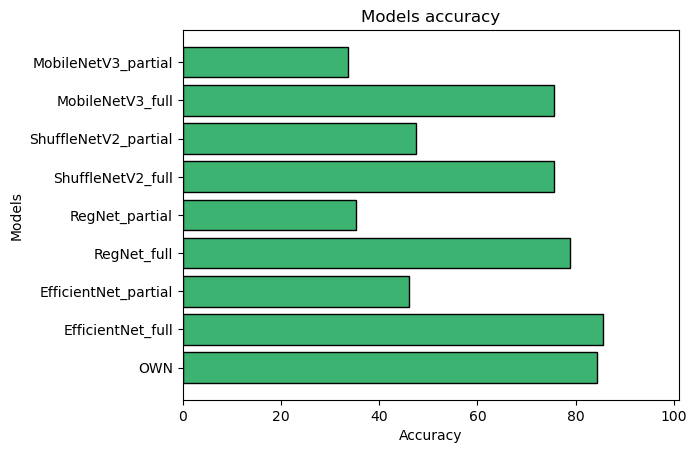

In [17]:
# horizontal bar chart for better readability
bar_vals = [res_own_acc]
bar_labels = ['OWN']
for model_name in model_names:
    for mode in ['full', 'partial']:
        bar_vals.append(res[model_name][mode]['acc'])
        bar_labels.append(model_name + '_' + mode)
plt.barh(np.arange(len(models)*2+1), np.array(bar_vals) * 100, color='mediumseagreen', ec='k', lw=1)
plt.yticks(np.arange(len(models)*2+1), labels=bar_labels)
plt.xlabel('Accuracy')
plt.ylabel('Models')
plt.title('Models accuracy')
plt.xlim([0, 101])

In [18]:
for model_name, acc in zip(bar_labels, bar_vals):
    print(model_name+':', acc)

OWN: 0.8431999683380127
EfficientNet_full: 0.8554999828338623
EfficientNet_partial: 0.45989999175071716
RegNet_full: 0.7888999581336975
RegNet_partial: 0.35259997844696045
ShuffleNetV2_full: 0.755899965763092
ShuffleNetV2_partial: 0.4756999909877777
MobileNetV3_full: 0.755899965763092
MobileNetV3_partial: 0.33719998598098755


In [19]:
print('Model name:', bar_labels[np.argmax(bar_vals)].split('_')[0])
print('\tMode:', bar_labels[np.argmax(bar_vals)].split('_')[1])
print('\tWeights: model_weights')
print('\tParams:')
print('\t\tepochs = 100,\n\t\tlr = 0.1,\n\t\tmomentum = 0.9,\n\t\tweight_decay = 5e-4,\n\t\tloss = CrossEntropyLoss,\n\t\toptimizer = SGD,\n\t\tscheduler = CosineAnnealingLR,\n\t\tdevice = cuda')
print('\tAccuracy:', max(bar_vals))

Model name: EfficientNet
	Mode: full
	Weights: model_weights
	Params:
		epochs = 100,
		lr = 0.1,
		momentum = 0.9,
		weight_decay = 5e-4,
		loss = CrossEntropyLoss,
		optimizer = SGD,
		scheduler = CosineAnnealingLR,
		device = cuda
	Accuracy: 0.8554999828338623


Classification Report

              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1000
           1       0.91      0.93      0.92      1000
           2       0.85      0.78      0.81      1000
           3       0.75      0.70      0.73      1000
           4       0.83      0.86      0.85      1000
           5       0.77      0.81      0.79      1000
           6       0.87      0.91      0.89      1000
           7       0.89      0.89      0.89      1000
           8       0.93      0.90      0.92      1000
           9       0.91      0.90      0.91      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

Roc auc scores:
	 0 : 0.9220555555555556
	 1 : 0.9595
	 2 : 0.8842222222222222
	 3 : 0.8388888888888889
	 4 : 0.9227222222222222
	 5 : 0.8925000000000001
	 6 : 0.9469444444444445
	 7 : 0.9371111111111112
	 8 : 0.948166

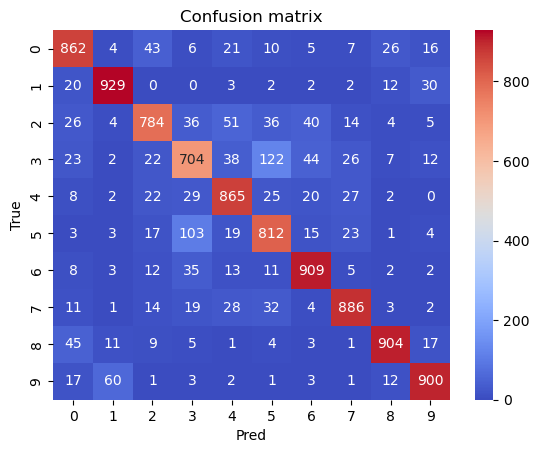

In [20]:
get_metrics(res['EfficientNet']['full']['true'], res['EfficientNet']['full']['pred'])